# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

In [2]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator

# Then import from noise_sampler_fixed_fc
from noise_sampler_fixed_fc import flicker_noise_sampler, flicker_likeli_func

Using the emulator for flicker noise correlation function.


In [3]:
# Load the simulation results
import pickle
from simulation import TODSimulation

with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)


In [4]:
sky_params = tod_sim.sky_params
nd_rec_params = tod_sim.nd_rec_params
gain_params_setting = tod_sim.gain_params_setting
calibration_indices = tod_sim.calibration_1_indice
alpha = tod_sim.alpha

TOD_setting = tod_sim.TOD_setting
t_list = tod_sim.t_list
gain_proj = tod_sim.gain_proj
Tsky_operator_setting = tod_sim.Tsky_operator_setting
nd_rec_operator = tod_sim.nd_rec_operator

logfc = tod_sim.logfc

# Additional variables needed for the analysis
pixel_indices = tod_sim.pixel_indices
nside = tod_sim.nside
f0 = tod_sim.f0
T_ndiode = tod_sim.T_ndiode
rec_params = tod_sim.rec_params
logf0_list = [tod_sim.logf0]  # Convert to list format as expected later

In [5]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

prior_std_frac = 0.1
Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = np.ones_like(nd_rec_params)*0.0
aux[0] = 1
Trec_prior_cov_inv = [aux] # Effectlively no prior


In [6]:
log_gain = np.log10(gain_proj@gain_params_setting)
# solve the linear system for the log_gain coeffs: gain_proj@ log_gain_coeffs = log_gain
log_gain_coeffs = np.linalg.lstsq(gain_proj, log_gain, rcond=None)[0]
print("log_gain_coeffs:", log_gain_coeffs)

gain_prior_cov_inv = np.zeros(4)
# prior_std_frac = 0.1
# gain_prior_cov_inv = 1. / (prior_std_frac * gain_params_setting)**2  # Prior STD ~100%
gain_prior_cov_inv[0] = 1/ (0.1 * 0.79977551)**2 # DC mode: Prior STD ~10%
gain_prior_mean = log_gain_coeffs

log_gain_coeffs: [0.79977551 0.02844282 0.01736516 0.00311427]


In [7]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting],
                                    [t_list],
                                    [gain_proj],
                                    [Tsky_operator_setting],
                                    [nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc],
                                    num_Jeffrey=False,
                                    log_linear_gain=True,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv,
                                    local_Trec_prior_mean_list=[nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_prior_mean],
                                    #local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    n_samples=3000,
                                    tol=1e-20,
                                    Est_mode=False)

# First, save the samples as npy files..

np.save("outputs/GS1/Tsys_samples_t2.npy", Tsys_samples)
np.save("outputs/GS1/gain_samples_t2.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1/noise_samples_t2.npy", np.concatenate(all_noise_samples, axis=0))



Rank: 0, local id: 0, gain_sample 0: [0.79972128 0.02843072 0.01733785 0.0033259 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 0: [-3.28019149  3.83549155]
Reached max iterations with fractional norm error 0.0006494268105026993.
Rank: 0, local id: 0, gain_sample 1: [ 0.79964423  0.03180736  0.01551495 -0.00262023]
Rank: 0, local id: 0, noise_sample 1: [-3.53722208  2.49596101]
Reached max iterations with fractional norm error 0.00047253282336444494.
Rank: 0, local id: 0, gain_sample 2: [0.79966667 0.02756344 0.01904299 0.00181516]
Rank: 0, local id: 0, noise_sample 2: [-3.7934968   2.21151455]
Reached max iterations with fractional norm error 0.0008134029939982667.
Rank: 0, local id: 0, gain_sample 3: [ 7.99535975e-01  3.01882499e-02  1.54892384e-02 -7.23774222e-04]
Rank: 0, local id: 0, noise_sample 3: [-4.18687335  1.81240753]
Reached max iterations with fractional norm error 0.0005306777164976885.
Rank: 0, local id: 0, gain_sample 4: [0.79979175 0.02950277 0.01649568 0.0025965 ]
Rank: 0, local id: 0, noise_sample 4: [-5.86214217  1.19732443]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 34: [-3.54888718  3.11002093]
Reached max iterations with fractional norm error 0.001821129864666387.
Rank: 0, local id: 0, gain_sample 35: [0.80076484 0.02903444 0.01751066 0.00374867]
Rank: 0, local id: 0, noise_sample 35: [-3.10819446  3.79469426]
Reached max iterations with fractional norm error 0.0041992267211157595.
Rank: 0, local id: 0, gain_sample 36: [0.80060755 0.02691033 0.0112209  0.00799102]
Rank: 0, local id: 0, noise_sample 36: [-3.1739302   3.16550872]
Reached max iterations with fractional norm error 0.0013119546075868514.
Rank: 0, local id: 0, gain_sample 37: [0.8007904  0.02478231 0.01327455 0.01108083]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 37: [-5.48271959  1.1517482 ]
Reached max iterations with fractional norm error 0.0009915129306785266.
Rank: 0, local id: 0, gain_sample 38: [0.80085713 0.02568759 0.01427171 0.0075002 ]
Rank: 0, local id: 0, noise_sample 38: [-4.57503336  1.44342181]
Reached max iterations with fractional norm error 0.0005792832213081537.
Rank: 0, local id: 0, gain_sample 39: [0.80104085 0.02781084 0.01566367 0.00239076]
Rank: 0, local id: 0, noise_sample 39: [-4.36062263  1.64434183]
Reached max iterations with fractional norm error 0.012552423707221294.
Rank: 0, local id: 0, gain_sample 40: [0.80109103 0.02872125 0.01659764 0.00402457]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 40: [-4.01645922  1.8975341 ]
Reached max iterations with fractional norm error 0.0024877140340291443.
Rank: 0, local id: 0, gain_sample 41: [8.01388715e-01 2.85820389e-02 1.98015737e-02 1.29191654e-04]
Rank: 0, local id: 0, noise_sample 41: [-3.67180027  2.27796854]
Reached max iterations with fractional norm error 0.0010497892496314637.
Rank: 0, local id: 0, gain_sample 42: [0.80118244 0.02823102 0.01902392 0.00371257]
Rank: 0, local id: 0, noise_sample 42: [-3.66030737  2.29385239]
Reached max iterations with fractional norm error 0.004000163058851367.
Rank: 0, local id: 0, gain_sample 43: [0.80144745 0.0280286  0.01881499 0.00322977]
Rank: 0, local id: 0, noise_sample 43: [-3.83934342  2.21309499]
Reached max iterations with fractional norm error 0.000979346017207002.
Rank: 0, local id: 0, gain_sample 44: [0.80151097 0.0286584  0.01809419 0.0022735 ]
Rank: 0, local id: 0, noise_sample 44: [-3.87826312  2.18304253]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 47: [-5.1799629  1.3714972]
Reached max iterations with fractional norm error 0.0026015199909965167.
Rank: 0, local id: 0, gain_sample 48: [0.80106875 0.02866102 0.01661023 0.0019421 ]
Rank: 0, local id: 0, noise_sample 48: [-4.5738703   1.65425919]
Reached max iterations with fractional norm error 0.00029698682175617445.
Rank: 0, local id: 0, gain_sample 49: [0.80112781 0.02879404 0.01693581 0.00106495]
Rank: 0, local id: 0, noise_sample 49: [-4.76249434  1.56467119]
Reached max iterations with fractional norm error 0.0005363588906814353.
Rank: 0, local id: 0, gain_sample 50: [0.80121117 0.02878397 0.01750886 0.00096225]
Rank: 0, local id: 0, noise_sample 50: [-4.28811282  1.91173013]
Reached max iterations with fractional norm error 0.0013786683349965565.
Rank: 0, local id: 0, gain_sample 51: [0.80124851 0.02825784 0.01740118 0.0027216 ]
Rank: 0, local id: 0, noise_sample 51: [-5.59202179  1.21335817]
Reached max iterations with fractional norm erro

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 55: [-4.55120343  1.88795677]
Reached max iterations with fractional norm error 0.0008974920460893458.
Rank: 0, local id: 0, gain_sample 56: [0.80137722 0.02934311 0.01550182 0.00372149]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 56: [-3.32321875  3.82793589]
Reached max iterations with fractional norm error 0.0001042759283617605.
Rank: 0, local id: 0, gain_sample 57: [0.80147793 0.02901189 0.01699297 0.00446631]
Rank: 0, local id: 0, noise_sample 57: [-3.93950005  2.36541263]
Reached max iterations with fractional norm error 0.008727285094862732.
Rank: 0, local id: 0, gain_sample 58: [0.8015536  0.02855922 0.01677734 0.00517694]
Rank: 0, local id: 0, noise_sample 58: [-3.94523194  2.34349332]
Reached max iterations with fractional norm error 0.0012315640687332488.
Rank: 0, local id: 0, gain_sample 59: [0.80163325 0.02851713 0.01741903 0.00395659]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 59: [-3.79729125  2.66616445]
Reached max iterations with fractional norm error 0.001783079899806106.
Rank: 0, local id: 0, gain_sample 60: [0.80179804 0.02860795 0.0195222  0.00350565]
Rank: 0, local id: 0, noise_sample 60: [-4.00691546  2.05818984]
Reached max iterations with fractional norm error 0.0013236615774089406.
Rank: 0, local id: 0, gain_sample 61: [0.80168256 0.02869385 0.01959052 0.00436542]
Rank: 0, local id: 0, noise_sample 61: [-3.40987697  3.13396794]
Reached max iterations with fractional norm error 0.0004392264230085656.
Rank: 0, local id: 0, gain_sample 62: [ 0.80171156  0.03012486  0.0182531  -0.00100418]
Rank: 0, local id: 0, noise_sample 62: [-3.6276729   2.66223164]
Reached max iterations with fractional norm error 0.00023824880360487225.
Rank: 0, local id: 0, gain_sample 63: [8.01690063e-01 2.95816100e-02 1.65759220e-02 2.20368800e-04]
Rank: 0, local id: 0, noise_sample 63: [-3.30628294  3.62585906]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 73: [-3.34811352  3.97244191]
Reached max iterations with fractional norm error 4.052768001544305e-05.
Rank: 0, local id: 0, gain_sample 74: [0.80210656 0.02831504 0.01804052 0.00249202]
Rank: 0, local id: 0, noise_sample 74: [-4.4996664   1.92004975]
Reached max iterations with fractional norm error 0.002897836802168863.
Rank: 0, local id: 0, gain_sample 75: [0.80208324 0.02815316 0.01786445 0.00370589]
Rank: 0, local id: 0, noise_sample 75: [-4.01357793  2.48148118]
Reached max iterations with fractional norm error 0.00020374340954834746.
Rank: 0, local id: 0, gain_sample 76: [0.80200477 0.02876216 0.01785468 0.00382569]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 76: [-3.07936207  3.98585354]
Reached max iterations with fractional norm error 0.006255447036612828.
Rank: 0, local id: 0, gain_sample 77: [0.80167663 0.02720405 0.01505051 0.01171844]
Rank: 0, local id: 0, noise_sample 77: [-3.54186238  2.32568773]
Reached max iterations with fractional norm error 0.0003249037890687485.
Rank: 0, local id: 0, gain_sample 78: [0.80142831 0.02707774 0.01127652 0.00481121]
Rank: 0, local id: 0, noise_sample 78: [-4.53747446  1.4580473 ]
Reached max iterations with fractional norm error 0.0013099852891731332.
Rank: 0, local id: 0, gain_sample 79: [0.80179488 0.02826509 0.01517734 0.00412039]
Rank: 0, local id: 0, noise_sample 79: [-4.26098316  1.65785028]
Reached max iterations with fractional norm error 0.0009789375851318343.
Rank: 0, local id: 0, gain_sample 80: [0.80186001 0.030039   0.01666689 0.00240443]
Rank: 0, local id: 0, noise_sample 80: [-3.73937815  2.13883155]
Reached max iterations with fractional norm erro

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 83: [-3.3276148   3.23600803]
Reached max iterations with fractional norm error 4.383734908200467e-05.
Rank: 0, local id: 0, gain_sample 84: [0.80152699 0.02767979 0.02096344 0.00250712]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 84: [-3.01241534  3.1719494 ]
Reached max iterations with fractional norm error 0.005405388059636655.
Rank: 0, local id: 0, gain_sample 85: [0.80134771 0.0248086  0.01911077 0.0086214 ]
Rank: 0, local id: 0, noise_sample 85: [-3.38949121  2.505682  ]
Reached max iterations with fractional norm error 0.0016336217529582902.
Rank: 0, local id: 0, gain_sample 86: [0.80090855 0.02876309 0.01498208 0.00456523]
Rank: 0, local id: 0, noise_sample 86: [-3.84832169  2.06654357]
Reached max iterations with fractional norm error 0.0010448041778465323.
Rank: 0, local id: 0, gain_sample 87: [0.80126405 0.02790604 0.01768929 0.00310081]
Rank: 0, local id: 0, noise_sample 87: [-3.09422774  2.79923108]
Reached max iterations with fractional norm error 0.00041889057655861226.
Rank: 0, local id: 0, gain_sample 88: [0.8013204  0.02766297 0.0234877  0.00708655]
Rank: 0, local id: 0, noise_sample 88: [-3.42592297  2.28804413]
Reached max iterations with fractional norm err

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 93: [-4.73926538  1.45058684]
Reached max iterations with fractional norm error 0.0004896961644443778.
Rank: 0, local id: 0, gain_sample 94: [0.80205519 0.02871187 0.01830476 0.00314567]
Rank: 0, local id: 0, noise_sample 94: [-4.1480049   1.82202845]
Reached max iterations with fractional norm error 0.0033145219201263752.
Rank: 0, local id: 0, gain_sample 95: [0.80187364 0.02765184 0.01632728 0.00413732]
Rank: 0, local id: 0, noise_sample 95: [-3.87117261  2.06056243]
Reached max iterations with fractional norm error 0.0029875368701291418.
Rank: 0, local id: 0, gain_sample 96: [0.80172008 0.02860617 0.01788879 0.00146714]
Rank: 0, local id: 0, noise_sample 96: [-3.89508114  2.03407678]
Reached max iterations with fractional norm error 0.0022357320316933817.
Rank: 0, local id: 0, gain_sample 97: [0.80175592 0.02892987 0.01706297 0.0029406 ]
Rank: 0, local id: 0, noise_sample 97: [-3.91063464  1.96139166]
Reached max iterations with fractional norm err

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 114: [-4.99995544  1.11350309]
Reached max iterations with fractional norm error 0.0011957451333571155.
Rank: 0, local id: 0, gain_sample 115: [8.01608702e-01 3.19108734e-02 2.39071547e-02 6.15505352e-04]
Rank: 0, local id: 0, noise_sample 115: [-3.32081935  2.6105599 ]
Reached max iterations with fractional norm error 0.0016193650329499707.
Rank: 0, local id: 0, gain_sample 116: [ 0.80150735  0.02971941  0.02539448 -0.00208202]
Rank: 0, local id: 0, noise_sample 116: [-4.78502979  1.27252744]
Reached max iterations with fractional norm error 0.010520665171885367.
Rank: 0, local id: 0, gain_sample 117: [8.00994326e-01 2.87299209e-02 2.06948385e-02 4.04391294e-04]
Rank: 0, local id: 0, noise_sample 117: [-4.61399554  1.43326732]
Reached max iterations with fractional norm error 0.000846800850393741.
Rank: 0, local id: 0, gain_sample 118: [0.80068113 0.02815089 0.01957715 0.00452286]
Rank: 0, local id: 0, noise_sample 118: [-3.52242183  2.6913899 ]
Reac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 129: [-3.34104089  2.49208809]
Reached max iterations with fractional norm error 0.0019100354156415594.
Rank: 0, local id: 0, gain_sample 130: [0.80091556 0.03031556 0.02569343 0.00413179]
Rank: 0, local id: 0, noise_sample 130: [-3.44024366  2.49334918]
Reached max iterations with fractional norm error 9.804134285576295e-05.
Rank: 0, local id: 0, gain_sample 131: [ 0.80087854  0.03180859  0.02427171 -0.00187134]
Rank: 0, local id: 0, noise_sample 131: [-3.69911195  2.03071381]
Reached max iterations with fractional norm error 0.002634048126351386.
Rank: 0, local id: 0, gain_sample 132: [0.80037578 0.0301305  0.01589308 0.00238003]
Rank: 0, local id: 0, noise_sample 132: [-3.86051965  1.94074328]
Reached max iterations with fractional norm error 0.0024004171980870547.
Rank: 0, local id: 0, gain_sample 133: [0.80087663 0.02909213 0.02010648 0.00532876]
Rank: 0, local id: 0, noise_sample 133: [-3.5821242   2.26085439]
Reached max iterations with fractio

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 156: [-3.80389108  2.51659494]
Reached max iterations with fractional norm error 0.00013382449532580722.
Rank: 0, local id: 0, gain_sample 157: [0.79851228 0.02852835 0.01817459 0.00241071]
Rank: 0, local id: 0, noise_sample 157: [-3.14502656  3.51810551]
Reached max iterations with fractional norm error 0.001825291792456259.
Rank: 0, local id: 0, gain_sample 158: [0.79826588 0.02969723 0.01396141 0.00464688]
Rank: 0, local id: 0, noise_sample 158: [-3.50184129  2.50045865]
Reached max iterations with fractional norm error 0.004652077393321869.
Rank: 0, local id: 0, gain_sample 159: [0.79866974 0.02895074 0.01393367 0.00513865]
Rank: 0, local id: 0, noise_sample 159: [-4.56726723  1.53896586]
Reached max iterations with fractional norm error 0.00015959594230101186.
Rank: 0, local id: 0, gain_sample 160: [0.79904499 0.02895887 0.01782712 0.00395025]
Rank: 0, local id: 0, noise_sample 160: [-3.63251973  2.51016063]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 161: [-5.35568452  1.26745641]
Reached max iterations with fractional norm error 0.0005390765139535646.
Rank: 0, local id: 0, gain_sample 162: [0.79921239 0.02912535 0.0185946  0.003751  ]
Rank: 0, local id: 0, noise_sample 162: [-4.50667626  1.64189499]
Reached max iterations with fractional norm error 0.0036689591965655783.
Rank: 0, local id: 0, gain_sample 163: [0.7990868  0.02916313 0.01702734 0.00202026]
Rank: 0, local id: 0, noise_sample 163: [-3.00919727  2.91949718]
Reached max iterations with fractional norm error 0.0027647709303591996.
Rank: 0, local id: 0, gain_sample 164: [0.80019754 0.02761609 0.02531433 0.01139432]
Rank: 0, local id: 0, noise_sample 164: [-3.99428262  1.50055654]
Reached max iterations with fractional norm error 0.003172890789642243.
Rank: 0, local id: 0, gain_sample 165: [0.79960369 0.02891138 0.02037571 0.00182848]
Rank: 0, local id: 0, noise_sample 165: [-3.898423   1.6702727]
Reached max iterations with fractional no

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 173: [-3.62453669  2.27533564]
Reached max iterations with fractional norm error 0.0006414861365557047.
Rank: 0, local id: 0, gain_sample 174: [0.79810029 0.02794709 0.01799302 0.00848062]
Rank: 0, local id: 0, noise_sample 174: [-3.45111296  2.50521414]
Reached max iterations with fractional norm error 0.0012382723653589194.
Rank: 0, local id: 0, gain_sample 175: [0.79785555 0.02986896 0.02266832 0.00504426]
Rank: 0, local id: 0, noise_sample 175: [-3.42761457  2.31217265]
Reached max iterations with fractional norm error 0.006888917688026577.
Rank: 0, local id: 0, gain_sample 176: [0.79748631 0.0273432  0.01896145 0.00674624]
Rank: 0, local id: 0, noise_sample 176: [-3.4500923  2.2943525]
Reached max iterations with fractional norm error 0.0034599758187795504.
Rank: 0, local id: 0, gain_sample 177: [0.7979255  0.02398593 0.02547265 0.00481502]
Rank: 0, local id: 0, noise_sample 177: [-3.40839113  2.28756971]
Reached max iterations with fractional no

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 178: [-3.22076571  3.83064051]
Reached max iterations with fractional norm error 0.0016004140946264686.
Rank: 0, local id: 0, gain_sample 179: [0.79770305 0.02693109 0.01780769 0.00576633]
Rank: 0, local id: 0, noise_sample 179: [-4.35812747  1.77750992]
Reached max iterations with fractional norm error 0.0003746092089823199.
Rank: 0, local id: 0, gain_sample 180: [0.7975866  0.027943   0.01672389 0.00474263]
Rank: 0, local id: 0, noise_sample 180: [-3.88898725  2.14703411]
Reached max iterations with fractional norm error 0.0016648039788086963.
Rank: 0, local id: 0, gain_sample 181: [0.79757001 0.02742113 0.01838016 0.00426716]
Rank: 0, local id: 0, noise_sample 181: [-3.91580356  2.11060656]
Reached max iterations with fractional norm error 0.0032700397169312854.
Rank: 0, local id: 0, gain_sample 182: [0.79743087 0.02833898 0.01737429 0.00377014]
Rank: 0, local id: 0, noise_sample 182: [-3.01364552  2.75044926]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 185: [-3.07735423  3.82339549]
Reached max iterations with fractional norm error 0.00018137575225301685.
Rank: 0, local id: 0, gain_sample 186: [ 0.79530228  0.03497683  0.01641359 -0.00382302]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 186: [-3.45857534  3.12180161]
Reached max iterations with fractional norm error 0.0008357490096558966.
Rank: 0, local id: 0, gain_sample 187: [0.79545089 0.02882873 0.01991987 0.00433439]
Rank: 0, local id: 0, noise_sample 187: [-3.7178371   2.34807612]
Reached max iterations with fractional norm error 0.0004657459831163394.
Rank: 0, local id: 0, gain_sample 188: [0.79539012 0.02840555 0.01917479 0.00092538]
Rank: 0, local id: 0, noise_sample 188: [-3.68114681  2.37512683]
Reached max iterations with fractional norm error 0.0009387790990686476.
Rank: 0, local id: 0, gain_sample 189: [0.7953517  0.02817285 0.01566633 0.0052332 ]
Rank: 0, local id: 0, noise_sample 189: [-4.71068667  1.51438233]
Reached max iterations with fractional norm error 0.01091425155487973.
Rank: 0, local id: 0, gain_sample 190: [0.79521455 0.02802126 0.01480282 0.00480863]
Rank: 0, local id: 0, noise_sample 190: [-3.7193449   2.22955331]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 197: [-3.13030783  3.81002934]
Reached max iterations with fractional norm error 0.0030649404553946724.
Rank: 0, local id: 0, gain_sample 198: [0.79473199 0.03016755 0.00971995 0.00261585]
Rank: 0, local id: 0, noise_sample 198: [-4.75913318  1.33385912]
Reached max iterations with fractional norm error 0.0009672001190661571.
Rank: 0, local id: 0, gain_sample 199: [0.79530325 0.02954392 0.01389248 0.00160565]
Rank: 0, local id: 0, noise_sample 199: [-3.95520426  1.78771255]
Reached max iterations with fractional norm error 0.0031165823436203.
Rank: 0, local id: 0, gain_sample 200: [0.79544337 0.02896936 0.01518592 0.00401087]
Rank: 0, local id: 0, noise_sample 200: [-3.09384695  2.45048715]
Reached max iterations with fractional norm error 0.00021979984779154187.
Rank: 0, local id: 0, gain_sample 201: [0.79496023 0.02246981 0.01619577 0.0099197 ]
Rank: 0, local id: 0, noise_sample 201: [-3.41805771  2.24556367]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 210: [-4.52897439  1.75104689]
Reached max iterations with fractional norm error 0.0003824401707207911.
Rank: 0, local id: 0, gain_sample 211: [0.79531153 0.02922507 0.01689173 0.00158719]
Rank: 0, local id: 0, noise_sample 211: [-3.81080997  2.5525207 ]
Reached max iterations with fractional norm error 0.0011092956155972719.
Rank: 0, local id: 0, gain_sample 212: [0.79521874 0.02845843 0.01709331 0.00290391]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 212: [-4.66862542  1.80208975]
Reached max iterations with fractional norm error 8.059166797989355e-05.
Rank: 0, local id: 0, gain_sample 213: [0.7952103  0.0286796  0.01798085 0.00343762]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 213: [-3.61057781  3.11916625]
Reached max iterations with fractional norm error 0.00031900289107670833.
Rank: 0, local id: 0, gain_sample 214: [0.79531886 0.02903913 0.01759861 0.00160407]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 214: [-3.83602018  2.72474014]
Reached max iterations with fractional norm error 0.004151388068646746.
Rank: 0, local id: 0, gain_sample 215: [0.79527541 0.0285162  0.01788711 0.00107461]
Rank: 0, local id: 0, noise_sample 215: [-4.02271818  2.2904462 ]
Reached max iterations with fractional norm error 0.006186555959955017.
Rank: 0, local id: 0, gain_sample 216: [0.79519236 0.02846048 0.0178347  0.00083593]
Rank: 0, local id: 0, noise_sample 216: [-4.38717845  1.94917726]
Reached max iterations with fractional norm error 0.0004336571626631631.
Rank: 0, local id: 0, gain_sample 217: [7.95207539e-01 2.85561957e-02 1.75645870e-02 4.35771643e-04]
Rank: 0, local id: 0, noise_sample 217: [-4.56388741  1.84513928]
Reached max iterations with fractional norm error 0.0006511612904570701.
Rank: 0, local id: 0, gain_sample 218: [0.795234   0.02852331 0.01763666 0.00117531]
Rank: 0, local id: 0, noise_sample 218: [-4.80061781  1.70384412]
Reached max iterations w

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 220: [-4.69705542  1.32344059]
Reached max iterations with fractional norm error 0.0040121370291263435.
Rank: 0, local id: 0, gain_sample 221: [0.79585101 0.02666016 0.02182056 0.0012042 ]
Rank: 0, local id: 0, noise_sample 221: [-3.42930314  2.14969702]
Reached max iterations with fractional norm error 0.0010445299175661626.
Rank: 0, local id: 0, gain_sample 222: [ 7.95139897e-01  2.82586226e-02  1.37453781e-02 -4.01951419e-04]
Rank: 0, local id: 0, noise_sample 222: [-4.28847837  1.63146894]
Reached max iterations with fractional norm error 0.0010996655641329867.
Rank: 0, local id: 0, gain_sample 223: [ 7.95446996e-01  2.79029115e-02  1.65508193e-02 -7.06281462e-04]
Rank: 0, local id: 0, noise_sample 223: [-3.84299564  2.01486814]
Reached max iterations with fractional norm error 0.0003003380256642066.
Rank: 0, local id: 0, gain_sample 224: [0.79538309 0.02750167 0.01906243 0.00311103]
Rank: 0, local id: 0, noise_sample 224: [-3.62976562  2.30328586

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 236: [-3.57901739  3.07773373]
Reached max iterations with fractional norm error 0.0035695645937960973.
Rank: 0, local id: 0, gain_sample 237: [0.79477757 0.02931474 0.01984643 0.00192479]
Rank: 0, local id: 0, noise_sample 237: [-4.45366017  1.69724909]
Reached max iterations with fractional norm error 0.0013259352772834695.
Rank: 0, local id: 0, gain_sample 238: [0.79471461 0.02896369 0.01915209 0.00130334]
Rank: 0, local id: 0, noise_sample 238: [-4.02158796  2.04091043]
Reached max iterations with fractional norm error 0.00020711622759135792.
Rank: 0, local id: 0, gain_sample 239: [0.79457588 0.02767965 0.01799302 0.00214353]
Rank: 0, local id: 0, noise_sample 239: [-4.26078406  1.78099083]
Reached max iterations with fractional norm error 0.0012185005593479074.
Rank: 0, local id: 0, gain_sample 240: [0.79444456 0.02836742 0.01663646 0.00274622]
Rank: 0, local id: 0, noise_sample 240: [-3.91099443  2.14686843]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 270: [-3.21996907  3.96617868]
Reached max iterations with fractional norm error 0.002098366312273752.
Rank: 0, local id: 0, gain_sample 271: [0.79442213 0.02810106 0.02233757 0.00674147]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 271: [-3.06388274  2.42052899]
Reached max iterations with fractional norm error 0.012016091771152967.
Rank: 0, local id: 0, gain_sample 272: [ 0.79374181  0.03293248  0.01983198 -0.00448119]
Rank: 0, local id: 0, noise_sample 272: [-3.51660823  1.95361844]
Reached max iterations with fractional norm error 0.005009058343362435.
Rank: 0, local id: 0, gain_sample 273: [7.93792691e-01 2.99890056e-02 2.45668596e-02 1.70287276e-04]
Rank: 0, local id: 0, noise_sample 273: [-3.42450128  2.09688591]
Reached max iterations with fractional norm error 0.00041994039965501947.
Rank: 0, local id: 0, gain_sample 274: [0.79317182 0.02735322 0.02044037 0.00970411]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 274: [-4.96562355  1.29003781]
Reached max iterations with fractional norm error 0.0005517960159990364.
Rank: 0, local id: 0, gain_sample 275: [0.79301647 0.02881569 0.01915083 0.00633059]
Rank: 0, local id: 0, noise_sample 275: [-4.42404644  1.57018631]
Reached max iterations with fractional norm error 0.00010119686274224707.
Rank: 0, local id: 0, gain_sample 276: [0.79275914 0.02835105 0.01851958 0.00437921]
Rank: 0, local id: 0, noise_sample 276: [-3.90764086  1.93324545]
Reached max iterations with fractional norm error 0.0003266760758323055.
Rank: 0, local id: 0, gain_sample 277: [0.79249947 0.02860059 0.01587947 0.00241586]
Rank: 0, local id: 0, noise_sample 277: [-3.68234458  2.17618266]
Reached max iterations with fractional norm error 0.0002841452971240105.
Rank: 0, local id: 0, gain_sample 278: [0.79247036 0.02635176 0.01597514 0.00504926]
Rank: 0, local id: 0, noise_sample 278: [-4.34297178  1.60522627]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 292: [-3.07166358  3.86091931]
Reached max iterations with fractional norm error 0.00028954232797620024.
Rank: 0, local id: 0, gain_sample 293: [0.79305925 0.0208791  0.01642027 0.01057892]
Rank: 0, local id: 0, noise_sample 293: [-4.32925234  1.54007521]
Reached max iterations with fractional norm error 0.000181696868425264.
Rank: 0, local id: 0, gain_sample 294: [0.79314858 0.02638766 0.01630802 0.00176961]
Rank: 0, local id: 0, noise_sample 294: [-4.54501689  1.45871983]
Reached max iterations with fractional norm error 0.0011567815930213306.
Rank: 0, local id: 0, gain_sample 295: [0.7932633  0.02763839 0.01763605 0.0009985 ]
Rank: 0, local id: 0, noise_sample 295: [-3.98094565  1.82546308]
Reached max iterations with fractional norm error 0.009931508000473925.
Rank: 0, local id: 0, gain_sample 296: [ 0.79329012  0.02786475  0.01730497 -0.00181777]
Rank: 0, local id: 0, noise_sample 296: [-3.6277829   2.15354677]
Reached max iterations with fractio

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 297: [-3.40209567  3.96931046]
Reached max iterations with fractional norm error 0.0006973185126124704.
Rank: 0, local id: 0, gain_sample 298: [0.7935654  0.02763088 0.0180363  0.00082286]
Rank: 0, local id: 0, noise_sample 298: [-3.8551712   2.47327206]
Reached max iterations with fractional norm error 0.00047312824691273913.
Rank: 0, local id: 0, gain_sample 299: [0.79313718 0.02691818 0.01497032 0.00287038]
Rank: 0, local id: 0, noise_sample 299: [-3.90877567  2.02611723]
Reached max iterations with fractional norm error 0.0008329162101263091.
Rank: 0, local id: 0, gain_sample 300: [0.79323372 0.02920993 0.01798572 0.00283097]
Rank: 0, local id: 0, noise_sample 300: [-3.42978126  2.51356307]
Reached max iterations with fractional norm error 0.00028069311375451323.
Rank: 0, local id: 0, gain_sample 301: [0.79335242 0.03012614 0.01712732 0.00119044]
Rank: 0, local id: 0, noise_sample 301: [-4.18915166  1.81727802]
Reached max iterations with fraction

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 305: [-3.03988958  3.96017309]
Reached max iterations with fractional norm error 0.0007126160487516398.
Rank: 0, local id: 0, gain_sample 306: [ 0.79343753  0.03182174  0.01634969 -0.00319551]
Rank: 0, local id: 0, noise_sample 306: [-3.03535536  3.19331161]
Reached max iterations with fractional norm error 0.0013797787372755825.
Rank: 0, local id: 0, gain_sample 307: [0.79323036 0.03069872 0.01912585 0.00419049]
Rank: 0, local id: 0, noise_sample 307: [-3.38603046  2.51617179]
Reached max iterations with fractional norm error 0.0016434464522348386.
Rank: 0, local id: 0, gain_sample 308: [0.79338707 0.02776699 0.02063529 0.0096471 ]
Rank: 0, local id: 0, noise_sample 308: [-3.4749767   2.57923639]
Reached max iterations with fractional norm error 0.0011817035034931763.
Rank: 0, local id: 0, gain_sample 309: [0.79372701 0.02595394 0.02076639 0.01163546]
Rank: 0, local id: 0, noise_sample 309: [-3.94186025  1.73540521]
Reached max iterations with fracti

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 313: [-3.56731038  2.257985  ]
Reached max iterations with fractional norm error 0.0010831540477687198.
Rank: 0, local id: 0, gain_sample 314: [0.79358878 0.02945586 0.01882962 0.00415935]
Rank: 0, local id: 0, noise_sample 314: [-4.13280128  1.74980608]
Reached max iterations with fractional norm error 0.00046008222918953053.
Rank: 0, local id: 0, gain_sample 315: [0.79342683 0.02800298 0.01726824 0.00440324]
Rank: 0, local id: 0, noise_sample 315: [-4.19137407  1.83625679]
Reached max iterations with fractional norm error 0.0008416202496417716.
Rank: 0, local id: 0, gain_sample 316: [0.793415   0.02845932 0.01865606 0.00340719]
Rank: 0, local id: 0, noise_sample 316: [-4.78185493  1.51142852]
Reached max iterations with fractional norm error 0.0010149741201810566.
Rank: 0, local id: 0, gain_sample 317: [0.79334401 0.02833258 0.01812123 0.00317536]
Rank: 0, local id: 0, noise_sample 317: [-4.46372069  1.83558288]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 361: [-3.15953711  3.96822441]
Reached max iterations with fractional norm error 0.00010027813551111882.
Rank: 0, local id: 0, gain_sample 362: [0.79200922 0.02405168 0.01371575 0.012973  ]
Rank: 0, local id: 0, noise_sample 362: [-3.65055497  2.54863839]
Reached max iterations with fractional norm error 0.0005934388176674383.
Rank: 0, local id: 0, gain_sample 363: [0.79208309 0.02891343 0.01657424 0.00614433]
Rank: 0, local id: 0, noise_sample 363: [-3.1692333   2.90008052]
Reached max iterations with fractional norm error 0.000768619273600816.
Rank: 0, local id: 0, gain_sample 364: [0.79155195 0.02858845 0.01008941 0.00823526]
Rank: 0, local id: 0, noise_sample 364: [-4.31219443  1.54347951]
Reached max iterations with fractional norm error 0.0025924397976333593.
Rank: 0, local id: 0, gain_sample 365: [0.79224271 0.02923245 0.0164163  0.0050396 ]
Rank: 0, local id: 0, noise_sample 365: [-3.05168296  2.92046591]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 371: [-3.16928577  3.81033594]
Reached max iterations with fractional norm error 0.00019954687013847873.
Rank: 0, local id: 0, gain_sample 372: [0.79154338 0.02948948 0.01890336 0.00369988]
Rank: 0, local id: 0, noise_sample 372: [-3.9162321  2.1500571]
Reached max iterations with fractional norm error 0.0033613829019534815.
Rank: 0, local id: 0, gain_sample 373: [0.79153917 0.0280681  0.01797815 0.00449784]
Rank: 0, local id: 0, noise_sample 373: [-3.97853424  2.06908871]
Reached max iterations with fractional norm error 0.00356845427266161.
Rank: 0, local id: 0, gain_sample 374: [0.79141578 0.02817487 0.01764865 0.00264396]
Rank: 0, local id: 0, noise_sample 374: [-4.17846212  1.93437883]
Reached max iterations with fractional norm error 0.00448972958836027.
Rank: 0, local id: 0, gain_sample 375: [0.79131765 0.02795295 0.01692922 0.00446177]
Rank: 0, local id: 0, noise_sample 375: [-3.88613768  2.26487854]
Reached max iterations with fractional norm

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 385: [-3.13904413  3.82455841]
Reached max iterations with fractional norm error 0.0008037348984858004.
Rank: 0, local id: 0, gain_sample 386: [0.79094918 0.02551528 0.01632126 0.01185858]
Rank: 0, local id: 0, noise_sample 386: [-3.507045    2.74788995]
Reached max iterations with fractional norm error 0.0015032995615471751.
Rank: 0, local id: 0, gain_sample 387: [0.79109966 0.02856597 0.01805105 0.00570361]
Rank: 0, local id: 0, noise_sample 387: [-3.72107561  2.48392188]
Reached max iterations with fractional norm error 6.46915722321819e-05.
Rank: 0, local id: 0, gain_sample 388: [0.79115732 0.02918327 0.01772914 0.00475726]
Rank: 0, local id: 0, noise_sample 388: [-3.96335218  2.19370848]
Reached max iterations with fractional norm error 0.003684311608377019.
Rank: 0, local id: 0, gain_sample 389: [0.79105816 0.02897183 0.01882663 0.00354826]
Rank: 0, local id: 0, noise_sample 389: [-3.87261062  2.31970123]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 394: [-3.19719177  3.61858944]
Reached max iterations with fractional norm error 0.0005446912549423102.
Rank: 0, local id: 0, gain_sample 395: [7.90447212e-01 2.95100341e-02 1.51785058e-02 5.68181885e-04]
Rank: 0, local id: 0, noise_sample 395: [-5.43374576  1.3230801 ]
Reached max iterations with fractional norm error 0.001238745697154838.
Rank: 0, local id: 0, gain_sample 396: [7.90513706e-01 2.96291252e-02 1.63419800e-02 2.22013054e-04]
Rank: 0, local id: 0, noise_sample 396: [-3.77161939  2.64376275]
Reached max iterations with fractional norm error 0.0024815955829260183.
Rank: 0, local id: 0, gain_sample 397: [0.79040839 0.02825551 0.01576784 0.00157319]
Rank: 0, local id: 0, noise_sample 397: [-4.52790296  1.77137393]
Reached max iterations with fractional norm error 0.004370640379707914.
Rank: 0, local id: 0, gain_sample 398: [0.79055074 0.02824369 0.0168922  0.00087106]
Rank: 0, local id: 0, noise_sample 398: [-4.125653    2.22391675]
Reached 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 404: [-3.25359984  1.9194699 ]
Reached max iterations with fractional norm error 0.0016660529242141734.
Rank: 0, local id: 0, gain_sample 405: [0.78998809 0.02573458 0.02714512 0.02334129]
Rank: 0, local id: 0, noise_sample 405: [-4.67463799  1.27822271]
Reached max iterations with fractional norm error 0.0007784131921818117.
Rank: 0, local id: 0, gain_sample 406: [0.7893392  0.0277642  0.02116601 0.01109137]
Rank: 0, local id: 0, noise_sample 406: [-3.7884135   1.74931925]
Reached max iterations with fractional norm error 6.881478368907336e-05.
Rank: 0, local id: 0, gain_sample 407: [0.78896592 0.02731378 0.01706008 0.00650129]
Rank: 0, local id: 0, noise_sample 407: [-3.50306231  2.04228651]
Reached max iterations with fractional norm error 0.0008213006430608792.
Rank: 0, local id: 0, gain_sample 408: [0.78905694 0.02926767 0.0175389  0.00199449]
Rank: 0, local id: 0, noise_sample 408: [-4.11010477  1.68902498]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 432: [-3.58399319  3.89200008]
Reached max iterations with fractional norm error 0.00018086821685367544.
Rank: 0, local id: 0, gain_sample 433: [0.78944482 0.02794356 0.01849504 0.00247065]
Rank: 0, local id: 0, noise_sample 433: [-3.65238412  3.34561878]
Reached max iterations with fractional norm error 0.0005261627342862686.
Rank: 0, local id: 0, gain_sample 434: [0.78951946 0.02785612 0.01877647 0.00180707]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 434: [-3.64793422  3.10216166]
Reached max iterations with fractional norm error 0.004025569877933908.
Rank: 0, local id: 0, gain_sample 435: [0.78944285 0.02752884 0.01807712 0.00227583]
Rank: 0, local id: 0, noise_sample 435: [-3.92128363  2.59310554]
Reached max iterations with fractional norm error 0.0007064917919955581.
Rank: 0, local id: 0, gain_sample 436: [0.78946624 0.0272731  0.01811916 0.00316848]
Rank: 0, local id: 0, noise_sample 436: [-3.74997356  2.71758371]
Reached max iterations with fractional norm error 0.0028311613961853823.
Rank: 0, local id: 0, gain_sample 437: [0.78935171 0.02747835 0.01726768 0.00378125]
Rank: 0, local id: 0, noise_sample 437: [-4.04317005  2.25797789]
Reached max iterations with fractional norm error 0.008553813126628238.
Rank: 0, local id: 0, gain_sample 438: [0.78926267 0.02775269 0.01686353 0.00408617]
Rank: 0, local id: 0, noise_sample 438: [-3.18610398  3.51188456]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 445: [-3.25435714  3.82519409]
Reached max iterations with fractional norm error 0.0034821885111516447.
Rank: 0, local id: 0, gain_sample 446: [0.78898632 0.02870508 0.01723296 0.00112762]
Rank: 0, local id: 0, noise_sample 446: [-4.1453908   2.10278525]
Reached max iterations with fractional norm error 0.00013872799595091972.
Rank: 0, local id: 0, gain_sample 447: [0.78890017 0.02880268 0.01764993 0.0021962 ]
Rank: 0, local id: 0, noise_sample 447: [-4.4437918   1.91464651]
Reached max iterations with fractional norm error 0.0006965199488845158.
Rank: 0, local id: 0, gain_sample 448: [0.78876174 0.02837045 0.01689248 0.00242894]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 448: [-3.31077235  3.96334098]
Reached max iterations with fractional norm error 0.0001825270165996539.
Rank: 0, local id: 0, gain_sample 449: [0.78891602 0.02613774 0.01888398 0.00492345]
Rank: 0, local id: 0, noise_sample 449: [-3.84633866  1.96697241]
Reached max iterations with fractional norm error 0.0018064667822250344.
Rank: 0, local id: 0, gain_sample 450: [0.78875016 0.02851836 0.01817399 0.00100047]
Rank: 0, local id: 0, noise_sample 450: [-3.65662972  2.23365838]
Reached max iterations with fractional norm error 0.0016146611803804333.
Rank: 0, local id: 0, gain_sample 451: [7.88733222e-01 3.01191184e-02 1.47367588e-02 7.27440384e-04]
Rank: 0, local id: 0, noise_sample 451: [-4.98403424  1.35511623]
Reached max iterations with fractional norm error 0.00011546427882593335.
Rank: 0, local id: 0, gain_sample 452: [7.88878121e-01 2.97207292e-02 1.64173500e-02 4.47900624e-04]
Rank: 0, local id: 0, noise_sample 452: [-4.0743216  1.8994443]
Reached

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 498: [-4.04159297  2.2650284 ]
Reached max iterations with fractional norm error 0.0017549288556063499.
Rank: 0, local id: 0, gain_sample 499: [0.78918888 0.02891262 0.01609662 0.00356637]
Rank: 0, local id: 0, noise_sample 499: [-3.78189026  2.5762561 ]
Reached max iterations with fractional norm error 0.0004204734960532584.
Rank: 0, local id: 0, gain_sample 500: [0.78931182 0.02917954 0.0174205  0.00105681]
Rank: 0, local id: 0, noise_sample 500: [-4.19022125  1.99671566]
Reached max iterations with fractional norm error 0.0006568799639144788.
Rank: 0, local id: 0, gain_sample 501: [0.78931052 0.02852759 0.01711268 0.00207935]
Rank: 0, local id: 0, noise_sample 501: [-3.99617404  2.29026261]
Reached max iterations with fractional norm error 0.0006992623127516015.
Rank: 0, local id: 0, gain_sample 502: [0.78934426 0.0284917  0.017833   0.0029552 ]
Rank: 0, local id: 0, noise_sample 502: [-4.30380443  2.13192596]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 503: [-3.23651027  3.83169985]
Reached max iterations with fractional norm error 0.007241753701715101.
Rank: 0, local id: 0, gain_sample 504: [ 0.7889491   0.03269684  0.01388437 -0.0015386 ]
Rank: 0, local id: 0, noise_sample 504: [-3.65842182  2.06534294]
Reached max iterations with fractional norm error 0.0009572688128617158.
Rank: 0, local id: 0, gain_sample 505: [0.78923872 0.02901832 0.0179046  0.00329027]
Rank: 0, local id: 0, noise_sample 505: [-4.17068328  1.76988015]
Reached max iterations with fractional norm error 0.0024144887530058493.
Rank: 0, local id: 0, gain_sample 506: [0.78925209 0.02850922 0.01746746 0.00319453]
Rank: 0, local id: 0, noise_sample 506: [-4.83558751  1.48697437]
Reached max iterations with fractional norm error 0.00028900923234330487.
Rank: 0, local id: 0, gain_sample 507: [0.78919824 0.02871818 0.01670669 0.00245947]
Rank: 0, local id: 0, noise_sample 507: [-3.88215209  2.25064068]
Reached max iterations with fracti

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 530: [-3.11150983  3.82645193]
Reached max iterations with fractional norm error 0.0027389693808632727.
Rank: 0, local id: 0, gain_sample 531: [ 7.89347998e-01  2.94665241e-02  2.07101682e-02 -5.00179571e-04]
Rank: 0, local id: 0, noise_sample 531: [-3.58367759  2.5142807 ]
Reached max iterations with fractional norm error 0.002099096917737359.
Rank: 0, local id: 0, gain_sample 532: [ 7.89135905e-01  3.01234613e-02  1.79197362e-02 -6.28346050e-04]
Rank: 0, local id: 0, noise_sample 532: [-3.53803961  2.97935115]
Reached max iterations with fractional norm error 9.308396471567548e-05.
Rank: 0, local id: 0, gain_sample 533: [0.78908049 0.02772361 0.01575024 0.00388035]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 533: [-4.75648065  1.53601779]
Reached max iterations with fractional norm error 0.015870318223785693.
Rank: 0, local id: 0, gain_sample 534: [0.78928393 0.02860013 0.01747907 0.00231973]
Rank: 0, local id: 0, noise_sample 534: [-3.76506209  3.04372477]
Reached max iterations with fractional norm error 0.0008918436736166193.
Rank: 0, local id: 0, gain_sample 535: [0.78933559 0.02833805 0.01857913 0.00276926]
Rank: 0, local id: 0, noise_sample 535: [-4.26475373  1.98372053]
Reached max iterations with fractional norm error 0.0002253983262235291.
Rank: 0, local id: 0, gain_sample 536: [0.78922371 0.02790988 0.01717539 0.00431987]
Rank: 0, local id: 0, noise_sample 536: [-5.83162481  1.22988903]
Reached max iterations with fractional norm error 0.003733990475185002.
Rank: 0, local id: 0, gain_sample 537: [0.78925459 0.02804948 0.01720843 0.00345915]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 537: [-5.59016664  1.28111604]
Reached max iterations with fractional norm error 0.006765715235557993.
Rank: 0, local id: 0, gain_sample 538: [0.78930535 0.028077   0.01805047 0.00366749]
Rank: 0, local id: 0, noise_sample 538: [-4.32584535  1.89700889]
Reached max iterations with fractional norm error 0.0001710184044652777.
Rank: 0, local id: 0, gain_sample 539: [0.78944055 0.02795802 0.01898385 0.00433731]
Rank: 0, local id: 0, noise_sample 539: [-3.64905191  2.58594167]
Reached max iterations with fractional norm error 0.0001484877472444196.
Rank: 0, local id: 0, gain_sample 540: [0.78939214 0.02929295 0.01759538 0.00455769]
Rank: 0, local id: 0, noise_sample 540: [-3.76120674  2.37379677]
Reached max iterations with fractional norm error 0.0002753251663191615.
Rank: 0, local id: 0, gain_sample 541: [0.78926799 0.0282379  0.01559684 0.00574768]
Rank: 0, local id: 0, noise_sample 541: [-4.03254315  2.01670276]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 566: [-4.67096739  1.49720529]
Reached max iterations with fractional norm error 0.0009083275670932042.
Rank: 0, local id: 0, gain_sample 567: [0.78809295 0.02966781 0.01775048 0.00382201]
Rank: 0, local id: 0, noise_sample 567: [-4.62249158  1.55768026]
Reached max iterations with fractional norm error 0.004021022311936492.
Rank: 0, local id: 0, gain_sample 568: [0.7880874  0.02952106 0.01781765 0.00250458]
Rank: 0, local id: 0, noise_sample 568: [-4.4489065   1.72054574]
Reached max iterations with fractional norm error 0.001026540690905966.
Rank: 0, local id: 0, gain_sample 569: [0.78796721 0.02958579 0.01630077 0.00322128]
Rank: 0, local id: 0, noise_sample 569: [-3.23438416  3.29097261]
Reached max iterations with fractional norm error 0.0031235037589707774.
Rank: 0, local id: 0, gain_sample 570: [0.78789528 0.02924554 0.01518873 0.00755281]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 570: [-3.10549673  2.76781811]
Reached max iterations with fractional norm error 0.0003002422465470487.
Rank: 0, local id: 0, gain_sample 571: [0.78727992 0.02532902 0.01570992 0.0093867 ]
Rank: 0, local id: 0, noise_sample 571: [-3.63268694  2.02274182]
Reached max iterations with fractional norm error 0.00011562442926121375.
Rank: 0, local id: 0, gain_sample 572: [0.78741051 0.02706484 0.02035343 0.00589812]
Rank: 0, local id: 0, noise_sample 572: [-3.54810802  2.06843273]
Reached max iterations with fractional norm error 0.002781436786127208.
Rank: 0, local id: 0, gain_sample 573: [0.78726258 0.02740671 0.01877974 0.00954643]
Rank: 0, local id: 0, noise_sample 573: [-3.73871124  1.96780189]
Reached max iterations with fractional norm error 0.00552132409276324.
Rank: 0, local id: 0, gain_sample 574: [0.78730715 0.02705084 0.01849263 0.00892941]
Rank: 0, local id: 0, noise_sample 574: [-3.59850473  2.13788667]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 576: [-4.27960238  1.72341174]
Reached max iterations with fractional norm error 0.0013094701051919104.
Rank: 0, local id: 0, gain_sample 577: [0.78758077 0.02991627 0.01706452 0.00344733]
Rank: 0, local id: 0, noise_sample 577: [-4.39358894  1.64854046]
Reached max iterations with fractional norm error 0.0002905049441538037.
Rank: 0, local id: 0, gain_sample 578: [0.78744225 0.02962757 0.01735084 0.00246558]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 578: [-3.91204376  1.95342917]
Reached max iterations with fractional norm error 0.0010965401719567507.
Rank: 0, local id: 0, gain_sample 579: [0.78739477 0.02866857 0.01782043 0.00173371]
Rank: 0, local id: 0, noise_sample 579: [-4.37097998  1.76821854]
Reached max iterations with fractional norm error 0.00024133058669887947.
Rank: 0, local id: 0, gain_sample 580: [0.78720076 0.02882205 0.01640187 0.00302654]
Rank: 0, local id: 0, noise_sample 580: [-3.85635567  2.19581522]
Reached max iterations with fractional norm error 0.0074151520254933006.
Rank: 0, local id: 0, gain_sample 581: [0.78726156 0.02855832 0.01711985 0.00269172]
Rank: 0, local id: 0, noise_sample 581: [-3.80535178  2.30486595]
Reached max iterations with fractional norm error 0.0009141772649692895.
Rank: 0, local id: 0, gain_sample 582: [0.78747293 0.02994697 0.01786968 0.00204374]
Rank: 0, local id: 0, noise_sample 582: [-3.99794815  1.96090261]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 590: [-3.74194145  2.2642397 ]
Reached max iterations with fractional norm error 0.0002707602246088698.
Rank: 0, local id: 0, gain_sample 591: [0.78678937 0.02920287 0.01861911 0.00309181]
Rank: 0, local id: 0, noise_sample 591: [-4.22432132  1.87048738]
Reached max iterations with fractional norm error 0.0021422841702683853.
Rank: 0, local id: 0, gain_sample 592: [0.78696157 0.02899106 0.0186743  0.00086154]
Rank: 0, local id: 0, noise_sample 592: [-4.26509616  1.80539535]
Reached max iterations with fractional norm error 0.004391983398412815.
Rank: 0, local id: 0, gain_sample 593: [0.78679949 0.02874449 0.01741515 0.00163915]
Rank: 0, local id: 0, noise_sample 593: [-3.242931    3.52604495]
Reached max iterations with fractional norm error 0.00016086883378337228.
Rank: 0, local id: 0, gain_sample 594: [0.78677021 0.02643768 0.01677713 0.00479736]
Rank: 0, local id: 0, noise_sample 594: [-3.5222547   2.55782412]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 595: [-5.5005917   1.23634327]
Reached max iterations with fractional norm error 0.0013291324354966297.
Rank: 0, local id: 0, gain_sample 596: [0.78644789 0.02714947 0.01597408 0.00610296]
Rank: 0, local id: 0, noise_sample 596: [-4.87037464  1.51997423]
Reached max iterations with fractional norm error 0.0004948748051763049.
Rank: 0, local id: 0, gain_sample 597: [0.78647344 0.02743092 0.01626307 0.00426337]
Rank: 0, local id: 0, noise_sample 597: [-3.56218684  3.44425224]
Reached max iterations with fractional norm error 0.0011745087887981185.
Rank: 0, local id: 0, gain_sample 598: [0.78649859 0.02744053 0.01643678 0.00377154]
Rank: 0, local id: 0, noise_sample 598: [-3.65075607  2.76559998]
Reached max iterations with fractional norm error 0.00015565434154461184.
Rank: 0, local id: 0, gain_sample 599: [0.78661096 0.02794261 0.01848293 0.00263557]
Rank: 0, local id: 0, noise_sample 599: [-3.07280041  3.1592447 ]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 602: [-3.25998104  3.79251708]
Reached max iterations with fractional norm error 0.004222829633919027.
Rank: 0, local id: 0, gain_sample 603: [0.78615998 0.02756892 0.01648805 0.0047313 ]
Rank: 0, local id: 0, noise_sample 603: [-4.09674324  2.06927087]
Reached max iterations with fractional norm error 0.00227976628920563.
Rank: 0, local id: 0, gain_sample 604: [0.78614206 0.02796085 0.01589847 0.00280305]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 604: [-3.19981214  3.18171474]
Reached max iterations with fractional norm error 8.804227112472442e-05.
Rank: 0, local id: 0, gain_sample 605: [ 0.78636738  0.03091366  0.01996446 -0.00151719]
Rank: 0, local id: 0, noise_sample 605: [-4.04167305  1.7881916 ]
Reached max iterations with fractional norm error 0.006574505953950094.
Rank: 0, local id: 0, gain_sample 606: [0.78612315 0.02927705 0.01806576 0.00100488]
Rank: 0, local id: 0, noise_sample 606: [-5.78780147  1.1575179 ]
Reached max iterations with fractional norm error 0.002781877155888355.
Rank: 0, local id: 0, gain_sample 607: [0.78604438 0.02928377 0.01787386 0.00231932]
Rank: 0, local id: 0, noise_sample 607: [-4.83215017  1.52550608]
Reached max iterations with fractional norm error 0.002600813080715514.
Rank: 0, local id: 0, gain_sample 608: [0.78618594 0.02939431 0.01795368 0.00310125]
Rank: 0, local id: 0, noise_sample 608: [-4.82379728  1.57539731]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 624: [-4.39086685  1.74262483]
Reached max iterations with fractional norm error 0.0017112047625877384.
Rank: 0, local id: 0, gain_sample 625: [0.78546716 0.02806309 0.01510359 0.00193962]
Rank: 0, local id: 0, noise_sample 625: [-3.21100606  2.86698867]
Reached max iterations with fractional norm error 0.00016404822514835634.
Rank: 0, local id: 0, gain_sample 626: [0.78522446 0.02811081 0.01335318 0.0022117 ]
Rank: 0, local id: 0, noise_sample 626: [-3.8429116  1.9061757]
Reached max iterations with fractional norm error 0.0005120177178528258.
Rank: 0, local id: 0, gain_sample 627: [0.78563764 0.02715449 0.01753285 0.00718807]
Rank: 0, local id: 0, noise_sample 627: [-3.67465142  2.10407835]
Reached max iterations with fractional norm error 0.0015484765146782822.
Rank: 0, local id: 0, gain_sample 628: [0.78573072 0.02792883 0.01834831 0.00240321]
Rank: 0, local id: 0, noise_sample 628: [-4.02818738  1.89351702]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 655: [-3.83049519  2.106554  ]
Reached max iterations with fractional norm error 0.009717006862221168.
Rank: 0, local id: 0, gain_sample 656: [ 7.85895927e-01  2.94386061e-02  1.52259931e-02 -1.35407365e-04]
Rank: 0, local id: 0, noise_sample 656: [-3.89860157  1.96441293]
Reached max iterations with fractional norm error 0.000494647629127082.
Rank: 0, local id: 0, gain_sample 657: [0.78622512 0.02785653 0.01999479 0.00706807]
Rank: 0, local id: 0, noise_sample 657: [-3.24981124  2.84652572]
Reached max iterations with fractional norm error 5.3917588532809014e-05.
Rank: 0, local id: 0, gain_sample 658: [0.78658098 0.03202699 0.01845255 0.00382213]
Rank: 0, local id: 0, noise_sample 658: [-3.86030446  1.864002  ]
Reached max iterations with fractional norm error 0.0004092592882634793.
Rank: 0, local id: 0, gain_sample 659: [0.78650272 0.02870194 0.01912858 0.00600768]
Rank: 0, local id: 0, noise_sample 659: [-4.29947305  1.65858702]
Reached max iterati

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 663: [-3.54534428  2.7027432 ]
Reached max iterations with fractional norm error 0.000808017757218166.
Rank: 0, local id: 0, gain_sample 664: [0.78668898 0.02889706 0.01511812 0.00097659]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 664: [-3.618925    2.92606196]
Reached max iterations with fractional norm error 0.00031473148171237686.
Rank: 0, local id: 0, gain_sample 665: [0.78677105 0.02825966 0.01579718 0.00132624]
Rank: 0, local id: 0, noise_sample 665: [-3.71725321  2.59869005]
Reached max iterations with fractional norm error 0.005566614196467348.
Rank: 0, local id: 0, gain_sample 666: [0.78694855 0.02828342 0.01727708 0.00172909]
Rank: 0, local id: 0, noise_sample 666: [-4.04180792  2.26727256]
Reached max iterations with fractional norm error 0.0036124975283058883.
Rank: 0, local id: 0, gain_sample 667: [0.78690351 0.02848398 0.01823666 0.0019319 ]
Rank: 0, local id: 0, noise_sample 667: [-3.7229399   2.66746998]
Reached max iterations with fractional norm error 7.384476898592431e-05.
Rank: 0, local id: 0, gain_sample 668: [0.78688206 0.02898386 0.01774088 0.00196709]
Rank: 0, local id: 0, noise_sample 668: [-3.99710397  2.26813938]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 710: [-3.10463774  2.8857423 ]
Reached max iterations with fractional norm error 0.0023957331454836084.
Rank: 0, local id: 0, gain_sample 711: [ 7.87139621e-01  2.71186569e-02  2.60601041e-02 -7.25372113e-04]
Rank: 0, local id: 0, noise_sample 711: [-3.73767154  1.78005502]
Reached max iterations with fractional norm error 0.0007492209102808918.
Rank: 0, local id: 0, gain_sample 712: [ 7.86958693e-01  2.88913688e-02  2.19078101e-02 -3.49248430e-04]
Rank: 0, local id: 0, noise_sample 712: [-3.84108809  1.76682488]
Reached max iterations with fractional norm error 0.003489685700057725.
Rank: 0, local id: 0, gain_sample 713: [0.78681704 0.02965272 0.01910912 0.00136711]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 713: [-5.44880583  1.18933655]
Reached max iterations with fractional norm error 0.0027040662081489783.
Rank: 0, local id: 0, gain_sample 714: [0.78671572 0.02956262 0.01768587 0.0020146 ]
Rank: 0, local id: 0, noise_sample 714: [-4.91342134  1.41068398]
Reached max iterations with fractional norm error 0.00039312250340293623.
Rank: 0, local id: 0, gain_sample 715: [0.78667549 0.02944591 0.01765248 0.00154661]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 715: [-3.00462904  3.9744899 ]
Reached max iterations with fractional norm error 0.0005040328372737424.
Rank: 0, local id: 0, gain_sample 716: [0.78700316 0.02096249 0.01658508 0.01379133]
Rank: 0, local id: 0, noise_sample 716: [-3.45686512  2.561931  ]
Reached max iterations with fractional norm error 0.008896097171040916.
Rank: 0, local id: 0, gain_sample 717: [0.78721271 0.02728467 0.01927339 0.00359855]
Rank: 0, local id: 0, noise_sample 717: [-4.72684428  1.51491867]
Reached max iterations with fractional norm error 0.001437679651674202.
Rank: 0, local id: 0, gain_sample 718: [0.78722942 0.02773932 0.01969997 0.00417679]
Rank: 0, local id: 0, noise_sample 718: [-4.27264837  1.89346411]
Reached max iterations with fractional norm error 0.0013480218659657514.
Rank: 0, local id: 0, gain_sample 719: [0.78726924 0.02819594 0.01944403 0.00450332]
Rank: 0, local id: 0, noise_sample 719: [-4.02053047  2.01563644]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 724: [-3.10510696  3.82382864]
Reached max iterations with fractional norm error 0.004000455893502135.
Rank: 0, local id: 0, gain_sample 725: [0.78520838 0.02532821 0.02081122 0.00484321]
Rank: 0, local id: 0, noise_sample 725: [-4.02523639  1.70022319]
Reached max iterations with fractional norm error 0.00010793637152546774.
Rank: 0, local id: 0, gain_sample 726: [0.78501452 0.02829587 0.01621339 0.00210289]
Rank: 0, local id: 0, noise_sample 726: [-3.766045   1.9312801]
Reached max iterations with fractional norm error 0.004311509647579014.
Rank: 0, local id: 0, gain_sample 727: [0.78485912 0.02695764 0.01665052 0.00420569]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 727: [-3.63377357  2.25329987]
Reached max iterations with fractional norm error 0.0011641491448185206.
Rank: 0, local id: 0, gain_sample 728: [0.78505651 0.02782917 0.0153033  0.00082923]
Rank: 0, local id: 0, noise_sample 728: [-3.70036964  2.21604057]
Reached max iterations with fractional norm error 0.0076209414608889095.
Rank: 0, local id: 0, gain_sample 729: [0.7853584  0.02782017 0.01981171 0.00228407]
Rank: 0, local id: 0, noise_sample 729: [-3.4361727   2.95485423]
Reached max iterations with fractional norm error 0.00015419345350679462.
Rank: 0, local id: 0, gain_sample 730: [7.85687736e-01 2.80162966e-02 1.91186217e-02 4.09597214e-04]
Rank: 0, local id: 0, noise_sample 730: [-5.24129321  1.29206028]
Reached max iterations with fractional norm error 0.005453019953084105.
Rank: 0, local id: 0, gain_sample 731: [0.78556266 0.02828329 0.0184874  0.00136807]
Rank: 0, local id: 0, noise_sample 731: [-5.0436634   1.38431107]
Reached max iterations

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 733: [-5.74869868  1.22509363]
Reached max iterations with fractional norm error 0.0019413442539812174.
Rank: 0, local id: 0, gain_sample 734: [0.7854473  0.02808679 0.0186171  0.0023827 ]
Rank: 0, local id: 0, noise_sample 734: [-4.41238346  1.8396776 ]
Reached max iterations with fractional norm error 0.00024615071248013397.
Rank: 0, local id: 0, gain_sample 735: [0.78546717 0.02861603 0.01756381 0.00184432]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 735: [-5.36221049  1.37701468]
Reached max iterations with fractional norm error 0.0033126354753030755.
Rank: 0, local id: 0, gain_sample 736: [0.78559734 0.02862048 0.01784681 0.00170641]
Rank: 0, local id: 0, noise_sample 736: [-3.92114071  2.62176775]
Reached max iterations with fractional norm error 0.0025098344681083284.
Rank: 0, local id: 0, gain_sample 737: [0.78560974 0.02822747 0.01780322 0.00285597]
Rank: 0, local id: 0, noise_sample 737: [-4.3301522   2.17044097]
Reached max iterations with fractional norm error 0.0062694693117244715.
Rank: 0, local id: 0, gain_sample 738: [0.78556572 0.02843148 0.01780877 0.0022586 ]
Rank: 0, local id: 0, noise_sample 738: [-3.18722365  3.28278698]
Reached max iterations with fractional norm error 0.00014894666394385213.
Rank: 0, local id: 0, gain_sample 739: [0.785614   0.02743677 0.01282144 0.0048831 ]
Rank: 0, local id: 0, noise_sample 739: [-3.51061253  2.73568856]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 744: [-5.61543107  1.23584752]
Reached max iterations with fractional norm error 0.00616363215645356.
Rank: 0, local id: 0, gain_sample 745: [7.85395325e-01 2.84346140e-02 1.66229970e-02 8.11831795e-05]
Rank: 0, local id: 0, noise_sample 745: [-4.38810535  1.85809828]
Reached max iterations with fractional norm error 0.0003133035052002809.
Rank: 0, local id: 0, gain_sample 746: [0.78533492 0.02811207 0.01723577 0.00173546]
Rank: 0, local id: 0, noise_sample 746: [-3.98576545  2.27779424]
Reached max iterations with fractional norm error 0.0001965686579254053.
Rank: 0, local id: 0, gain_sample 747: [0.78531553 0.02882317 0.01687777 0.00204626]
Rank: 0, local id: 0, noise_sample 747: [-4.03957482  2.35112518]
Reached max iterations with fractional norm error 0.0005269336398921981.
Rank: 0, local id: 0, gain_sample 748: [0.78538886 0.02807194 0.01686345 0.00314351]
Rank: 0, local id: 0, noise_sample 748: [-4.10260373  2.20568907]
Reached max iterations w

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 769: [-3.67902081  2.29634613]
Reached max iterations with fractional norm error 0.00034089495419793703.
Rank: 0, local id: 0, gain_sample 770: [0.78663247 0.02848207 0.01405135 0.00662865]
Rank: 0, local id: 0, noise_sample 770: [-3.60629346  2.3080136 ]
Reached max iterations with fractional norm error 0.002116507158482477.
Rank: 0, local id: 0, gain_sample 771: [ 0.78671672  0.03050933  0.01617466 -0.00179652]
Rank: 0, local id: 0, noise_sample 771: [-3.92821474  1.98502125]
Reached max iterations with fractional norm error 0.007360112450114637.
Rank: 0, local id: 0, gain_sample 772: [0.78646742 0.02798588 0.01658111 0.00313256]
Rank: 0, local id: 0, noise_sample 772: [-3.69341775  2.21960992]
Reached max iterations with fractional norm error 0.006513052880320604.
Rank: 0, local id: 0, gain_sample 773: [7.86412842e-01 2.97807717e-02 1.68422741e-02 5.39514564e-05]
Rank: 0, local id: 0, noise_sample 773: [-3.99937174  2.02077108]
Reached max iteratio

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 781: [-3.06317119  3.85148143]
Reached max iterations with fractional norm error 0.00017679983033820322.
Rank: 0, local id: 0, gain_sample 782: [0.78575813 0.02707939 0.01799331 0.00153242]
Rank: 0, local id: 0, noise_sample 782: [-3.52671009  2.68058358]
Reached max iterations with fractional norm error 0.003610800538355206.
Rank: 0, local id: 0, gain_sample 783: [ 7.85827345e-01  3.01831131e-02  1.60501626e-02 -1.16574318e-04]
Rank: 0, local id: 0, noise_sample 783: [-3.71728106  2.29733765]
Reached max iterations with fractional norm error 0.0008766608316619355.
Rank: 0, local id: 0, gain_sample 784: [0.78597601 0.02885791 0.01715621 0.00284522]
Rank: 0, local id: 0, noise_sample 784: [-4.25343642  1.85152159]
Reached max iterations with fractional norm error 0.0013822363376399267.
Rank: 0, local id: 0, gain_sample 785: [0.78594368 0.02894915 0.01760056 0.00273875]
Rank: 0, local id: 0, noise_sample 785: [-4.35537314  1.79356   ]
Reached max iterat

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 789: [-3.19661518  3.84249579]
Reached max iterations with fractional norm error 0.0003516630631260894.
Rank: 0, local id: 0, gain_sample 790: [0.78625513 0.02746842 0.01765117 0.00487016]
Rank: 0, local id: 0, noise_sample 790: [-3.60236383  2.69307378]
Reached max iterations with fractional norm error 0.00028782748847324606.
Rank: 0, local id: 0, gain_sample 791: [0.78637469 0.02917232 0.01648238 0.00123879]
Rank: 0, local id: 0, noise_sample 791: [-3.23356705  3.28041468]
Reached max iterations with fractional norm error 0.0003883015452284554.
Rank: 0, local id: 0, gain_sample 792: [ 0.7867044   0.03184371  0.0235741  -0.00198123]
Rank: 0, local id: 0, noise_sample 792: [-3.51990974  2.31546927]
Reached max iterations with fractional norm error 0.002485449106565095.
Rank: 0, local id: 0, gain_sample 793: [0.78646004 0.02648094 0.01652599 0.00231968]
Rank: 0, local id: 0, noise_sample 793: [-3.34383006  2.68817098]
Reached max iterations with fracti

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 794: [-3.48466853  2.51196458]
Reached max iterations with fractional norm error 0.0010185480084259778.
Rank: 0, local id: 0, gain_sample 795: [0.78682604 0.02616636 0.02176123 0.00833287]
Rank: 0, local id: 0, noise_sample 795: [-3.41226556  2.71196524]
Reached max iterations with fractional norm error 0.00022952378236230838.
Rank: 0, local id: 0, gain_sample 796: [0.78658877 0.02945486 0.01632159 0.0042636 ]
Rank: 0, local id: 0, noise_sample 796: [-3.45290358  2.52268975]
Reached max iterations with fractional norm error 0.0005924331873192977.
Rank: 0, local id: 0, gain_sample 797: [7.86621440e-01 3.15825570e-02 1.85157417e-02 5.77806130e-04]
Rank: 0, local id: 0, noise_sample 797: [-3.38827845  2.50612645]
Reached max iterations with fractional norm error 0.00131416440769252.
Rank: 0, local id: 0, gain_sample 798: [0.78666858 0.0298908  0.01709478 0.00197066]
Rank: 0, local id: 0, noise_sample 798: [-3.81423007  2.11704322]
Reached max iterations 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 812: [-3.69486852  2.69839114]
Reached max iterations with fractional norm error 0.00027038585803218734.
Rank: 0, local id: 0, gain_sample 813: [0.78682261 0.02780283 0.01688132 0.00264743]
Rank: 0, local id: 0, noise_sample 813: [-4.27464698  1.88804361]
Reached max iterations with fractional norm error 0.015471727031069285.
Rank: 0, local id: 0, gain_sample 814: [7.86673554e-01 2.81195195e-02 1.67360998e-02 4.98280299e-04]
Rank: 0, local id: 0, noise_sample 814: [-4.15234556  2.11446046]
Reached max iterations with fractional norm error 0.002949336988768933.
Rank: 0, local id: 0, gain_sample 815: [0.78672517 0.02805471 0.01771983 0.000795  ]
Rank: 0, local id: 0, noise_sample 815: [-4.8566118   1.55230754]
Reached max iterations with fractional norm error 0.0004160154672987977.
Rank: 0, local id: 0, gain_sample 816: [0.78658926 0.02785364 0.01681346 0.00184377]
Rank: 0, local id: 0, noise_sample 816: [-4.04304726  2.19492762]
Reached max iterations 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 820: [-5.50981552  1.25541406]
Reached max iterations with fractional norm error 8.129148738412455e-05.
Rank: 0, local id: 0, gain_sample 821: [0.78739509 0.02895792 0.01638849 0.0040733 ]
Rank: 0, local id: 0, noise_sample 821: [-3.14942467  2.89881401]
Reached max iterations with fractional norm error 0.00011266527154668698.
Rank: 0, local id: 0, gain_sample 822: [0.78741359 0.03447325 0.02447948 0.00287392]
Rank: 0, local id: 0, noise_sample 822: [-3.38815263  2.27704993]
Reached max iterations with fractional norm error 0.0003883713349559482.
Rank: 0, local id: 0, gain_sample 823: [ 0.78720409  0.03405526  0.02009446 -0.00278724]
Rank: 0, local id: 0, noise_sample 823: [-5.65321547  1.13572797]
Reached max iterations with fractional norm error 0.0008682736815079778.
Rank: 0, local id: 0, gain_sample 824: [ 0.78716127  0.03315416  0.01959036 -0.00081714]
Rank: 0, local id: 0, noise_sample 824: [-4.64501681  1.48188911]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 835: [-3.24731808  3.97761746]
Reached max iterations with fractional norm error 0.00013251763106999242.
Rank: 0, local id: 0, gain_sample 836: [0.78695592 0.02891183 0.0188772  0.00200919]
Rank: 0, local id: 0, noise_sample 836: [-3.61463072  2.64340693]
Reached max iterations with fractional norm error 0.00015678263992533004.
Rank: 0, local id: 0, gain_sample 837: [7.86989254e-01 2.80549480e-02 1.70694092e-02 6.75068797e-04]
Rank: 0, local id: 0, noise_sample 837: [-4.20819769  1.85550317]
Reached max iterations with fractional norm error 0.007801814321567731.
Rank: 0, local id: 0, gain_sample 838: [0.78720357 0.02770405 0.01799131 0.00221488]
Rank: 0, local id: 0, noise_sample 838: [-4.32526312  1.80585943]
Reached max iterations with fractional norm error 0.0012843215418917146.
Rank: 0, local id: 0, gain_sample 839: [0.78704294 0.02803106 0.01680153 0.00265927]
Rank: 0, local id: 0, noise_sample 839: [-4.25599467  2.01972166]
Reached max iteration

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 849: [-3.20822367  3.84865906]
Reached max iterations with fractional norm error 0.0026846165859159134.
Rank: 0, local id: 0, gain_sample 850: [0.78721106 0.02699594 0.01543848 0.00667284]
Rank: 0, local id: 0, noise_sample 850: [-3.91722424  2.04474368]
Reached max iterations with fractional norm error 0.00040651896110721473.
Rank: 0, local id: 0, gain_sample 851: [0.78707918 0.02863233 0.01551635 0.00302209]
Rank: 0, local id: 0, noise_sample 851: [-4.20155048  1.7785666 ]
Reached max iterations with fractional norm error 0.0008870600366613631.
Rank: 0, local id: 0, gain_sample 852: [0.78709603 0.02810118 0.01656069 0.00310374]
Rank: 0, local id: 0, noise_sample 852: [-4.05604378  1.91679314]
Reached max iterations with fractional norm error 0.0004036922149946674.
Rank: 0, local id: 0, gain_sample 853: [0.78737588 0.02814144 0.01748954 0.00226339]
Rank: 0, local id: 0, noise_sample 853: [-3.15576328  3.17017358]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 863: [-3.09441961  2.43150155]
Reached max iterations with fractional norm error 0.008088178965169744.
Rank: 0, local id: 0, gain_sample 864: [0.78760649 0.02508603 0.02346432 0.0159537 ]
Rank: 0, local id: 0, noise_sample 864: [-3.93625931  1.69359637]
Reached max iterations with fractional norm error 0.0026858383997148522.
Rank: 0, local id: 0, gain_sample 865: [0.78744124 0.02749386 0.02221549 0.00463344]
Rank: 0, local id: 0, noise_sample 865: [-4.07141254  1.59745034]
Reached max iterations with fractional norm error 0.0002250969752901109.
Rank: 0, local id: 0, gain_sample 866: [0.78711903 0.02712486 0.01992451 0.00365486]
Rank: 0, local id: 0, noise_sample 866: [-3.27190345  3.18770378]
Reached max iterations with fractional norm error 0.002254184058937863.
Rank: 0, local id: 0, gain_sample 867: [0.78691277 0.02778027 0.01671092 0.00457165]
Rank: 0, local id: 0, noise_sample 867: [-4.01759898  2.02533711]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 868: [-3.1058803   3.84995218]
Reached max iterations with fractional norm error 0.0044287820734882155.
Rank: 0, local id: 0, gain_sample 869: [ 7.86842165e-01  2.98481339e-02  1.98126233e-02 -6.14749796e-04]
Rank: 0, local id: 0, noise_sample 869: [-3.92385978  2.18690013]
Reached max iterations with fractional norm error 0.0017768994901649826.
Rank: 0, local id: 0, gain_sample 870: [0.78667632 0.02887223 0.0179044  0.00197999]
Rank: 0, local id: 0, noise_sample 870: [-4.36062756  1.81709581]
Reached max iterations with fractional norm error 0.008120733207005902.
Rank: 0, local id: 0, gain_sample 871: [0.78651905 0.02848193 0.01662095 0.00375985]
Rank: 0, local id: 0, noise_sample 871: [-3.5865748   2.55228225]
Reached max iterations with fractional norm error 0.00537489004719948.
Rank: 0, local id: 0, gain_sample 872: [0.78671115 0.02795329 0.01837542 0.00466375]
Rank: 0, local id: 0, noise_sample 872: [-3.67707184  2.61765963]
Reached max iteration

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 873: [-4.22700974  1.9641641 ]
Reached max iterations with fractional norm error 0.000797946489575534.
Rank: 0, local id: 0, gain_sample 874: [0.78693105 0.02919697 0.01855818 0.00261024]
Rank: 0, local id: 0, noise_sample 874: [-4.24808185  1.95446164]
Reached max iterations with fractional norm error 0.00034409908940753167.
Rank: 0, local id: 0, gain_sample 875: [0.78679624 0.02908138 0.01834489 0.00459365]
Rank: 0, local id: 0, noise_sample 875: [-3.01321732  3.14826265]
Reached max iterations with fractional norm error 0.0004007696431746043.
Rank: 0, local id: 0, gain_sample 876: [0.78700609 0.02235487 0.02153935 0.02614084]
Rank: 0, local id: 0, noise_sample 876: [-3.17001556  3.20203056]
Reached max iterations with fractional norm error 0.0016265498586968278.
Rank: 0, local id: 0, gain_sample 877: [0.78682079 0.03633115 0.01526481 0.00104652]
Rank: 0, local id: 0, noise_sample 877: [-3.24729631  2.85250052]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 891: [-3.66617144  3.10744529]
Reached max iterations with fractional norm error 0.0029787809219144474.
Rank: 0, local id: 0, gain_sample 892: [0.7870926  0.02847888 0.01716309 0.0014399 ]
Rank: 0, local id: 0, noise_sample 892: [-4.10510614  2.23816138]
Reached max iterations with fractional norm error 0.00019161095516038816.
Rank: 0, local id: 0, gain_sample 893: [0.7871953  0.0283411  0.0174681  0.00109387]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 893: [-4.86811961  1.64813835]
Reached max iterations with fractional norm error 0.0021308178399529897.
Rank: 0, local id: 0, gain_sample 894: [7.87248388e-01 2.81226448e-02 1.75847337e-02 7.84083168e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 894: [-3.03984649  3.85117734]
Reached max iterations with fractional norm error 0.0011341572404973824.
Rank: 0, local id: 0, gain_sample 895: [ 0.78700529  0.03624046  0.01709816 -0.00773623]
Rank: 0, local id: 0, noise_sample 895: [-3.50103279  3.13155763]
Reached max iterations with fractional norm error 0.00024546254076319323.
Rank: 0, local id: 0, gain_sample 896: [0.78682764 0.03081096 0.01634118 0.00105641]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 896: [-3.32753566  3.83133553]
Reached max iterations with fractional norm error 0.0004513985934951168.
Rank: 0, local id: 0, gain_sample 897: [0.78693144 0.02782505 0.01731384 0.00398721]
Rank: 0, local id: 0, noise_sample 897: [-5.5259425   1.21699014]
Reached max iterations with fractional norm error 0.0014134569469451312.
Rank: 0, local id: 0, gain_sample 898: [0.78698934 0.02742218 0.01740945 0.00282343]
Rank: 0, local id: 0, noise_sample 898: [-4.52934985  1.65663405]
Reached max iterations with fractional norm error 0.003497686391844967.
Rank: 0, local id: 0, gain_sample 899: [0.78719766 0.02749206 0.0188825  0.00345015]
Rank: 0, local id: 0, noise_sample 899: [-4.76847798  1.51542895]
Reached max iterations with fractional norm error 0.00043127273163305016.
Rank: 0, local id: 0, gain_sample 900: [0.78691495 0.0275727  0.01706071 0.0030017 ]
Rank: 0, local id: 0, noise_sample 900: [-4.76603397  1.54416197]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 904: [-3.9935735   2.51544776]
Reached max iterations with fractional norm error 0.00023945702683224394.
Rank: 0, local id: 0, gain_sample 905: [0.78682392 0.02785592 0.01626078 0.00391606]
Rank: 0, local id: 0, noise_sample 905: [-4.02690392  2.30127652]
Reached max iterations with fractional norm error 0.0018033819834645584.
Rank: 0, local id: 0, gain_sample 906: [0.78678633 0.02834618 0.01676807 0.00214875]
Rank: 0, local id: 0, noise_sample 906: [-4.03428848  2.28347814]
Reached max iterations with fractional norm error 0.003291376064828346.
Rank: 0, local id: 0, gain_sample 907: [0.78701622 0.02906805 0.01813097 0.00105729]
Rank: 0, local id: 0, noise_sample 907: [-3.84436469  2.46860002]
Reached max iterations with fractional norm error 0.00029602026828435494.
Rank: 0, local id: 0, gain_sample 908: [7.86878166e-01 2.90249368e-02 1.82892656e-02 5.83526185e-04]
Rank: 0, local id: 0, noise_sample 908: [-3.76318915  2.70637528]
Reached max iteration

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 912: [-4.92216097  1.37114483]
Reached max iterations with fractional norm error 0.0051514051365903635.
Rank: 0, local id: 0, gain_sample 913: [0.78731382 0.02846923 0.015327   0.00470095]
Rank: 0, local id: 0, noise_sample 913: [-3.72635205  2.0771734 ]
Reached max iterations with fractional norm error 0.0022906342239951165.
Rank: 0, local id: 0, gain_sample 914: [0.787377   0.02841097 0.0171602  0.00495049]
Rank: 0, local id: 0, noise_sample 914: [-3.15054933  2.89468283]
Reached max iterations with fractional norm error 0.00016706371089991604.
Rank: 0, local id: 0, gain_sample 915: [0.78731281 0.02666594 0.01631405 0.0064584 ]
Rank: 0, local id: 0, noise_sample 915: [-4.36267699  1.61389646]
Reached max iterations with fractional norm error 0.0008414966435074031.
Rank: 0, local id: 0, gain_sample 916: [0.78747386 0.0278112  0.0163493  0.00322497]
Rank: 0, local id: 0, noise_sample 916: [-3.09355849  3.15672576]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 939: [-3.29685455  3.84698994]
Reached max iterations with fractional norm error 0.0001528878990812236.
Rank: 0, local id: 0, gain_sample 940: [0.78715044 0.03118045 0.01774753 0.0010903 ]
Rank: 0, local id: 0, noise_sample 940: [-3.98420018  1.94753523]
Reached max iterations with fractional norm error 0.007606621240346956.
Rank: 0, local id: 0, gain_sample 941: [0.78695971 0.02916327 0.01504275 0.00543984]
Rank: 0, local id: 0, noise_sample 941: [-3.79331119  2.11862031]
Reached max iterations with fractional norm error 0.00446485786447707.
Rank: 0, local id: 0, gain_sample 942: [0.78704407 0.02841536 0.01713389 0.00306973]
Rank: 0, local id: 0, noise_sample 942: [-3.08366578  2.75285901]
Reached max iterations with fractional norm error 0.00032001741776345043.
Rank: 0, local id: 0, gain_sample 943: [0.78604307 0.02110314 0.01192806 0.00960673]
Rank: 0, local id: 0, noise_sample 943: [-5.0098068   1.20701381]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 965: [-3.67939649  2.53825709]
Reached max iterations with fractional norm error 0.00023771866301672606.
Rank: 0, local id: 0, gain_sample 966: [7.85715643e-01 2.93430740e-02 2.04903948e-02 7.33420911e-04]
Rank: 0, local id: 0, noise_sample 966: [-3.6336633   2.54376702]
Reached max iterations with fractional norm error 0.0036964918214748496.
Rank: 0, local id: 0, gain_sample 967: [0.7857281  0.02981251 0.01918862 0.00143844]
Rank: 0, local id: 0, noise_sample 967: [-3.81167643  2.2525087 ]
Reached max iterations with fractional norm error 0.007315228827702127.
Rank: 0, local id: 0, gain_sample 968: [0.78556723 0.02921469 0.01701694 0.00253101]
Rank: 0, local id: 0, noise_sample 968: [-3.69093905  2.56939332]
Reached max iterations with fractional norm error 0.00013108950312183917.
Rank: 0, local id: 0, gain_sample 969: [0.78557435 0.02756013 0.01813061 0.00593568]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 969: [-3.50694144  2.70848775]
Reached max iterations with fractional norm error 0.0009219261157617394.
Rank: 0, local id: 0, gain_sample 970: [0.78554646 0.02782123 0.01641577 0.00479816]
Rank: 0, local id: 0, noise_sample 970: [-3.99764896  2.01764442]
Reached max iterations with fractional norm error 0.000832071863892659.
Rank: 0, local id: 0, gain_sample 971: [0.78559195 0.02885424 0.01819512 0.00399172]
Rank: 0, local id: 0, noise_sample 971: [-3.08429654  3.30096063]
Reached max iterations with fractional norm error 0.0009759638026018689.
Rank: 0, local id: 0, gain_sample 972: [0.7865545  0.02424298 0.02481354 0.01597606]
Rank: 0, local id: 0, noise_sample 972: [-3.46673529  1.87552753]
Reached max iterations with fractional norm error 0.002263371505406257.
Rank: 0, local id: 0, gain_sample 973: [ 0.78666712  0.02804933  0.02005724 -0.0016381 ]
Rank: 0, local id: 0, noise_sample 973: [-4.67856517  1.36344115]
Reached max iterations with fraction

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 975: [-3.15464431  3.97341575]
Reached max iterations with fractional norm error 0.0009129828944655483.
Rank: 0, local id: 0, gain_sample 976: [0.78601686 0.02541811 0.01375174 0.00395532]
Rank: 0, local id: 0, noise_sample 976: [-3.4914435   2.34746898]
Reached max iterations with fractional norm error 0.0007276593368422331.
Rank: 0, local id: 0, gain_sample 977: [7.86329407e-01 2.87108547e-02 1.47997777e-02 1.63177859e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 977: [-3.13010457  3.85786912]
Reached max iterations with fractional norm error 0.0009776322624745694.
Rank: 0, local id: 0, gain_sample 978: [0.78607941 0.03096271 0.02009424 0.0020571 ]
Rank: 0, local id: 0, noise_sample 978: [-3.75677846  2.15820373]
Reached max iterations with fractional norm error 0.0005567382805129911.
Rank: 0, local id: 0, gain_sample 979: [0.7860308  0.02903611 0.01707425 0.00438721]
Rank: 0, local id: 0, noise_sample 979: [-3.76736295  2.27549133]
Reached max iterations with fractional norm error 0.0028902493342992898.
Rank: 0, local id: 0, gain_sample 980: [0.78633542 0.02877108 0.01893607 0.00183767]
Rank: 0, local id: 0, noise_sample 980: [-3.08262572  2.82792054]
Reached max iterations with fractional norm error 0.005420427852403085.
Rank: 0, local id: 0, gain_sample 981: [0.78780866 0.0257112  0.02621195 0.00574952]
Rank: 0, local id: 0, noise_sample 981: [-4.25431591  1.45003008]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1001: [-3.00935932  3.96435106]
Reached max iterations with fractional norm error 0.0007772116978127824.
Rank: 0, local id: 0, gain_sample 1002: [0.78690765 0.03056708 0.01509537 0.00365315]
Rank: 0, local id: 0, noise_sample 1002: [-3.77158694  2.18209531]
Reached max iterations with fractional norm error 0.0015769541065880947.
Rank: 0, local id: 0, gain_sample 1003: [0.78695749 0.02961502 0.01680548 0.002844  ]
Rank: 0, local id: 0, noise_sample 1003: [-3.94688329  2.04625025]
Reached max iterations with fractional norm error 0.002218158312011457.
Rank: 0, local id: 0, gain_sample 1004: [0.78706653 0.02879197 0.016273   0.00508367]
Rank: 0, local id: 0, noise_sample 1004: [-3.66526342  2.53284298]
Reached max iterations with fractional norm error 0.0004364308400645441.
Rank: 0, local id: 0, gain_sample 1005: [0.78703851 0.02877179 0.01517308 0.00350346]
Rank: 0, local id: 0, noise_sample 1005: [-3.67578812  2.51582785]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1016: [-5.43512797  1.23211819]
Reached max iterations with fractional norm error 0.00027519372884578393.
Rank: 0, local id: 0, gain_sample 1017: [0.78664879 0.02771089 0.01733433 0.00244609]
Rank: 0, local id: 0, noise_sample 1017: [-4.35114418  1.71109695]
Reached max iterations with fractional norm error 0.0013414863164430987.
Rank: 0, local id: 0, gain_sample 1018: [0.78654916 0.02720603 0.01646274 0.00245941]
Rank: 0, local id: 0, noise_sample 1018: [-5.73195388  1.20371994]
Reached max iterations with fractional norm error 0.0005105943943847765.
Rank: 0, local id: 0, gain_sample 1019: [0.78657286 0.02748247 0.01693855 0.00216802]
Rank: 0, local id: 0, noise_sample 1019: [-3.207719    2.79113726]
Reached max iterations with fractional norm error 0.0023127602719338123.
Rank: 0, local id: 0, gain_sample 1020: [ 0.78661681  0.02990249  0.0162188  -0.00281305]
Rank: 0, local id: 0, noise_sample 1020: [-3.04884997  2.74870813]
Reached max iterations w

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1028: [-3.88828326  2.39195065]
Reached max iterations with fractional norm error 4.5762357415094665e-05.
Rank: 0, local id: 0, gain_sample 1029: [0.78682272 0.02902815 0.01901276 0.00244584]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1029: [-3.72251095  2.64332954]
Reached max iterations with fractional norm error 0.0002971894151570099.
Rank: 0, local id: 0, gain_sample 1030: [0.78682439 0.02884227 0.01730964 0.00162424]
Rank: 0, local id: 0, noise_sample 1030: [-3.82397349  2.45656067]
Reached max iterations with fractional norm error 0.0013871204458935542.
Rank: 0, local id: 0, gain_sample 1031: [0.786839   0.02891334 0.01976088 0.0012992 ]
Rank: 0, local id: 0, noise_sample 1031: [-5.48708394  1.25196956]
Reached max iterations with fractional norm error 0.0002126000967430898.
Rank: 0, local id: 0, gain_sample 1032: [0.78675053 0.02894595 0.01889949 0.00121563]
Rank: 0, local id: 0, noise_sample 1032: [-4.58680414  1.68160803]
Reached max iterations with fractional norm error 0.0015628850533425808.
Rank: 0, local id: 0, gain_sample 1033: [0.7867357  0.02933902 0.01877211 0.0017924 ]
Rank: 0, local id: 0, noise_sample 1033: [-4.65922068  1.65959063]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1050: [-4.59593912  1.64848605]
Reached max iterations with fractional norm error 0.003748763217141702.
Rank: 0, local id: 0, gain_sample 1051: [0.7870133  0.02992347 0.01691219 0.00246566]
Rank: 0, local id: 0, noise_sample 1051: [-4.17291628  2.03647676]
Reached max iterations with fractional norm error 7.953445136830783e-05.
Rank: 0, local id: 0, gain_sample 1052: [0.78702367 0.0299175  0.01827477 0.0009824 ]
Rank: 0, local id: 0, noise_sample 1052: [-4.78710012  1.55074935]
Reached max iterations with fractional norm error 0.00014215983717249573.
Rank: 0, local id: 0, gain_sample 1053: [0.78700712 0.02926485 0.01771648 0.00145283]
Rank: 0, local id: 0, noise_sample 1053: [-4.47048733  1.78105025]
Reached max iterations with fractional norm error 8.030638056672676e-05.
Rank: 0, local id: 0, gain_sample 1054: [0.787015   0.02871131 0.01708348 0.00317678]
Rank: 0, local id: 0, noise_sample 1054: [-4.13198465  2.06751805]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1064: [-4.69728997  1.71185096]
Reached max iterations with fractional norm error 0.00019294225583596776.
Rank: 0, local id: 0, gain_sample 1065: [0.78683956 0.02853427 0.01747723 0.00239007]
Rank: 0, local id: 0, noise_sample 1065: [-5.38925711  1.36380597]
Reached max iterations with fractional norm error 0.006723578369013933.
Rank: 0, local id: 0, gain_sample 1066: [0.78691026 0.0283154  0.01737703 0.00342003]
Rank: 0, local id: 0, noise_sample 1066: [-3.14731465  3.15509582]
Reached max iterations with fractional norm error 0.0037299939439142896.
Rank: 0, local id: 0, gain_sample 1067: [0.78639331 0.02462443 0.00853662 0.00529146]
Rank: 0, local id: 0, noise_sample 1067: [-3.96908177  1.76785078]
Reached max iterations with fractional norm error 0.00040148182865693585.
Rank: 0, local id: 0, gain_sample 1068: [0.78667561 0.02578612 0.01428668 0.00585959]
Rank: 0, local id: 0, noise_sample 1068: [-3.88154267  1.8795195 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1106: [-3.15091922  3.16932734]
Reached max iterations with fractional norm error 0.0018014570985547384.
Rank: 0, local id: 0, gain_sample 1107: [0.78782245 0.02639693 0.01593843 0.00702425]
Rank: 0, local id: 0, noise_sample 1107: [-3.56311142  2.53072683]
Reached max iterations with fractional norm error 0.00013115759514366467.
Rank: 0, local id: 0, gain_sample 1108: [7.87972670e-01 2.89717941e-02 1.58904781e-02 6.05976351e-04]
Rank: 0, local id: 0, noise_sample 1108: [-3.61354532  2.54507269]
Reached max iterations with fractional norm error 0.011592243238382635.
Rank: 0, local id: 0, gain_sample 1109: [0.78821909 0.02788404 0.02026392 0.00182802]
Rank: 0, local id: 0, noise_sample 1109: [-4.00057887  1.99101741]
Reached max iterations with fractional norm error 0.002548751699921751.
Rank: 0, local id: 0, gain_sample 1110: [ 7.88031496e-01  2.83805754e-02  1.77595746e-02 -8.25100881e-05]
Rank: 0, local id: 0, noise_sample 1110: [-3.85115672  2.2934

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1113: [-3.52356916  2.33383497]
Reached max iterations with fractional norm error 0.0008474733207189902.
Rank: 0, local id: 0, gain_sample 1114: [0.78828268 0.02820035 0.01845133 0.00679171]
Rank: 0, local id: 0, noise_sample 1114: [-3.72540723  2.12010144]
Reached max iterations with fractional norm error 0.00011955522565235854.
Rank: 0, local id: 0, gain_sample 1115: [0.78825739 0.02913162 0.01941899 0.00473645]
Rank: 0, local id: 0, noise_sample 1115: [-3.68567299  2.21895332]
Reached max iterations with fractional norm error 0.00937500756950755.
Rank: 0, local id: 0, gain_sample 1116: [0.7882203  0.02739517 0.02168258 0.00509453]
Rank: 0, local id: 0, noise_sample 1116: [-3.42896949  2.72773269]
Reached max iterations with fractional norm error 0.00021275138103294704.
Rank: 0, local id: 0, gain_sample 1117: [0.78839832 0.0289388  0.01710508 0.00554785]
Rank: 0, local id: 0, noise_sample 1117: [-4.23718295  1.78885205]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1120: [-4.91547343  1.47143763]
Reached max iterations with fractional norm error 0.00032223055915338777.
Rank: 0, local id: 0, gain_sample 1121: [0.78844595 0.02816014 0.01722022 0.00172331]
Rank: 0, local id: 0, noise_sample 1121: [-4.39759217  1.77347327]
Reached max iterations with fractional norm error 0.003831422660851133.
Rank: 0, local id: 0, gain_sample 1122: [0.7884685  0.02850641 0.01692033 0.00155435]
Rank: 0, local id: 0, noise_sample 1122: [-4.35338746  1.87572879]
Reached max iterations with fractional norm error 0.000644387814445226.
Rank: 0, local id: 0, gain_sample 1123: [0.78838513 0.02868235 0.01729088 0.00209773]
Rank: 0, local id: 0, noise_sample 1123: [-5.11572254  1.48969932]
Reached max iterations with fractional norm error 0.008862620421265852.
Rank: 0, local id: 0, gain_sample 1124: [0.7884642  0.02849951 0.01745677 0.00281497]
Rank: 0, local id: 0, noise_sample 1124: [-4.51078167  1.87788035]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1144: [-3.52767333  3.38299008]
Reached max iterations with fractional norm error 0.00038576919556544757.
Rank: 0, local id: 0, gain_sample 1145: [0.78799337 0.0289179  0.01829214 0.0039537 ]
Rank: 0, local id: 0, noise_sample 1145: [-4.00187648  2.36637847]
Reached max iterations with fractional norm error 0.0008561230009295537.
Rank: 0, local id: 0, gain_sample 1146: [0.78805225 0.02923247 0.01830801 0.0022642 ]
Rank: 0, local id: 0, noise_sample 1146: [-4.79477001  1.70018526]
Reached max iterations with fractional norm error 0.0008875172082802968.
Rank: 0, local id: 0, gain_sample 1147: [0.78812773 0.02932075 0.0186803  0.00164701]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1147: [-3.18388213  3.82085717]
Reached max iterations with fractional norm error 0.00026263585548704394.
Rank: 0, local id: 0, gain_sample 1148: [0.78782291 0.03121133 0.01955626 0.00189895]
Rank: 0, local id: 0, noise_sample 1148: [-3.70636997  2.28889306]
Reached max iterations with fractional norm error 0.0002445455857566427.
Rank: 0, local id: 0, gain_sample 1149: [0.78780832 0.03009194 0.0155925  0.00190147]
Rank: 0, local id: 0, noise_sample 1149: [-3.62091456  2.27758418]
Reached max iterations with fractional norm error 0.0004619464926406016.
Rank: 0, local id: 0, gain_sample 1150: [0.78786251 0.02580887 0.01846457 0.00606705]
Rank: 0, local id: 0, noise_sample 1150: [-3.64353526  2.52125502]
Reached max iterations with fractional norm error 0.004288868142382086.
Rank: 0, local id: 0, gain_sample 1151: [0.7878596  0.02583963 0.01584703 0.00728162]
Rank: 0, local id: 0, noise_sample 1151: [-4.5592643  1.5195901]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1155: [-3.09639053  2.40684669]
Reached max iterations with fractional norm error 0.002453041962520065.
Rank: 0, local id: 0, gain_sample 1156: [0.78789455 0.03041235 0.03161554 0.01872831]
Rank: 0, local id: 0, noise_sample 1156: [-3.42143343  1.91040786]
Reached max iterations with fractional norm error 0.0004444585212142725.
Rank: 0, local id: 0, gain_sample 1157: [0.78668774 0.02806934 0.01851149 0.00746574]
Rank: 0, local id: 0, noise_sample 1157: [-3.21528972  3.22919093]
Reached max iterations with fractional norm error 0.0001871500949771228.
Rank: 0, local id: 0, gain_sample 1158: [ 0.7868794   0.03103328  0.02383511 -0.00170227]
Rank: 0, local id: 0, noise_sample 1158: [-3.51450241  2.30966123]
Reached max iterations with fractional norm error 0.0004740172461976924.
Rank: 0, local id: 0, gain_sample 1159: [0.78612988 0.02734564 0.01786976 0.0035765 ]
Rank: 0, local id: 0, noise_sample 1159: [-4.32769818  1.72162233]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1175: [-3.58880014  2.71199611]
Reached max iterations with fractional norm error 0.00027753631643222563.
Rank: 0, local id: 0, gain_sample 1176: [0.78551    0.02818545 0.01636949 0.00277355]
Rank: 0, local id: 0, noise_sample 1176: [-3.95045529  2.20077145]
Reached max iterations with fractional norm error 0.0012709371437628974.
Rank: 0, local id: 0, gain_sample 1177: [0.7855648  0.02768548 0.01637694 0.00373122]
Rank: 0, local id: 0, noise_sample 1177: [-3.76571064  2.47797681]
Reached max iterations with fractional norm error 0.0010993424232251642.
Rank: 0, local id: 0, gain_sample 1178: [0.78587002 0.02859407 0.02016008 0.00217836]
Rank: 0, local id: 0, noise_sample 1178: [-4.0343117   1.88263049]
Reached max iterations with fractional norm error 0.0008246332513084223.
Rank: 0, local id: 0, gain_sample 1179: [0.78562544 0.02820562 0.01819434 0.0051769 ]
Rank: 0, local id: 0, noise_sample 1179: [-3.75711842  2.14331563]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1188: [-3.62084064  2.25100309]
Reached max iterations with fractional norm error 0.0002093810799211577.
Rank: 0, local id: 0, gain_sample 1189: [0.78439801 0.02808068 0.01552333 0.00524199]
Rank: 0, local id: 0, noise_sample 1189: [-4.25342761  1.77691503]
Reached max iterations with fractional norm error 0.0007623246704725869.
Rank: 0, local id: 0, gain_sample 1190: [0.78432144 0.0276773  0.01623614 0.00457351]
Rank: 0, local id: 0, noise_sample 1190: [-5.08254548  1.36198638]
Reached max iterations with fractional norm error 0.013673681012174034.
Rank: 0, local id: 0, gain_sample 1191: [0.7843407  0.0280081  0.01606021 0.00378747]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1191: [-4.47700764  1.68346118]
Reached max iterations with fractional norm error 0.0025152569732488908.
Rank: 0, local id: 0, gain_sample 1192: [0.78448114 0.02873656 0.01742112 0.0014754 ]
Rank: 0, local id: 0, noise_sample 1192: [-3.23994002  3.20024736]
Reached max iterations with fractional norm error 0.00020160179128156388.
Rank: 0, local id: 0, gain_sample 1193: [0.78471656 0.02875764 0.02230928 0.00296249]
Rank: 0, local id: 0, noise_sample 1193: [-3.37704142  2.72577447]
Reached max iterations with fractional norm error 0.00043192406458953216.
Rank: 0, local id: 0, gain_sample 1194: [ 0.7847059   0.03183787  0.01880688 -0.00222331]
Rank: 0, local id: 0, noise_sample 1194: [-3.30728976  2.94126031]
Reached max iterations with fractional norm error 0.00018796417084661771.
Rank: 0, local id: 0, gain_sample 1195: [0.78514125 0.02978205 0.02398649 0.00494813]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1195: [-3.1886568   3.85619529]
Reached max iterations with fractional norm error 0.0004147884696002967.
Rank: 0, local id: 0, gain_sample 1196: [0.78499035 0.02882817 0.02389611 0.00465238]
Rank: 0, local id: 0, noise_sample 1196: [-3.42127687  2.54207108]
Reached max iterations with fractional norm error 0.00017008034113007864.
Rank: 0, local id: 0, gain_sample 1197: [ 7.85132518e-01  2.93067070e-02  2.08610136e-02 -7.75708342e-04]
Rank: 0, local id: 0, noise_sample 1197: [-5.65918473  1.11194722]
Reached max iterations with fractional norm error 0.00013634206678264454.
Rank: 0, local id: 0, gain_sample 1198: [0.78503877 0.02895135 0.01968972 0.00124082]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1198: [-3.04484769  3.82486338]
Reached max iterations with fractional norm error 0.00021820466021010696.
Rank: 0, local id: 0, gain_sample 1199: [ 0.78463772  0.03203982  0.01451911 -0.00171938]
Rank: 0, local id: 0, noise_sample 1199: [-3.42534778  2.942584  ]
Reached max iterations with fractional norm error 0.0007524476729753145.
Rank: 0, local id: 0, gain_sample 1200: [0.78489758 0.02705733 0.01610092 0.00894687]
Rank: 0, local id: 0, noise_sample 1200: [-4.41873176  1.74214725]
Reached max iterations with fractional norm error 0.0020050024859351173.
Rank: 0, local id: 0, gain_sample 1201: [0.78513803 0.02738692 0.01771596 0.00545361]
Rank: 0, local id: 0, noise_sample 1201: [-3.78728852  2.22689643]
Reached max iterations with fractional norm error 0.0009069847370611308.
Rank: 0, local id: 0, gain_sample 1202: [0.78510609 0.02853772 0.01686318 0.00341834]
Rank: 0, local id: 0, noise_sample 1202: [-4.43974912  1.78906632]
Reached max iterations w

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1209: [-3.29860066  3.82399546]
Reached max iterations with fractional norm error 5.29468691327272e-05.
Rank: 0, local id: 0, gain_sample 1210: [0.78519468 0.02807657 0.01814581 0.00454895]
Rank: 0, local id: 0, noise_sample 1210: [-3.68558995  2.94585841]
Reached max iterations with fractional norm error 9.081610935614235e-05.
Rank: 0, local id: 0, gain_sample 1211: [0.78524363 0.02814962 0.01785898 0.00422716]
Rank: 0, local id: 0, noise_sample 1211: [-3.98634963  2.43959456]
Reached max iterations with fractional norm error 0.0004739168494697543.
Rank: 0, local id: 0, gain_sample 1212: [0.78510963 0.02821713 0.01740693 0.00299749]
Rank: 0, local id: 0, noise_sample 1212: [-4.28645487  2.14260755]
Reached max iterations with fractional norm error 7.519604712719901e-05.
Rank: 0, local id: 0, gain_sample 1213: [0.78516369 0.02833496 0.01801977 0.0035621 ]
Rank: 0, local id: 0, noise_sample 1213: [-4.27726159  2.15804791]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1217: [-3.66506704  2.67198006]
Reached max iterations with fractional norm error 0.0016444918422466837.
Rank: 0, local id: 0, gain_sample 1218: [0.78490323 0.02854644 0.01786034 0.00348107]
Rank: 0, local id: 0, noise_sample 1218: [-3.69891938  2.70157433]
Reached max iterations with fractional norm error 0.00028682466486893733.
Rank: 0, local id: 0, gain_sample 1219: [ 7.84955107e-01  2.81688614e-02  1.77699479e-02 -2.81230700e-04]
Rank: 0, local id: 0, noise_sample 1219: [-4.62202962  1.65107227]
Reached max iterations with fractional norm error 0.00102910991298649.
Rank: 0, local id: 0, gain_sample 1220: [0.78492595 0.02806964 0.01730333 0.00083956]
Rank: 0, local id: 0, noise_sample 1220: [-4.45331479  1.83700395]
Reached max iterations with fractional norm error 0.0011860211852566837.
Rank: 0, local id: 0, gain_sample 1221: [0.78496954 0.02823058 0.01665834 0.0018435 ]
Rank: 0, local id: 0, noise_sample 1221: [-4.63200748  1.77684892]
Reached ma

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1230: [-4.97895815  1.41882188]
Reached max iterations with fractional norm error 0.0003660446683023188.
Rank: 0, local id: 0, gain_sample 1231: [0.78496893 0.02804031 0.01651078 0.00321618]
Rank: 0, local id: 0, noise_sample 1231: [-4.16671017  1.96530867]
Reached max iterations with fractional norm error 0.00740567253211191.
Rank: 0, local id: 0, gain_sample 1232: [0.78502033 0.02789892 0.01726873 0.00342932]
Rank: 0, local id: 0, noise_sample 1232: [-4.33558567  1.82509354]
Reached max iterations with fractional norm error 0.014154927272152512.
Rank: 0, local id: 0, gain_sample 1233: [0.78522258 0.02923393 0.01795746 0.00284508]
Rank: 0, local id: 0, noise_sample 1233: [-3.98716101  2.08547367]
Reached max iterations with fractional norm error 0.0029772657776192036.
Rank: 0, local id: 0, gain_sample 1234: [0.78534361 0.02860085 0.01936055 0.00451172]
Rank: 0, local id: 0, noise_sample 1234: [-4.93948406  1.47433017]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1241: [-3.02428669  3.52014375]
Reached max iterations with fractional norm error 0.0010118473030553267.
Rank: 0, local id: 0, gain_sample 1242: [0.78481921 0.02430996 0.02358064 0.01425092]
Rank: 0, local id: 0, noise_sample 1242: [-4.2297319   1.59193361]
Reached max iterations with fractional norm error 0.001155701991679801.
Rank: 0, local id: 0, gain_sample 1243: [0.78438437 0.02745492 0.01965711 0.00757353]
Rank: 0, local id: 0, noise_sample 1243: [-3.99380389  1.7219646 ]
Reached max iterations with fractional norm error 0.0016448363449023066.
Rank: 0, local id: 0, gain_sample 1244: [0.78426454 0.02945192 0.01695425 0.00105664]
Rank: 0, local id: 0, noise_sample 1244: [-4.03901793  1.76121972]
Reached max iterations with fractional norm error 0.00034055053696832615.
Rank: 0, local id: 0, gain_sample 1245: [0.78425755 0.02887908 0.01792702 0.0034805 ]
Rank: 0, local id: 0, noise_sample 1245: [-3.95125426  1.84452553]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1249: [-4.30941132  1.89071325]
Reached max iterations with fractional norm error 0.00018386976669611672.
Rank: 0, local id: 0, gain_sample 1250: [0.7843486  0.02868172 0.01770531 0.00164809]
Rank: 0, local id: 0, noise_sample 1250: [-4.55061629  1.67435022]
Reached max iterations with fractional norm error 0.0036186350961554137.
Rank: 0, local id: 0, gain_sample 1251: [0.78437822 0.02921664 0.01812068 0.00147494]
Rank: 0, local id: 0, noise_sample 1251: [-4.38754315  1.81256943]
Reached max iterations with fractional norm error 0.002672156326270825.
Rank: 0, local id: 0, gain_sample 1252: [0.78420183 0.02814324 0.01697906 0.00283909]
Rank: 0, local id: 0, noise_sample 1252: [-4.10619609  1.92518849]
Reached max iterations with fractional norm error 0.006747662890260858.
Rank: 0, local id: 0, gain_sample 1253: [0.7843574  0.02776413 0.01751469 0.00296844]
Rank: 0, local id: 0, noise_sample 1253: [-3.10753727  3.1606405 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1256: [-3.48266551  2.38428619]
Reached max iterations with fractional norm error 0.0012459037711936097.
Rank: 0, local id: 0, gain_sample 1257: [0.78550846 0.02747165 0.01973238 0.01079047]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1257: [-3.07526599  3.84430971]
Reached max iterations with fractional norm error 0.0001669822319647339.
Rank: 0, local id: 0, gain_sample 1258: [0.78521322 0.03131778 0.01687711 0.00430434]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 1258: [-3.23570111  3.29707455]
Reached max iterations with fractional norm error 0.004437601710802277.
Rank: 0, local id: 0, gain_sample 1259: [0.78539067 0.02537591 0.01735318 0.0072509 ]
Rank: 0, local id: 0, noise_sample 1259: [-3.7641207   2.05518502]
Reached max iterations with fractional norm error 0.000467566181956987.
Rank: 0, local id: 0, gain_sample 1260: [0.78536231 0.02813412 0.01675728 0.00300946]
Rank: 0, local id: 0, noise_sample 1260: [-5.74325309  1.17349523]
Reached max iterations with fractional norm error 0.00021964665920895052.
Rank: 0, local id: 0, gain_sample 1261: [0.78527953 0.02850577 0.01689504 0.00250557]
Rank: 0, local id: 0, noise_sample 1261: [-4.82118358  1.58289968]
Reached max iterations with fractional norm error 0.008955766651380481.
Rank: 0, local id: 0, gain_sample 1262: [0.78527276 0.02868062 0.01745204 0.00182571]
Rank: 0, local id: 0, noise_sample 1262: [-4.4525352   1.74483118]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1274: [-4.17463423  2.10933577]
Reached max iterations with fractional norm error 0.0012810513865483312.
Rank: 0, local id: 0, gain_sample 1275: [0.78483957 0.02855378 0.01769665 0.00400024]
Rank: 0, local id: 0, noise_sample 1275: [-4.45364545  1.85099029]
Reached max iterations with fractional norm error 0.00786165072688334.
Rank: 0, local id: 0, gain_sample 1276: [0.78493109 0.02840568 0.01782521 0.00289982]
Rank: 0, local id: 0, noise_sample 1276: [-3.84346359  2.40637566]
Reached max iterations with fractional norm error 0.0010247375391056438.
Rank: 0, local id: 0, gain_sample 1277: [0.78485675 0.02787    0.01731334 0.00350475]
Rank: 0, local id: 0, noise_sample 1277: [-4.02901107  2.20521317]
Reached max iterations with fractional norm error 0.00044873799120000163.
Rank: 0, local id: 0, gain_sample 1278: [0.78478523 0.02771201 0.01650651 0.00301296]
Rank: 0, local id: 0, noise_sample 1278: [-3.66719745  2.52249153]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1287: [-4.13238387  1.65332591]
Reached max iterations with fractional norm error 0.00017650522858422095.
Rank: 0, local id: 0, gain_sample 1288: [0.78482706 0.02903846 0.01864795 0.00312301]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1288: [-3.94584263  1.88218826]
Reached max iterations with fractional norm error 0.0004960961960388841.
Rank: 0, local id: 0, gain_sample 1289: [0.78447839 0.0293466  0.01469001 0.00143497]
Rank: 0, local id: 0, noise_sample 1289: [-3.22428934  2.86678741]
Reached max iterations with fractional norm error 0.0005039574660144763.
Rank: 0, local id: 0, gain_sample 1290: [0.78460844 0.02826402 0.01998265 0.00888933]
Rank: 0, local id: 0, noise_sample 1290: [-3.55250616  2.14984418]
Reached max iterations with fractional norm error 0.006329085830673655.
Rank: 0, local id: 0, gain_sample 1291: [ 0.78495085  0.02996443  0.02338098 -0.00164216]
Rank: 0, local id: 0, noise_sample 1291: [-3.41879593  2.3025272 ]
Reached max iterations with fractional norm error 0.008491073684253711.
Rank: 0, local id: 0, gain_sample 1292: [0.78453508 0.0278896  0.02021168 0.00305984]
Rank: 0, local id: 0, noise_sample 1292: [-3.56963788  2.2699984 ]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1304: [-4.38312373  2.00801455]
Reached max iterations with fractional norm error 0.0020970850306556237.
Rank: 0, local id: 0, gain_sample 1305: [0.78549671 0.02859696 0.01678629 0.00295564]
Rank: 0, local id: 0, noise_sample 1305: [-4.16646836  2.40133246]
Reached max iterations with fractional norm error 0.007286654797296807.
Rank: 0, local id: 0, gain_sample 1306: [0.78553756 0.028731   0.01647174 0.00367232]
Rank: 0, local id: 0, noise_sample 1306: [-4.40597214  1.93732807]
Reached max iterations with fractional norm error 0.0007271574068627843.
Rank: 0, local id: 0, gain_sample 1307: [0.78556932 0.02883358 0.01627843 0.0033572 ]
Rank: 0, local id: 0, noise_sample 1307: [-4.20335868  2.17761767]
Reached max iterations with fractional norm error 0.0007248627236318814.
Rank: 0, local id: 0, gain_sample 1308: [0.78552041 0.02885537 0.01657811 0.0029167 ]
Rank: 0, local id: 0, noise_sample 1308: [-3.72003239  3.05190062]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1320: [-5.1676737   1.34537121]
Reached max iterations with fractional norm error 0.0006097010924173839.
Rank: 0, local id: 0, gain_sample 1321: [0.78488676 0.02760042 0.0184819  0.0039626 ]
Rank: 0, local id: 0, noise_sample 1321: [-4.89725542  1.49894921]
Reached max iterations with fractional norm error 0.000470642651200333.
Rank: 0, local id: 0, gain_sample 1322: [0.78486615 0.02771119 0.01804662 0.00534799]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1322: [-4.16315601  1.87583049]
Reached max iterations with fractional norm error 0.001079218761125343.
Rank: 0, local id: 0, gain_sample 1323: [0.78486532 0.02944716 0.017621   0.00414462]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1323: [-3.28138755  3.96424234]
Reached max iterations with fractional norm error 0.0004742273793490512.
Rank: 0, local id: 0, gain_sample 1324: [0.78485307 0.02990028 0.0154579  0.00484019]
Rank: 0, local id: 0, noise_sample 1324: [-4.11606194  1.99410429]
Reached max iterations with fractional norm error 0.0046057325622335075.
Rank: 0, local id: 0, gain_sample 1325: [0.78482243 0.02962285 0.01546263 0.00453807]
Rank: 0, local id: 0, noise_sample 1325: [-3.81565152  2.19919384]
Reached max iterations with fractional norm error 0.00024127135399272374.
Rank: 0, local id: 0, gain_sample 1326: [0.78488417 0.0296201  0.01779667 0.0039382 ]
Rank: 0, local id: 0, noise_sample 1326: [-3.51260339  2.71115352]
Reached max iterations with fractional norm error 0.004736717683780372.
Rank: 0, local id: 0, gain_sample 1327: [0.78499863 0.02901483 0.01713658 0.00499639]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1327: [-3.31766818  3.83673371]
Reached max iterations with fractional norm error 0.0005453862248909445.
Rank: 0, local id: 0, gain_sample 1328: [0.78486662 0.02968242 0.01724331 0.00298303]
Rank: 0, local id: 0, noise_sample 1328: [-3.80593083  2.47452187]
Reached max iterations with fractional norm error 0.0027622497369397024.
Rank: 0, local id: 0, gain_sample 1329: [0.78497794 0.02876742 0.01778088 0.00204968]
Rank: 0, local id: 0, noise_sample 1329: [-4.23567911  1.89847118]
Reached max iterations with fractional norm error 0.0009599165757458503.
Rank: 0, local id: 0, gain_sample 1330: [0.78508031 0.02839334 0.01860252 0.00341871]
Rank: 0, local id: 0, noise_sample 1330: [-3.78517171  2.27997492]
Reached max iterations with fractional norm error 0.0027236305568250885.
Rank: 0, local id: 0, gain_sample 1331: [0.7850864  0.02852407 0.01814648 0.00212101]
Rank: 0, local id: 0, noise_sample 1331: [-4.85996684  1.49907301]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1347: [-4.4469962   1.70391906]
Reached max iterations with fractional norm error 0.0005248605109430161.
Rank: 0, local id: 0, gain_sample 1348: [0.78422776 0.02924602 0.01601262 0.00426651]
Rank: 0, local id: 0, noise_sample 1348: [-3.814527    2.22650053]
Reached max iterations with fractional norm error 0.0018686961823519926.
Rank: 0, local id: 0, gain_sample 1349: [0.78441306 0.02904003 0.01678011 0.00342587]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1349: [-4.98287443  1.51105603]
Reached max iterations with fractional norm error 0.0009575291035626936.
Rank: 0, local id: 0, gain_sample 1350: [0.7845442  0.02867665 0.0174866  0.00375479]
Rank: 0, local id: 0, noise_sample 1350: [-4.55760487  1.82056016]
Reached max iterations with fractional norm error 0.0015194582031201832.
Rank: 0, local id: 0, gain_sample 1351: [0.78449652 0.02850513 0.01734355 0.00427379]
Rank: 0, local id: 0, noise_sample 1351: [-5.87246175  1.19038431]
Reached max iterations with fractional norm error 0.0005828569417000484.
Rank: 0, local id: 0, gain_sample 1352: [0.78456559 0.02844837 0.01750245 0.00351329]
Rank: 0, local id: 0, noise_sample 1352: [-5.13177264  1.47532363]
Reached max iterations with fractional norm error 0.0023315667264480824.
Rank: 0, local id: 0, gain_sample 1353: [0.78452174 0.02844804 0.01747041 0.003586  ]
Rank: 0, local id: 0, noise_sample 1353: [-4.48780489  1.8507083 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1386: [-3.59954498  2.30054296]
Reached max iterations with fractional norm error 6.230449666185512e-05.
Rank: 0, local id: 0, gain_sample 1387: [0.78421995 0.02817053 0.01467166 0.00300688]
Rank: 0, local id: 0, noise_sample 1387: [-3.58151799  2.49234243]
Reached max iterations with fractional norm error 0.0018650103474532305.
Rank: 0, local id: 0, gain_sample 1388: [0.78432371 0.02832572 0.02008853 0.00134308]
Rank: 0, local id: 0, noise_sample 1388: [-3.39034701  3.56908117]
Reached max iterations with fractional norm error 0.00023529259011775608.
Rank: 0, local id: 0, gain_sample 1389: [ 7.84357524e-01  2.78338846e-02  1.73664551e-02 -6.04190067e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1389: [-3.52895078  3.46297741]
Reached max iterations with fractional norm error 0.0006979208614642956.
Rank: 0, local id: 0, gain_sample 1390: [ 0.78426015  0.02927924  0.01703691 -0.00241041]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 1390: [-3.10884575  3.81878898]
Reached max iterations with fractional norm error 0.005918385233716375.
Rank: 0, local id: 0, gain_sample 1391: [0.78413314 0.02542971 0.0168446  0.00089365]
Rank: 0, local id: 0, noise_sample 1391: [-3.23108967  2.85990786]
Reached max iterations with fractional norm error 6.745010610706649e-05.
Rank: 0, local id: 0, gain_sample 1392: [ 0.78424612  0.03249259  0.01679394 -0.0009989 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1392: [-3.31519412  3.96840708]
Reached max iterations with fractional norm error 0.002398303173010901.
Rank: 0, local id: 0, gain_sample 1393: [0.78441524 0.02822304 0.018774   0.00399273]
Rank: 0, local id: 0, noise_sample 1393: [-3.68209222  2.77635909]
Reached max iterations with fractional norm error 0.0001481080985392849.
Rank: 0, local id: 0, gain_sample 1394: [0.78452168 0.02821279 0.01627292 0.00312234]
Rank: 0, local id: 0, noise_sample 1394: [-4.08475872  2.19792562]
Reached max iterations with fractional norm error 0.006355189680680288.
Rank: 0, local id: 0, gain_sample 1395: [0.78444731 0.02840236 0.01678356 0.0034245 ]
Rank: 0, local id: 0, noise_sample 1395: [-3.64655408  2.61858087]
Reached max iterations with fractional norm error 7.470292554363645e-05.
Rank: 0, local id: 0, gain_sample 1396: [0.78449618 0.0280077  0.01593693 0.00224081]
Rank: 0, local id: 0, noise_sample 1396: [-3.84911482  2.36668519]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1426: [-4.00110083  2.00238344]
Reached max iterations with fractional norm error 0.0002990252070825964.
Rank: 0, local id: 0, gain_sample 1427: [0.78407146 0.02893033 0.01954199 0.00540864]
Rank: 0, local id: 0, noise_sample 1427: [-4.15289901  1.76386221]
Reached max iterations with fractional norm error 0.0010769210434187727.
Rank: 0, local id: 0, gain_sample 1428: [0.78392793 0.02871803 0.01858805 0.00401242]
Rank: 0, local id: 0, noise_sample 1428: [-4.69740186  1.54917193]
Reached max iterations with fractional norm error 0.00012130354567433325.
Rank: 0, local id: 0, gain_sample 1429: [0.78380339 0.02919451 0.01686581 0.00357736]
Rank: 0, local id: 0, noise_sample 1429: [-3.85888326  2.09213949]
Reached max iterations with fractional norm error 0.0002552359781353787.
Rank: 0, local id: 0, gain_sample 1430: [0.78387477 0.02813705 0.01706833 0.00442748]
Rank: 0, local id: 0, noise_sample 1430: [-4.0672864   1.99086385]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1437: [-3.19160752  3.96854737]
Reached max iterations with fractional norm error 0.0026885777259858033.
Rank: 0, local id: 0, gain_sample 1438: [ 0.78404537  0.02806911  0.01715658 -0.00115952]
Rank: 0, local id: 0, noise_sample 1438: [-3.94065316  1.97386811]
Reached max iterations with fractional norm error 0.0017811371308127178.
Rank: 0, local id: 0, gain_sample 1439: [ 7.83938611e-01  2.95832024e-02  1.69141377e-02 -6.49409238e-04]
Rank: 0, local id: 0, noise_sample 1439: [-3.8382417   2.21357592]
Reached max iterations with fractional norm error 0.00046204478310074256.
Rank: 0, local id: 0, gain_sample 1440: [0.78382094 0.02866109 0.01526005 0.00228162]
Rank: 0, local id: 0, noise_sample 1440: [-4.2442569   1.78169614]
Reached max iterations with fractional norm error 0.0037657656571167277.
Rank: 0, local id: 0, gain_sample 1441: [0.78367573 0.02762738 0.01597125 0.00362779]
Rank: 0, local id: 0, noise_sample 1441: [-3.76013344  2.1768732 ]
Reac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1447: [-3.91184454  2.24845056]
Reached max iterations with fractional norm error 0.00017454060813596373.
Rank: 0, local id: 0, gain_sample 1448: [0.78395119 0.02867502 0.01761646 0.0036209 ]
Rank: 0, local id: 0, noise_sample 1448: [-4.10217274  2.07357096]
Reached max iterations with fractional norm error 0.006956081445273622.
Rank: 0, local id: 0, gain_sample 1449: [0.78388205 0.02848951 0.01774894 0.00281102]
Rank: 0, local id: 0, noise_sample 1449: [-4.58164204  1.82950004]
Reached max iterations with fractional norm error 0.0014419183381332084.
Rank: 0, local id: 0, gain_sample 1450: [0.78387294 0.02825502 0.01689104 0.00209699]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1450: [-3.94408986  2.47478708]
Reached max iterations with fractional norm error 0.0007812130853750911.
Rank: 0, local id: 0, gain_sample 1451: [0.78383178 0.0282258  0.0170954  0.00260795]
Rank: 0, local id: 0, noise_sample 1451: [-4.40397261  2.02826692]
Reached max iterations with fractional norm error 0.0012461224838560946.
Rank: 0, local id: 0, gain_sample 1452: [0.78377227 0.02880764 0.01706826 0.0021622 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1452: [-4.02248381  2.3714149 ]
Reached max iterations with fractional norm error 0.0006167026367543996.
Rank: 0, local id: 0, gain_sample 1453: [0.78378707 0.02850731 0.01782839 0.00364151]
Rank: 0, local id: 0, noise_sample 1453: [-4.27958261  1.89979111]
Reached max iterations with fractional norm error 0.0005617594576415955.
Rank: 0, local id: 0, gain_sample 1454: [0.78377091 0.02846377 0.0168448  0.00172709]
Rank: 0, local id: 0, noise_sample 1454: [-4.29693723  1.84365245]
Reached max iterations with fractional norm error 0.0013121181638729932.
Rank: 0, local id: 0, gain_sample 1455: [0.78377739 0.02844946 0.01803352 0.00252258]
Rank: 0, local id: 0, noise_sample 1455: [-4.28834229  1.86695022]
Reached max iterations with fractional norm error 0.010749371510617872.
Rank: 0, local id: 0, gain_sample 1456: [0.78372707 0.02869448 0.01735749 0.00245366]
Rank: 0, local id: 0, noise_sample 1456: [-4.28978675  2.02467805]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1457: [-3.06977898  2.86068208]
Reached max iterations with fractional norm error 0.002938178391324396.
Rank: 0, local id: 0, gain_sample 1458: [ 0.78345664  0.03149783  0.01616531 -0.00364738]
Rank: 0, local id: 0, noise_sample 1458: [-3.48220691  2.29154298]
Reached max iterations with fractional norm error 0.000691324690082704.
Rank: 0, local id: 0, gain_sample 1459: [0.78357598 0.02665346 0.02033748 0.00565934]
Rank: 0, local id: 0, noise_sample 1459: [-3.12544978  3.25074339]
Reached max iterations with fractional norm error 0.0008147007663125112.
Rank: 0, local id: 0, gain_sample 1460: [0.78338473 0.02162412 0.01385585 0.01114371]
Rank: 0, local id: 0, noise_sample 1460: [-4.12238678  1.51889508]
Reached max iterations with fractional norm error 0.00047761758749986213.
Rank: 0, local id: 0, gain_sample 1461: [0.7835699  0.02737381 0.017639   0.0035528 ]
Rank: 0, local id: 0, noise_sample 1461: [-3.38092562  2.11638215]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1467: [-4.43294361  1.90466755]
Reached max iterations with fractional norm error 0.0001629057235399136.
Rank: 0, local id: 0, gain_sample 1468: [0.78307454 0.02757935 0.01656635 0.00489931]
Rank: 0, local id: 0, noise_sample 1468: [-3.78191246  2.48992325]
Reached max iterations with fractional norm error 0.0007688716342923831.
Rank: 0, local id: 0, gain_sample 1469: [0.78294123 0.02950565 0.01696854 0.00115869]
Rank: 0, local id: 0, noise_sample 1469: [-4.19615316  1.93248394]
Reached max iterations with fractional norm error 0.0017366659115268493.
Rank: 0, local id: 0, gain_sample 1470: [0.78299146 0.02878825 0.01694176 0.00082091]
Rank: 0, local id: 0, noise_sample 1470: [-4.22800074  1.88734422]
Reached max iterations with fractional norm error 0.0009182490711902743.
Rank: 0, local id: 0, gain_sample 1471: [0.7829968  0.02878856 0.01669292 0.00242902]
Rank: 0, local id: 0, noise_sample 1471: [-4.06806303  2.12334042]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1472: [-3.07357186  3.85779702]
Reached max iterations with fractional norm error 0.0007033345124054976.
Rank: 0, local id: 0, gain_sample 1473: [0.78367646 0.02280109 0.02109231 0.01121194]
Rank: 0, local id: 0, noise_sample 1473: [-3.87205073  1.93164769]
Reached max iterations with fractional norm error 0.0028862645370990704.
Rank: 0, local id: 0, gain_sample 1474: [0.78338399 0.02807478 0.01911025 0.00675125]
Rank: 0, local id: 0, noise_sample 1474: [-4.26451574  1.73587332]
Reached max iterations with fractional norm error 0.0007362156603780787.
Rank: 0, local id: 0, gain_sample 1475: [0.78345009 0.02783927 0.01840233 0.00442519]
Rank: 0, local id: 0, noise_sample 1475: [-4.20805698  1.83708451]
Reached max iterations with fractional norm error 0.0028359350296361116.
Rank: 0, local id: 0, gain_sample 1476: [0.78316212 0.02827692 0.0165177  0.00178002]
Rank: 0, local id: 0, noise_sample 1476: [-4.40916847  1.7589353 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1477: [-3.19965071  3.85153565]
Reached max iterations with fractional norm error 0.00021906119008978606.
Rank: 0, local id: 0, gain_sample 1478: [ 0.78300806  0.03017204  0.01620878 -0.00523274]
Rank: 0, local id: 0, noise_sample 1478: [-4.59119615  1.46301921]
Reached max iterations with fractional norm error 0.00017942078213526103.
Rank: 0, local id: 0, gain_sample 1479: [0.78281292 0.02873918 0.01476817 0.00113989]
Rank: 0, local id: 0, noise_sample 1479: [-3.90021495  1.92606444]
Reached max iterations with fractional norm error 9.638007786323956e-05.
Rank: 0, local id: 0, gain_sample 1480: [0.78328735 0.02725083 0.0186687  0.00443625]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1480: [-3.19032724  3.84925368]
Reached max iterations with fractional norm error 0.0005637153557273442.
Rank: 0, local id: 0, gain_sample 1481: [ 0.78316872  0.02869609  0.01991408 -0.00183275]
Rank: 0, local id: 0, noise_sample 1481: [-4.43224713  1.63130536]
Reached max iterations with fractional norm error 0.00014578266321178476.
Rank: 0, local id: 0, gain_sample 1482: [0.78309015 0.02796985 0.01872173 0.00378318]
Rank: 0, local id: 0, noise_sample 1482: [-3.59758447  2.26930445]
Reached max iterations with fractional norm error 0.0007604960064197295.
Rank: 0, local id: 0, gain_sample 1483: [0.78321459 0.02937948 0.01892    0.00326255]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1483: [-3.36845552  3.34237906]
Reached max iterations with fractional norm error 0.0003123441684537958.
Rank: 0, local id: 0, gain_sample 1484: [0.78318183 0.02828728 0.01715185 0.0021122 ]
Rank: 0, local id: 0, noise_sample 1484: [-4.5217604   1.72892447]
Reached max iterations with fractional norm error 0.00018125657323985825.
Rank: 0, local id: 0, gain_sample 1485: [0.78329931 0.02827144 0.01721215 0.00156675]
Rank: 0, local id: 0, noise_sample 1485: [-4.03940891  2.09276813]
Reached max iterations with fractional norm error 0.0006660775638844287.
Rank: 0, local id: 0, gain_sample 1486: [0.78303488 0.02884516 0.01706495 0.00351819]
Rank: 0, local id: 0, noise_sample 1486: [-4.68282664  1.57574773]
Reached max iterations with fractional norm error 0.001356257699398696.
Rank: 0, local id: 0, gain_sample 1487: [0.78300221 0.02876729 0.01684527 0.00274308]
Rank: 0, local id: 0, noise_sample 1487: [-4.75335807  1.53769036]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1498: [-3.78552144  2.22808913]
Reached max iterations with fractional norm error 0.0042117241856309134.
Rank: 0, local id: 0, gain_sample 1499: [0.78187922 0.02812199 0.01890732 0.00316133]
Rank: 0, local id: 0, noise_sample 1499: [-3.88926392  2.16213678]
Reached max iterations with fractional norm error 0.00250082925862071.
Rank: 0, local id: 0, gain_sample 1500: [0.78186158 0.02847681 0.01917061 0.00261928]
Rank: 0, local id: 0, noise_sample 1500: [-3.84022     2.28472205]
Reached max iterations with fractional norm error 0.0012996187562314128.
Rank: 0, local id: 0, gain_sample 1501: [0.7817692  0.02853555 0.01913712 0.00300106]
Rank: 0, local id: 0, noise_sample 1501: [-5.0141193   1.36894184]
Reached max iterations with fractional norm error 0.0015191565180335735.
Rank: 0, local id: 0, gain_sample 1502: [0.78160004 0.02930468 0.01689418 0.00264891]
Rank: 0, local id: 0, noise_sample 1502: [-4.04490749  1.9335577 ]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1510: [-3.88111641  2.13020353]
Reached max iterations with fractional norm error 0.0011699773131795554.
Rank: 0, local id: 0, gain_sample 1511: [0.78276911 0.02655211 0.01627744 0.00656779]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1511: [-4.11326885  1.74742664]
Reached max iterations with fractional norm error 0.0017117296366755297.
Rank: 0, local id: 0, gain_sample 1512: [0.78254718 0.0272984  0.01518091 0.0054    ]
Rank: 0, local id: 0, noise_sample 1512: [-3.14597729  3.54518304]
Reached max iterations with fractional norm error 0.0005501082593718742.
Rank: 0, local id: 0, gain_sample 1513: [7.82701196e-01 3.09386310e-02 1.57413348e-02 6.63663882e-04]
Rank: 0, local id: 0, noise_sample 1513: [-3.2010075  2.7821098]
Reached max iterations with fractional norm error 0.00010250180792729412.
Rank: 0, local id: 0, gain_sample 1514: [0.78284879 0.02528049 0.01645057 0.00745855]
Rank: 0, local id: 0, noise_sample 1514: [-3.68688919  2.07219532]
Reached max iterations with fractional norm error 0.00014671031093023925.
Rank: 0, local id: 0, gain_sample 1515: [0.78340281 0.02786429 0.01755169 0.00554496]
Rank: 0, local id: 0, noise_sample 1515: [-3.5017773  2.2742236]
Reached max ite

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1562: [-3.43973243  3.96765695]
Reached max iterations with fractional norm error 0.001985439200388889.
Rank: 0, local id: 0, gain_sample 1563: [0.78585649 0.02809599 0.01822382 0.00476563]
Rank: 0, local id: 0, noise_sample 1563: [-3.45685104  3.82853842]
Reached max iterations with fractional norm error 0.0007994523898398957.
Rank: 0, local id: 0, gain_sample 1564: [0.78571419 0.02911462 0.01750705 0.00330198]
Rank: 0, local id: 0, noise_sample 1564: [-3.17437282  3.62127257]
Reached max iterations with fractional norm error 0.0018611701351702841.
Rank: 0, local id: 0, gain_sample 1565: [0.78544288 0.03018319 0.01698437 0.00259454]
Rank: 0, local id: 0, noise_sample 1565: [-3.71347274  2.45127365]
Reached max iterations with fractional norm error 0.0003731474204818078.
Rank: 0, local id: 0, gain_sample 1566: [0.78560333 0.02812902 0.01819097 0.00343985]
Rank: 0, local id: 0, noise_sample 1566: [-3.82922714  2.25696102]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1569: [-4.21017379  1.97031628]
Reached max iterations with fractional norm error 0.003222710649038312.
Rank: 0, local id: 0, gain_sample 1570: [0.78544475 0.02802171 0.01682295 0.00168752]
Rank: 0, local id: 0, noise_sample 1570: [-3.20194674  3.53219143]
Reached max iterations with fractional norm error 0.0008239012714600204.
Rank: 0, local id: 0, gain_sample 1571: [ 0.7855458   0.03119661  0.01598321 -0.00301511]
Rank: 0, local id: 0, noise_sample 1571: [-3.95934362  1.78931769]
Reached max iterations with fractional norm error 0.0005275061488810518.
Rank: 0, local id: 0, gain_sample 1572: [ 7.85680546e-01  2.78018355e-02  1.63562367e-02 -7.61181038e-04]
Rank: 0, local id: 0, noise_sample 1572: [-3.60807693  2.10780545]
Reached max iterations with fractional norm error 0.0004327380495804628.
Rank: 0, local id: 0, gain_sample 1573: [0.7856999  0.0278166  0.01448694 0.00271172]
Rank: 0, local id: 0, noise_sample 1573: [-3.0932986   2.91276284]
Reache

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1575: [-5.73670398  1.35466379]
Reached max iterations with fractional norm error 0.0014198081177600511.
Rank: 0, local id: 0, gain_sample 1576: [0.78553449 0.02691479 0.01857184 0.00756039]
Rank: 0, local id: 0, noise_sample 1576: [-5.1971473   1.44222533]
Reached max iterations with fractional norm error 0.0012858788753675845.
Rank: 0, local id: 0, gain_sample 1577: [0.78556709 0.02748186 0.01831514 0.00495731]
Rank: 0, local id: 0, noise_sample 1577: [-4.48863964  1.82081023]
Reached max iterations with fractional norm error 0.0006535806415965764.
Rank: 0, local id: 0, gain_sample 1578: [0.78555111 0.02835178 0.01787831 0.00322706]
Rank: 0, local id: 0, noise_sample 1578: [-4.13128675  2.13777785]
Reached max iterations with fractional norm error 0.0002713214938189936.
Rank: 0, local id: 0, gain_sample 1579: [0.78548482 0.02924704 0.01689046 0.00186918]
Rank: 0, local id: 0, noise_sample 1579: [-5.03317809  1.51715455]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1583: [-3.08170066  3.14862843]
Reached max iterations with fractional norm error 8.142875962539925e-05.
Rank: 0, local id: 0, gain_sample 1584: [0.78631125 0.03026115 0.02153186 0.00873009]
Rank: 0, local id: 0, noise_sample 1584: [-4.42544045  1.4423241 ]
Reached max iterations with fractional norm error 0.001419869980708823.
Rank: 0, local id: 0, gain_sample 1585: [0.78588175 0.02843192 0.01753435 0.00855712]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1585: [-3.18584748  3.81087007]
Reached max iterations with fractional norm error 0.00016465010905329286.
Rank: 0, local id: 0, gain_sample 1586: [0.78591494 0.02726348 0.0227207  0.00771091]
Rank: 0, local id: 0, noise_sample 1586: [-3.59892606  2.34113321]
Reached max iterations with fractional norm error 0.0005149681976204266.
Rank: 0, local id: 0, gain_sample 1587: [7.85641057e-01 2.87992560e-02 1.77805149e-02 5.75215068e-04]
Rank: 0, local id: 0, noise_sample 1587: [-3.80617296  2.14513209]
Reached max iterations with fractional norm error 0.0005185112550916145.
Rank: 0, local id: 0, gain_sample 1588: [0.78571328 0.02771637 0.01910851 0.00215495]
Rank: 0, local id: 0, noise_sample 1588: [-3.76906335  2.23502777]
Reached max iterations with fractional norm error 0.00043126656094749443.
Rank: 0, local id: 0, gain_sample 1589: [0.78573238 0.02747652 0.01845356 0.00282647]
Rank: 0, local id: 0, noise_sample 1589: [-3.55702902  2.52517948]
Reached max

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1608: [-3.4852829   3.11899576]
Reached max iterations with fractional norm error 0.0005758345418888309.
Rank: 0, local id: 0, gain_sample 1609: [0.78587327 0.02913411 0.01854818 0.0023349 ]
Rank: 0, local id: 0, noise_sample 1609: [-3.78716494  2.51366462]
Reached max iterations with fractional norm error 6.883377925308558e-05.
Rank: 0, local id: 0, gain_sample 1610: [0.78569484 0.02907277 0.01698215 0.00250579]
Rank: 0, local id: 0, noise_sample 1610: [-4.85319469  1.56248781]
Reached max iterations with fractional norm error 0.0005672364846489411.
Rank: 0, local id: 0, gain_sample 1611: [0.78576969 0.02911177 0.01774834 0.00230712]
Rank: 0, local id: 0, noise_sample 1611: [-3.97069342  2.17551601]
Reached max iterations with fractional norm error 0.008409189970785392.
Rank: 0, local id: 0, gain_sample 1612: [0.78574615 0.0284696  0.01640919 0.00298718]
Rank: 0, local id: 0, noise_sample 1612: [-3.75628358  2.3613332 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1635: [-3.05488688  3.14604541]
Reached max iterations with fractional norm error 0.0026502502444079572.
Rank: 0, local id: 0, gain_sample 1636: [0.78578316 0.01220013 0.02229191 0.03106196]
Rank: 0, local id: 0, noise_sample 1636: [-3.55456987  1.63636202]
Reached max iterations with fractional norm error 0.0020887525625699183.
Rank: 0, local id: 0, gain_sample 1637: [0.78610611 0.027002   0.0259117  0.00833296]
Rank: 0, local id: 0, noise_sample 1637: [-4.21275306  1.42762488]
Reached max iterations with fractional norm error 0.0002824136589130551.
Rank: 0, local id: 0, gain_sample 1638: [7.85555684e-01 2.93263641e-02 1.77491134e-02 4.68838191e-04]
Rank: 0, local id: 0, noise_sample 1638: [-4.31937791  1.47431202]
Reached max iterations with fractional norm error 0.0012051104385029684.
Rank: 0, local id: 0, gain_sample 1639: [0.78551363 0.02776636 0.01818967 0.00311413]
Rank: 0, local id: 0, noise_sample 1639: [-3.94723336  1.74149096]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1646: [-3.36155576  3.08695973]
Reached max iterations with fractional norm error 0.0014485514050768178.
Rank: 0, local id: 0, gain_sample 1647: [0.78405782 0.02876454 0.01900678 0.00550108]
Rank: 0, local id: 0, noise_sample 1647: [-3.63727553  2.5223558 ]
Reached max iterations with fractional norm error 0.002517950209698329.
Rank: 0, local id: 0, gain_sample 1648: [0.78422435 0.03066662 0.0177937  0.00225415]
Rank: 0, local id: 0, noise_sample 1648: [-5.67913321  1.18578887]
Reached max iterations with fractional norm error 0.005842287462132159.
Rank: 0, local id: 0, gain_sample 1649: [0.78428438 0.03060406 0.01804002 0.00269504]
Rank: 0, local id: 0, noise_sample 1649: [-5.18798257  1.35884089]
Reached max iterations with fractional norm error 0.0012088160419096352.
Rank: 0, local id: 0, gain_sample 1650: [0.78420779 0.02995174 0.0172836  0.00429384]
Rank: 0, local id: 0, noise_sample 1650: [-3.99054788  2.06695458]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 1661: [-5.28808227  1.39556928]
Reached max iterations with fractional norm error 0.0011935987558142176.
Rank: 0, local id: 0, gain_sample 1662: [0.78430439 0.02873554 0.01740694 0.0040094 ]
Rank: 0, local id: 0, noise_sample 1662: [-5.06640812  1.52920636]
Reached max iterations with fractional norm error 0.00182160831349734.
Rank: 0, local id: 0, gain_sample 1663: [0.7843665  0.02905027 0.0172135  0.00354472]
Rank: 0, local id: 0, noise_sample 1663: [-4.33950887  1.97348924]
Reached max iterations with fractional norm error 0.0010494702450966197.
Rank: 0, local id: 0, gain_sample 1664: [0.78432832 0.02914555 0.01727837 0.00339651]
Rank: 0, local id: 0, noise_sample 1664: [-5.14815536  1.55721536]
Reached max iterations with fractional norm error 0.00028671502926744025.
Rank: 0, local id: 0, gain_sample 1665: [0.78431671 0.0289025  0.01717448 0.00347466]
Rank: 0, local id: 0, noise_sample 1665: [-4.45720784  2.17427865]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1700: [-4.10081026  1.82767986]
Reached max iterations with fractional norm error 0.009277976608310621.
Rank: 0, local id: 0, gain_sample 1701: [0.78557846 0.02765619 0.01888805 0.00360383]
Rank: 0, local id: 0, noise_sample 1701: [-3.81374685  2.14073153]
Reached max iterations with fractional norm error 0.000112638569384203.
Rank: 0, local id: 0, gain_sample 1702: [0.78561108 0.02990338 0.01787243 0.0023124 ]
Rank: 0, local id: 0, noise_sample 1702: [-3.52883435  2.72691253]
Reached max iterations with fractional norm error 0.0004546005372764345.
Rank: 0, local id: 0, gain_sample 1703: [0.78565914 0.02863184 0.02085123 0.00650533]
Rank: 0, local id: 0, noise_sample 1703: [-3.20562477  2.88647963]
Reached max iterations with fractional norm error 0.0015313694489612186.
Rank: 0, local id: 0, gain_sample 1704: [0.78543313 0.0238457  0.02086267 0.01461351]
Rank: 0, local id: 0, noise_sample 1704: [-3.48466669  2.31491405]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1705: [-3.22247362  2.82722237]
Reached max iterations with fractional norm error 0.0005235139246475014.
Rank: 0, local id: 0, gain_sample 1706: [0.78510768 0.02522664 0.00961647 0.00706132]
Rank: 0, local id: 0, noise_sample 1706: [-3.6274792   2.17340691]
Reached max iterations with fractional norm error 0.0021389173278412513.
Rank: 0, local id: 0, gain_sample 1707: [0.78531877 0.0289861  0.0173206  0.00228519]
Rank: 0, local id: 0, noise_sample 1707: [-4.66727743  1.45725236]
Reached max iterations with fractional norm error 0.005570576291275417.
Rank: 0, local id: 0, gain_sample 1708: [0.785303   0.02971247 0.01736673 0.0023125 ]
Rank: 0, local id: 0, noise_sample 1708: [-4.02336234  1.90830498]
Reached max iterations with fractional norm error 0.006287326301981399.
Rank: 0, local id: 0, gain_sample 1709: [0.78546389 0.02844063 0.01718819 0.00448317]
Rank: 0, local id: 0, noise_sample 1709: [-3.61428367  2.62843388]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1716: [-3.24022674  2.84022597]
Reached max iterations with fractional norm error 7.178924597039162e-05.
Rank: 0, local id: 0, gain_sample 1717: [0.78489125 0.02584481 0.01709338 0.00475076]
Rank: 0, local id: 0, noise_sample 1717: [-3.18080629  3.30346869]
Reached max iterations with fractional norm error 0.00013610150257429464.
Rank: 0, local id: 0, gain_sample 1718: [ 0.78496765  0.0307307   0.02400022 -0.00133613]
Rank: 0, local id: 0, noise_sample 1718: [-4.02859739  1.70381067]
Reached max iterations with fractional norm error 0.010054725155841115.
Rank: 0, local id: 0, gain_sample 1719: [ 0.78460984  0.02966893  0.01725371 -0.00178601]
Rank: 0, local id: 0, noise_sample 1719: [-3.47581682  2.2726651 ]
Reached max iterations with fractional norm error 0.0014639660445989373.
Rank: 0, local id: 0, gain_sample 1720: [0.78487091 0.02833699 0.02042378 0.0056144 ]
Rank: 0, local id: 0, noise_sample 1720: [-3.7109553   2.03559559]
Reached max iteration

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1734: [-3.225946    3.16964358]
Reached max iterations with fractional norm error 0.00032638562879940843.
Rank: 0, local id: 0, gain_sample 1735: [0.78305942 0.0279243  0.01723835 0.00186096]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1735: [-3.39392988  3.56550848]
Reached max iterations with fractional norm error 6.980429716848955e-05.
Rank: 0, local id: 0, gain_sample 1736: [0.78285692 0.02897927 0.01755643 0.00218285]
Rank: 0, local id: 0, noise_sample 1736: [-3.74766228  2.61973797]
Reached max iterations with fractional norm error 0.00026184883420400515.
Rank: 0, local id: 0, gain_sample 1737: [0.78286579 0.02825492 0.01787298 0.00361102]
Rank: 0, local id: 0, noise_sample 1737: [-4.23153826  1.97062962]
Reached max iterations with fractional norm error 0.0020999885695827435.
Rank: 0, local id: 0, gain_sample 1738: [0.78276956 0.02927532 0.01671906 0.00212935]
Rank: 0, local id: 0, noise_sample 1738: [-3.23138134  2.81856398]
Reached max iterations with fractional norm error 0.004654333451664149.
Rank: 0, local id: 0, gain_sample 1739: [0.78307144 0.02927739 0.01619051 0.00724453]
Rank: 0, local id: 0, noise_sample 1739: [-3.84036001  2.10385931]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1753: [-3.19479954  3.85052206]
Reached max iterations with fractional norm error 0.0019836426750772912.
Rank: 0, local id: 0, gain_sample 1754: [0.78502489 0.02937005 0.02066182 0.00471678]
Rank: 0, local id: 0, noise_sample 1754: [-3.63197909  2.21838417]
Reached max iterations with fractional norm error 0.00013462500611579118.
Rank: 0, local id: 0, gain_sample 1755: [0.78500931 0.02935118 0.01798727 0.00401671]
Rank: 0, local id: 0, noise_sample 1755: [-4.26696078  1.67347505]
Reached max iterations with fractional norm error 0.0006083160212261901.
Rank: 0, local id: 0, gain_sample 1756: [0.78495414 0.03005023 0.01699875 0.00276209]
Rank: 0, local id: 0, noise_sample 1756: [-4.16142532  1.76779461]
Reached max iterations with fractional norm error 0.013653398742711124.
Rank: 0, local id: 0, gain_sample 1757: [ 7.85152745e-01  3.06289995e-02  1.80284697e-02 -2.94028155e-04]
Rank: 0, local id: 0, noise_sample 1757: [-4.39254676  1.59987103]
Reached m

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1758: [-3.67615861  2.22442089]
Reached max iterations with fractional norm error 0.0011269997748807963.
Rank: 0, local id: 0, gain_sample 1759: [0.78515548 0.02906881 0.01880321 0.00085382]
Rank: 0, local id: 0, noise_sample 1759: [-3.84813949  2.15372354]
Reached max iterations with fractional norm error 0.00017508447359810428.
Rank: 0, local id: 0, gain_sample 1760: [0.78512443 0.02945141 0.0171702  0.00080419]
Rank: 0, local id: 0, noise_sample 1760: [-3.76805703  2.22304399]
Reached max iterations with fractional norm error 0.0001499903039261743.
Rank: 0, local id: 0, gain_sample 1761: [0.78504016 0.0282477  0.01758649 0.00249461]
Rank: 0, local id: 0, noise_sample 1761: [-4.18020525  1.94960676]
Reached max iterations with fractional norm error 0.0006589114652585182.
Rank: 0, local id: 0, gain_sample 1762: [0.7850772  0.02791032 0.01860994 0.00280403]
Rank: 0, local id: 0, noise_sample 1762: [-3.192675    3.18943209]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1764: [-3.18878986  3.81037201]
Reached max iterations with fractional norm error 0.0001277343355978433.
Rank: 0, local id: 0, gain_sample 1765: [0.78536125 0.03012953 0.02152696 0.0042901 ]
Rank: 0, local id: 0, noise_sample 1765: [-3.56812925  2.55245118]
Reached max iterations with fractional norm error 0.0045795301971665635.
Rank: 0, local id: 0, gain_sample 1766: [0.78538507 0.03015871 0.0187576  0.00185697]
Rank: 0, local id: 0, noise_sample 1766: [-3.97015688  2.0420847 ]
Reached max iterations with fractional norm error 0.0032266377403228014.
Rank: 0, local id: 0, gain_sample 1767: [0.7854235  0.02991868 0.01676979 0.00359915]
Rank: 0, local id: 0, noise_sample 1767: [-3.18915533  3.17300662]
Reached max iterations with fractional norm error 0.0017616918819965874.
Rank: 0, local id: 0, gain_sample 1768: [0.78526195 0.02489794 0.02279624 0.00945783]
Rank: 0, local id: 0, noise_sample 1768: [-3.18727706  2.81848376]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1781: [-3.29547411  3.62619314]
Reached max iterations with fractional norm error 0.0025296921490820887.
Rank: 0, local id: 0, gain_sample 1782: [0.78597806 0.02523578 0.01717921 0.00831967]
Rank: 0, local id: 0, noise_sample 1782: [-4.09758782  1.70504892]
Reached max iterations with fractional norm error 0.0006474568675190224.
Rank: 0, local id: 0, gain_sample 1783: [0.78582771 0.02782272 0.01752769 0.00288876]
Rank: 0, local id: 0, noise_sample 1783: [-3.54318241  2.25281139]
Reached max iterations with fractional norm error 0.0004750177913675823.
Rank: 0, local id: 0, gain_sample 1784: [ 0.78621178  0.02766601  0.01912105 -0.00168066]
Rank: 0, local id: 0, noise_sample 1784: [-3.43183608  2.51830527]
Reached max iterations with fractional norm error 0.0002876351689394039.
Rank: 0, local id: 0, gain_sample 1785: [0.78658228 0.02751899 0.02068912 0.00195372]
Rank: 0, local id: 0, noise_sample 1785: [-3.78529304  2.0525403 ]
Reached max iterations wi

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1803: [-3.3320877   3.22571045]
Reached max iterations with fractional norm error 0.0001435432579063735.
Rank: 0, local id: 0, gain_sample 1804: [0.78787949 0.02605653 0.01982666 0.00605917]
Rank: 0, local id: 0, noise_sample 1804: [-3.66510906  2.48636395]
Reached max iterations with fractional norm error 0.005504878070049048.
Rank: 0, local id: 0, gain_sample 1805: [0.7878636  0.02664734 0.01958718 0.00294426]
Rank: 0, local id: 0, noise_sample 1805: [-3.77534837  2.19154294]
Reached max iterations with fractional norm error 0.00048257554485179905.
Rank: 0, local id: 0, gain_sample 1806: [0.78778694 0.02820876 0.01610627 0.00219937]
Rank: 0, local id: 0, noise_sample 1806: [-4.19324583  1.80183433]
Reached max iterations with fractional norm error 0.00010929311452196515.
Rank: 0, local id: 0, gain_sample 1807: [0.78768853 0.02830883 0.01540494 0.0033446 ]
Rank: 0, local id: 0, noise_sample 1807: [-3.95645803  1.96778438]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1808: [-4.35688248  1.6883148 ]
Reached max iterations with fractional norm error 0.001240886747115155.
Rank: 0, local id: 0, gain_sample 1809: [7.87819758e-01 2.83783611e-02 1.69929228e-02 7.66391284e-04]
Rank: 0, local id: 0, noise_sample 1809: [-3.87010094  2.10455624]
Reached max iterations with fractional norm error 0.00028422895155627505.
Rank: 0, local id: 0, gain_sample 1810: [0.78767646 0.02742681 0.01726463 0.00232966]
Rank: 0, local id: 0, noise_sample 1810: [-3.61884904  2.52081112]
Reached max iterations with fractional norm error 0.003104202491037088.
Rank: 0, local id: 0, gain_sample 1811: [0.787598   0.02742438 0.01651633 0.00290973]
Rank: 0, local id: 0, noise_sample 1811: [-3.23523972  2.82306633]
Reached max iterations with fractional norm error 0.0005148568886622774.
Rank: 0, local id: 0, gain_sample 1812: [0.7877869  0.02448734 0.01937734 0.00339471]
Rank: 0, local id: 0, noise_sample 1812: [-4.24668225  1.58200191]
Reached max it

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1831: [-3.3840144  3.5940675]
Reached max iterations with fractional norm error 0.0002489223220360228.
Rank: 0, local id: 0, gain_sample 1832: [0.78718941 0.02881651 0.0171408  0.00679631]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1832: [-3.61826896  2.95956513]
Reached max iterations with fractional norm error 0.0002608291465463052.
Rank: 0, local id: 0, gain_sample 1833: [0.78727367 0.02847933 0.01809365 0.00630499]
Rank: 0, local id: 0, noise_sample 1833: [-3.66792492  2.68779382]
Reached max iterations with fractional norm error 0.00290412527657353.
Rank: 0, local id: 0, gain_sample 1834: [0.7873641  0.03033801 0.01847987 0.0040834 ]
Rank: 0, local id: 0, noise_sample 1834: [-3.57479035  2.59852293]
Reached max iterations with fractional norm error 0.001088829022357492.
Rank: 0, local id: 0, gain_sample 1835: [0.78750036 0.02891878 0.01821311 0.00205316]
Rank: 0, local id: 0, noise_sample 1835: [-4.17721409  1.92731219]
Reached max iterations with fractional norm error 0.0013968588470845084.
Rank: 0, local id: 0, gain_sample 1836: [0.78754087 0.02918956 0.01793652 0.00220044]
Rank: 0, local id: 0, noise_sample 1836: [-3.93355548  2.16773175]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1849: [-3.34000442  3.83263438]
Reached max iterations with fractional norm error 0.002535762286123647.
Rank: 0, local id: 0, gain_sample 1850: [0.78833614 0.02838657 0.01732656 0.00161715]
Rank: 0, local id: 0, noise_sample 1850: [-4.79214451  1.77457883]
Reached max iterations with fractional norm error 0.003634334869039217.
Rank: 0, local id: 0, gain_sample 1851: [0.78833235 0.02844305 0.01714642 0.00158885]
Rank: 0, local id: 0, noise_sample 1851: [-4.09750936  2.52283217]
Reached max iterations with fractional norm error 0.0004111121394458833.
Rank: 0, local id: 0, gain_sample 1852: [0.78831306 0.02874036 0.01701072 0.00181281]
Rank: 0, local id: 0, noise_sample 1852: [-3.84912528  2.70283427]
Reached max iterations with fractional norm error 0.0016828621328129774.
Rank: 0, local id: 0, gain_sample 1853: [0.78830262 0.02833633 0.01648056 0.00214734]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1853: [-5.74538632  1.33527799]
Reached max iterations with fractional norm error 7.480105109436582e-05.
Rank: 0, local id: 0, gain_sample 1854: [0.78836564 0.02836945 0.01635206 0.00221614]
Rank: 0, local id: 0, noise_sample 1854: [-5.98980241  1.33607832]
Reached max iterations with fractional norm error 0.00046109818453127845.
Rank: 0, local id: 0, gain_sample 1855: [0.78836223 0.02839315 0.01650379 0.00233773]
Rank: 0, local id: 0, noise_sample 1855: [-5.30103695  1.79568538]
Reached max iterations with fractional norm error 0.00031646131394773237.
Rank: 0, local id: 0, gain_sample 1856: [0.78835076 0.02852786 0.01666309 0.00224756]
Rank: 0, local id: 0, noise_sample 1856: [-5.39888295  1.58360601]
Reached max iterations with fractional norm error 0.00015592033453044519.
Rank: 0, local id: 0, gain_sample 1857: [0.78837493 0.02845265 0.01670865 0.00244507]
Rank: 0, local id: 0, noise_sample 1857: [-4.09953722  2.76126307]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1866: [-3.25601684  3.84015318]
Reached max iterations with fractional norm error 0.003530746451222171.
Rank: 0, local id: 0, gain_sample 1867: [0.78615572 0.02640162 0.02006664 0.00944789]
Rank: 0, local id: 0, noise_sample 1867: [-3.27860802  3.2675898 ]
Reached max iterations with fractional norm error 0.0005024358521992507.
Rank: 0, local id: 0, gain_sample 1868: [0.78631164 0.02940615 0.02067296 0.00167256]
Rank: 0, local id: 0, noise_sample 1868: [-3.73967698  2.23960564]
Reached max iterations with fractional norm error 3.696433109927787e-05.
Rank: 0, local id: 0, gain_sample 1869: [0.78628705 0.02933387 0.01915598 0.00348864]
Rank: 0, local id: 0, noise_sample 1869: [-3.97012223  2.14132084]
Reached max iterations with fractional norm error 0.0009513794706217928.
Rank: 0, local id: 0, gain_sample 1870: [0.78632155 0.02834719 0.01895033 0.00458297]
Rank: 0, local id: 0, noise_sample 1870: [-3.74600078  2.29303775]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1872: [-3.5696573   2.51613984]
Reached max iterations with fractional norm error 0.005618011443276752.
Rank: 0, local id: 0, gain_sample 1873: [0.78624845 0.02598519 0.01616337 0.00768005]
Rank: 0, local id: 0, noise_sample 1873: [-3.55180937  2.50823875]
Reached max iterations with fractional norm error 0.0003320489194997804.
Rank: 0, local id: 0, gain_sample 1874: [0.78635487 0.02731027 0.01995528 0.00323196]
Rank: 0, local id: 0, noise_sample 1874: [-3.7080897   2.13703534]
Reached max iterations with fractional norm error 0.00012188504184509448.
Rank: 0, local id: 0, gain_sample 1875: [0.78615702 0.02715199 0.01613568 0.00137438]
Rank: 0, local id: 0, noise_sample 1875: [-4.18354531  1.76398107]
Reached max iterations with fractional norm error 0.0023163028236066426.
Rank: 0, local id: 0, gain_sample 1876: [7.86151072e-01 2.82758295e-02 1.60104056e-02 3.26300479e-04]
Rank: 0, local id: 0, noise_sample 1876: [-3.90823546  1.96029099]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1889: [-3.10580978  3.82366786]
Reached max iterations with fractional norm error 0.0016831157546377078.
Rank: 0, local id: 0, gain_sample 1890: [0.78749207 0.02731559 0.01969967 0.00992772]
Rank: 0, local id: 0, noise_sample 1890: [-3.77141833  2.01972414]
Reached max iterations with fractional norm error 0.008384855663701606.
Rank: 0, local id: 0, gain_sample 1891: [0.78747625 0.02825773 0.01991405 0.00427852]
Rank: 0, local id: 0, noise_sample 1891: [-4.16701137  2.01016323]
Reached max iterations with fractional norm error 0.0009616943757324213.
Rank: 0, local id: 0, gain_sample 1892: [0.78742886 0.02917278 0.01901937 0.00306781]
Rank: 0, local id: 0, noise_sample 1892: [-3.49081704  2.94696534]
Reached max iterations with fractional norm error 0.00022391789791459727.
Rank: 0, local id: 0, gain_sample 1893: [0.78718153 0.03177759 0.01436536 0.00452513]
Rank: 0, local id: 0, noise_sample 1893: [-5.11516132  1.23692231]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1896: [-3.16499568  3.96013215]
Reached max iterations with fractional norm error 0.0003822246843366741.
Rank: 0, local id: 0, gain_sample 1897: [0.78734451 0.02422897 0.02150971 0.0109389 ]
Rank: 0, local id: 0, noise_sample 1897: [-3.52469816  2.54013659]
Reached max iterations with fractional norm error 0.00031148870805979456.
Rank: 0, local id: 0, gain_sample 1898: [0.78724021 0.02730992 0.02072778 0.00858643]
Rank: 0, local id: 0, noise_sample 1898: [-4.46540096  1.51180166]
Reached max iterations with fractional norm error 0.005593215401041309.
Rank: 0, local id: 0, gain_sample 1899: [0.78709667 0.02778905 0.01972675 0.00325561]
Rank: 0, local id: 0, noise_sample 1899: [-4.08907475  1.75193522]
Reached max iterations with fractional norm error 0.004405867392299407.
Rank: 0, local id: 0, gain_sample 1900: [0.78708845 0.02738385 0.01828111 0.00179717]
Rank: 0, local id: 0, noise_sample 1900: [-3.61254678  2.25009455]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1906: [-3.0015242   3.95874797]
Reached max iterations with fractional norm error 0.0004024953787765429.
Rank: 0, local id: 0, gain_sample 1907: [7.87747079e-01 2.54440750e-02 1.72020357e-02 2.98754701e-04]
Rank: 0, local id: 0, noise_sample 1907: [-3.46921816  2.67959413]
Reached max iterations with fractional norm error 0.00014149501678301842.
Rank: 0, local id: 0, gain_sample 1908: [0.7874965  0.02617285 0.01750873 0.00381562]
Rank: 0, local id: 0, noise_sample 1908: [-4.90397275  1.5233524 ]
Reached max iterations with fractional norm error 0.00012011138578265097.
Rank: 0, local id: 0, gain_sample 1909: [0.78743555 0.02686491 0.01708423 0.00325848]
Rank: 0, local id: 0, noise_sample 1909: [-4.22896089  1.87661678]
Reached max iterations with fractional norm error 0.00011502207603360904.
Rank: 0, local id: 0, gain_sample 1910: [7.87485958e-01 2.80497920e-02 1.71441619e-02 5.50026203e-04]
Rank: 0, local id: 0, noise_sample 1910: [-3.86648936  2.2502

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1917: [-3.57198682  2.68460373]
Reached max iterations with fractional norm error 0.00017992173122210713.
Rank: 0, local id: 0, gain_sample 1918: [0.78792719 0.0284298  0.01472767 0.00187583]
Rank: 0, local id: 0, noise_sample 1918: [-3.94253274  2.08697868]
Reached max iterations with fractional norm error 0.001109460200919739.
Rank: 0, local id: 0, gain_sample 1919: [0.78778946 0.0287168  0.01436452 0.00179258]
Rank: 0, local id: 0, noise_sample 1919: [-4.08851195  1.77543123]
Reached max iterations with fractional norm error 0.00013285650517323372.
Rank: 0, local id: 0, gain_sample 1920: [0.78783284 0.02914243 0.01536654 0.00425185]
Rank: 0, local id: 0, noise_sample 1920: [-3.57212848  2.19571186]
Reached max iterations with fractional norm error 0.0016561900894889816.
Rank: 0, local id: 0, gain_sample 1921: [7.87895896e-01 3.16254413e-02 1.73904108e-02 5.55541297e-04]
Rank: 0, local id: 0, noise_sample 1921: [-3.54544007  2.2617355 ]
Reached max 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1925: [-5.45455833  1.20959672]
Reached max iterations with fractional norm error 0.002668022850477672.
Rank: 0, local id: 0, gain_sample 1926: [0.78778991 0.02855784 0.01631419 0.00462908]
Rank: 0, local id: 0, noise_sample 1926: [-4.72337777  1.53237616]
Reached max iterations with fractional norm error 0.0013297276016079626.
Rank: 0, local id: 0, gain_sample 1927: [0.78786574 0.02847122 0.01739596 0.00357058]
Rank: 0, local id: 0, noise_sample 1927: [-3.65838592  2.57848038]
Reached max iterations with fractional norm error 0.0001528590088259369.
Rank: 0, local id: 0, gain_sample 1928: [0.78769747 0.02838663 0.01630005 0.00095847]
Rank: 0, local id: 0, noise_sample 1928: [-3.91074078  2.31593676]
Reached max iterations with fractional norm error 0.0007184031636898009.
Rank: 0, local id: 0, gain_sample 1929: [0.78768405 0.02808183 0.01608226 0.00168133]
Rank: 0, local id: 0, noise_sample 1929: [-4.56022208  1.83423061]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1939: [-3.68977933  2.75791045]
Reached max iterations with fractional norm error 0.00011350321664209322.
Rank: 0, local id: 0, gain_sample 1940: [0.78814009 0.02755638 0.01809246 0.00245188]
Rank: 0, local id: 0, noise_sample 1940: [-5.5586344   1.24986965]
Reached max iterations with fractional norm error 0.00012333574086462347.
Rank: 0, local id: 0, gain_sample 1941: [0.78808262 0.02762339 0.01752861 0.00133123]
Rank: 0, local id: 0, noise_sample 1941: [-3.96547489  2.09471858]
Reached max iterations with fractional norm error 0.0020839735980210518.
Rank: 0, local id: 0, gain_sample 1942: [0.78796234 0.02777688 0.01547485 0.00215666]
Rank: 0, local id: 0, noise_sample 1942: [-3.0385002   3.52931517]
Reached max iterations with fractional norm error 0.0008604759182741063.
Rank: 0, local id: 0, gain_sample 1943: [0.78772442 0.02428588 0.01883167 0.01412851]
Rank: 0, local id: 0, noise_sample 1943: [-3.74310962  1.95825352]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1995: [-3.29930432  3.27967438]
Reached max iterations with fractional norm error 0.0001203591733863854.
Rank: 0, local id: 0, gain_sample 1996: [0.78602053 0.02798004 0.01874976 0.00832558]
Rank: 0, local id: 0, noise_sample 1996: [-4.02080328  1.91553789]
Reached max iterations with fractional norm error 0.005330382846362532.
Rank: 0, local id: 0, gain_sample 1997: [0.78612735 0.02843786 0.01940231 0.00637235]
Rank: 0, local id: 0, noise_sample 1997: [-3.2182836   3.18402687]
Reached max iterations with fractional norm error 0.00028774151460198374.
Rank: 0, local id: 0, gain_sample 1998: [0.78580826 0.02644396 0.01876724 0.0038749 ]
Rank: 0, local id: 0, noise_sample 1998: [-3.64776012  2.29726933]
Reached max iterations with fractional norm error 0.004726760183285799.
Rank: 0, local id: 0, gain_sample 1999: [0.78614899 0.02705067 0.02209871 0.00288801]
Rank: 0, local id: 0, noise_sample 1999: [-3.18319351  2.87951844]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2001: [-3.26213992  3.28687121]
Reached max iterations with fractional norm error 0.005291057844834352.
Rank: 0, local id: 0, gain_sample 2002: [0.78677863 0.0276913  0.02640416 0.00840719]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2002: [-3.03059803  3.97102274]
Reached max iterations with fractional norm error 0.0009454313305138348.
Rank: 0, local id: 0, gain_sample 2003: [0.78677348 0.03135297 0.01710096 0.00755352]
Rank: 0, local id: 0, noise_sample 2003: [-3.58282941  2.32907942]
Reached max iterations with fractional norm error 0.0006276427689962204.
Rank: 0, local id: 0, gain_sample 2004: [0.78671563 0.02878959 0.01657253 0.00858309]
Rank: 0, local id: 0, noise_sample 2004: [-3.37226055  2.70864494]
Reached max iterations with fractional norm error 0.0026040040915350352.
Rank: 0, local id: 0, gain_sample 2005: [0.78676115 0.028977   0.01852896 0.00467246]
Rank: 0, local id: 0, noise_sample 2005: [-4.00927922  1.99011892]
Reached max iterations with fractional norm error 0.0011460069732770009.
Rank: 0, local id: 0, gain_sample 2006: [0.7865922  0.02925106 0.01848428 0.00138243]
Rank: 0, local id: 0, noise_sample 2006: [-4.18449169  1.90733704]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2015: [-3.05753114  3.97823776]
Reached max iterations with fractional norm error 0.00023318790758814612.
Rank: 0, local id: 0, gain_sample 2016: [ 0.78624052  0.03014361  0.02678579 -0.00154558]
Rank: 0, local id: 0, noise_sample 2016: [-3.27494071  3.27385162]
Reached max iterations with fractional norm error 0.001661771059493513.
Rank: 0, local id: 0, gain_sample 2017: [ 0.78605068  0.02979266  0.01621678 -0.00197143]
Rank: 0, local id: 0, noise_sample 2017: [-3.94445618  1.92588705]
Reached max iterations with fractional norm error 0.0023664180265418958.
Rank: 0, local id: 0, gain_sample 2018: [0.78593936 0.02734449 0.01918582 0.00148606]
Rank: 0, local id: 0, noise_sample 2018: [-3.66187042  2.19713216]
Reached max iterations with fractional norm error 0.00015689107354593127.
Rank: 0, local id: 0, gain_sample 2019: [0.78585331 0.0257904  0.01835724 0.00708576]
Rank: 0, local id: 0, noise_sample 2019: [-3.79433708  2.13013565]
Reached max iteratio

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2028: [-3.80843009  2.10167389]
Reached max iterations with fractional norm error 0.0014873563104250728.
Rank: 0, local id: 0, gain_sample 2029: [0.78565899 0.02666711 0.01557191 0.0034153 ]
Rank: 0, local id: 0, noise_sample 2029: [-3.51243685  2.28060084]
Reached max iterations with fractional norm error 5.659230373702139e-05.
Rank: 0, local id: 0, gain_sample 2030: [0.78587129 0.02695491 0.01669622 0.00209396]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2030: [-3.06010385  2.74858711]
Reached max iterations with fractional norm error 0.00028163648395030625.
Rank: 0, local id: 0, gain_sample 2031: [ 0.78593778  0.03805045  0.03427548 -0.00163348]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2031: [-3.30280408  2.50284728]
Reached max iterations with fractional norm error 0.0016835910809952107.
Rank: 0, local id: 0, gain_sample 2032: [0.78545537 0.02617058 0.02831891 0.01131884]
Rank: 0, local id: 0, noise_sample 2032: [-3.24375161  2.50515631]
Reached max iterations with fractional norm error 0.00012579554412183884.
Rank: 0, local id: 0, gain_sample 2033: [0.78462176 0.02387394 0.01600486 0.01678636]
Rank: 0, local id: 0, noise_sample 2033: [-3.7747007   2.03312027]
Reached max iterations with fractional norm error 0.0012876499795746565.
Rank: 0, local id: 0, gain_sample 2034: [7.84845268e-01 3.04855608e-02 1.72534396e-02 4.07776372e-05]
Rank: 0, local id: 0, noise_sample 2034: [-3.96322286  1.80631612]
Reached max iterations with fractional norm error 0.0006077535360306533.
Rank: 0, local id: 0, gain_sample 2035: [ 0.78502692  0.02910479  0.01832887 -0.00115106]
Rank: 0, local id: 0, noise_sample 2035: [-4.31313515  1.64374739]
Reached 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2037: [-4.9008023   1.42271213]
Reached max iterations with fractional norm error 0.002070013428246928.
Rank: 0, local id: 0, gain_sample 2038: [0.78493998 0.02984129 0.01617351 0.00399267]
Rank: 0, local id: 0, noise_sample 2038: [-4.10250729  1.85925069]
Reached max iterations with fractional norm error 0.00021373094307653413.
Rank: 0, local id: 0, gain_sample 2039: [0.7850605  0.02892417 0.01696522 0.00741627]
Rank: 0, local id: 0, noise_sample 2039: [-3.77598494  2.24106369]
Reached max iterations with fractional norm error 0.003483543324999053.
Rank: 0, local id: 0, gain_sample 2040: [0.78512466 0.02920835 0.01764091 0.00381191]
Rank: 0, local id: 0, noise_sample 2040: [-5.24273725  1.36929809]
Reached max iterations with fractional norm error 0.0007808001293606751.
Rank: 0, local id: 0, gain_sample 2041: [0.78518038 0.02923127 0.01778184 0.00299132]
Rank: 0, local id: 0, noise_sample 2041: [-4.62444386  1.74253155]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2059: [-3.80970325  2.29291292]
Reached max iterations with fractional norm error 0.0003302961318437495.
Rank: 0, local id: 0, gain_sample 2060: [0.78487012 0.02933939 0.01853027 0.0008393 ]
Rank: 0, local id: 0, noise_sample 2060: [-3.84299887  2.25184638]
Reached max iterations with fractional norm error 0.00029699603039109307.
Rank: 0, local id: 0, gain_sample 2061: [0.78487258 0.02890409 0.01721894 0.00175521]
Rank: 0, local id: 0, noise_sample 2061: [-4.03555431  2.14989495]
Reached max iterations with fractional norm error 0.0010515338823758398.
Rank: 0, local id: 0, gain_sample 2062: [0.78492956 0.02896655 0.01714652 0.00152631]
Rank: 0, local id: 0, noise_sample 2062: [-3.93377414  2.27088104]
Reached max iterations with fractional norm error 0.0003914253924729718.
Rank: 0, local id: 0, gain_sample 2063: [0.78513504 0.02974257 0.01805891 0.00247371]
Rank: 0, local id: 0, noise_sample 2063: [-3.82318011  2.32773473]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2082: [-3.82690469  2.26857211]
Reached max iterations with fractional norm error 0.0027413992106168376.
Rank: 0, local id: 0, gain_sample 2083: [0.78536999 0.02778994 0.01604006 0.00325857]
Rank: 0, local id: 0, noise_sample 2083: [-3.63474275  2.47106374]
Reached max iterations with fractional norm error 0.0029304441077779323.
Rank: 0, local id: 0, gain_sample 2084: [0.78547321 0.02730309 0.0173581  0.00354034]
Rank: 0, local id: 0, noise_sample 2084: [-3.78873064  2.37085556]
Reached max iterations with fractional norm error 0.0004324264972589472.
Rank: 0, local id: 0, gain_sample 2085: [0.78542904 0.02793164 0.01671145 0.00201242]
Rank: 0, local id: 0, noise_sample 2085: [-4.11060354  2.1028623 ]
Reached max iterations with fractional norm error 0.00026172737433339106.
Rank: 0, local id: 0, gain_sample 2086: [0.78540366 0.02839217 0.01665143 0.00195696]
Rank: 0, local id: 0, noise_sample 2086: [-4.26708572  1.99505386]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2118: [-5.91069123  1.1730419 ]
Reached max iterations with fractional norm error 0.0008395452161995497.
Rank: 0, local id: 0, gain_sample 2119: [0.78427916 0.02744911 0.01549687 0.00229983]
Rank: 0, local id: 0, noise_sample 2119: [-4.24789635  2.12966667]
Reached max iterations with fractional norm error 0.00047233392383357693.
Rank: 0, local id: 0, gain_sample 2120: [0.78432449 0.02778315 0.01663384 0.0011852 ]
Rank: 0, local id: 0, noise_sample 2120: [-3.20588126  3.52557281]
Reached max iterations with fractional norm error 0.00022548542093254827.
Rank: 0, local id: 0, gain_sample 2121: [ 0.78406868  0.0319518   0.01760188 -0.00379811]
Rank: 0, local id: 0, noise_sample 2121: [-5.65722275  1.13880717]
Reached max iterations with fractional norm error 0.0018810303853789227.
Rank: 0, local id: 0, gain_sample 2122: [ 0.78407444  0.03123861  0.0175041  -0.00099757]
Rank: 0, local id: 0, noise_sample 2122: [-5.69631977  1.21236828]
Reached max iterati

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2124: [-5.52462275  1.24168267]
Reached max iterations with fractional norm error 0.0008730468069451068.
Rank: 0, local id: 0, gain_sample 2125: [0.78416733 0.02972571 0.01928325 0.00145218]
Rank: 0, local id: 0, noise_sample 2125: [-4.3315352  1.7251473]
Reached max iterations with fractional norm error 0.0007055193175532662.
Rank: 0, local id: 0, gain_sample 2126: [0.78412521 0.02909801 0.01787095 0.00207337]
Rank: 0, local id: 0, noise_sample 2126: [-4.41991468  1.78193758]
Reached max iterations with fractional norm error 0.0011496171669358288.
Rank: 0, local id: 0, gain_sample 2127: [0.7841265  0.02896218 0.01771586 0.00323835]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2127: [-5.82993172  1.22487172]
Reached max iterations with fractional norm error 0.0012284468240021872.
Rank: 0, local id: 0, gain_sample 2128: [0.78406619 0.0289182  0.01723196 0.00271904]
Rank: 0, local id: 0, noise_sample 2128: [-4.41610133  1.96487891]
Reached max iterations with fractional norm error 0.0007146763529756958.
Rank: 0, local id: 0, gain_sample 2129: [0.78411806 0.02896603 0.0171181  0.00280042]
Rank: 0, local id: 0, noise_sample 2129: [-4.08771656  2.45486116]
Reached max iterations with fractional norm error 0.00014863019649478807.
Rank: 0, local id: 0, gain_sample 2130: [0.78409081 0.02910462 0.01719381 0.00283466]
Rank: 0, local id: 0, noise_sample 2130: [-4.5111184   2.00969495]
Reached max iterations with fractional norm error 7.072951679347361e-05.
Rank: 0, local id: 0, gain_sample 2131: [0.78411701 0.02887435 0.01705466 0.00270011]
Rank: 0, local id: 0, noise_sample 2131: [-4.36723887  2.17013269]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2138: [-5.75700882  1.19438946]
Reached max iterations with fractional norm error 0.0005338551914386401.
Rank: 0, local id: 0, gain_sample 2139: [0.7841943  0.02839729 0.01670378 0.00340979]
Rank: 0, local id: 0, noise_sample 2139: [-4.5464492   1.76752012]
Reached max iterations with fractional norm error 0.007931163282657774.
Rank: 0, local id: 0, gain_sample 2140: [0.78415088 0.02857652 0.0162732  0.00226086]
Rank: 0, local id: 0, noise_sample 2140: [-4.39747509  1.94334809]
Reached max iterations with fractional norm error 0.0006223437988359498.
Rank: 0, local id: 0, gain_sample 2141: [0.78419361 0.02783632 0.01619121 0.00189668]
Rank: 0, local id: 0, noise_sample 2141: [-4.56597578  1.72223269]
Reached max iterations with fractional norm error 0.00026730505094801026.
Rank: 0, local id: 0, gain_sample 2142: [0.7842209  0.02808449 0.01745978 0.00221614]
Rank: 0, local id: 0, noise_sample 2142: [-4.56690822  1.82708648]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2152: [-3.74617238  2.56379054]
Reached max iterations with fractional norm error 0.0034906711741981363.
Rank: 0, local id: 0, gain_sample 2153: [0.78408797 0.02859161 0.01555193 0.00290964]
Rank: 0, local id: 0, noise_sample 2153: [-4.0586637  2.0066633]
Reached max iterations with fractional norm error 0.00015947638259023508.
Rank: 0, local id: 0, gain_sample 2154: [0.78415948 0.02805558 0.01517999 0.00174092]
Rank: 0, local id: 0, noise_sample 2154: [-3.76676532  2.22791375]
Reached max iterations with fractional norm error 0.00012035884556146719.
Rank: 0, local id: 0, gain_sample 2155: [7.84124867e-01 2.85973362e-02 1.48565482e-02 5.17470434e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2155: [-4.74240646  1.49468078]
Reached max iterations with fractional norm error 0.00025377774893526684.
Rank: 0, local id: 0, gain_sample 2156: [0.78434381 0.02894155 0.016485   0.00086661]
Rank: 0, local id: 0, noise_sample 2156: [-3.40901155  3.85515819]
Reached max iterations with fractional norm error 0.00023947861411527345.
Rank: 0, local id: 0, gain_sample 2157: [0.78431479 0.0291429  0.01716404 0.00127309]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2157: [-3.25899749  3.28964298]
Reached max iterations with fractional norm error 0.003911434147191545.
Rank: 0, local id: 0, gain_sample 2158: [ 0.78449585  0.0340908   0.01724747 -0.00710246]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 2158: [-3.11491858  3.95675728]
Reached max iterations with fractional norm error 0.000614713545212092.
Rank: 0, local id: 0, gain_sample 2159: [ 7.84647235e-01  3.11024353e-02  1.42378442e-02 -3.29277407e-04]
Rank: 0, local id: 0, noise_sample 2159: [-3.61181668  2.66218135]
Reached max iterations with fractional norm error 0.0008681450860505803.
Rank: 0, local id: 0, gain_sample 2160: [0.78476917 0.02981575 0.01766614 0.00120605]
Rank: 0, local id: 0, noise_sample 2160: [-3.07217839  3.15869362]
Reached max iterations with fractional norm error 0.00030124965484120753.
Rank: 0, local id: 0, gain_sample 2161: [0.7851519  0.02731    0.03066806 0.0108425 ]
Rank: 0, local id: 0, noise_sample 2161: [-3.40508043  2.27918301]
Reached max iterations with fractional norm error 0.0001602903343095801.
Rank: 0, local id: 0, gain_sample 2162: [0.78423202 0.02844925 0.02143281 0.00561495]
Rank: 0, local id: 0, noise_sample 2162: [-3.65901816  2.03463055]
Reached m

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2163: [-3.1279517   3.64377254]
Reached max iterations with fractional norm error 0.0041964432754042266.
Rank: 0, local id: 0, gain_sample 2164: [0.78372322 0.02399429 0.01999324 0.0072863 ]
Rank: 0, local id: 0, noise_sample 2164: [-3.40839099  2.716424  ]
Reached max iterations with fractional norm error 0.0004488637533293312.
Rank: 0, local id: 0, gain_sample 2165: [0.78350026 0.02832992 0.02422047 0.00371625]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2165: [-3.41109777  2.51315972]
Reached max iterations with fractional norm error 0.00022256372421342174.
Rank: 0, local id: 0, gain_sample 2166: [ 0.78285077  0.02972739  0.01462866 -0.00318939]
Rank: 0, local id: 0, noise_sample 2166: [-3.57005239  2.28130827]
Reached max iterations with fractional norm error 0.0006673785236129678.
Rank: 0, local id: 0, gain_sample 2167: [0.78304534 0.03037045 0.01891446 0.00251277]
Rank: 0, local id: 0, noise_sample 2167: [-3.5936289   2.21937702]
Reached max iterations with fractional norm error 0.0032084967003496905.
Rank: 0, local id: 0, gain_sample 2168: [0.78329215 0.02924711 0.01577126 0.00295122]
Rank: 0, local id: 0, noise_sample 2168: [-4.56785017  1.51613252]
Reached max iterations with fractional norm error 0.00034051517577920993.
Rank: 0, local id: 0, gain_sample 2169: [0.78347278 0.02836576 0.01768017 0.00403646]
Rank: 0, local id: 0, noise_sample 2169: [-3.18825509  3.95298707]
Reached max iterations 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2195: [-3.00524691  2.37574863]
Reached max iterations with fractional norm error 0.0006293259171937436.
Rank: 0, local id: 0, gain_sample 2196: [0.78444271 0.02211259 0.02924461 0.02589687]
Rank: 0, local id: 0, noise_sample 2196: [-3.82304708  1.53292029]
Reached max iterations with fractional norm error 0.00024112946370370225.
Rank: 0, local id: 0, gain_sample 2197: [0.78322284 0.02983329 0.01802891 0.00252686]
Rank: 0, local id: 0, noise_sample 2197: [-3.24003015  2.07336933]
Reached max iterations with fractional norm error 0.003617003546068504.
Rank: 0, local id: 0, gain_sample 2198: [0.78445717 0.03360623 0.02351535 0.00291781]
Rank: 0, local id: 0, noise_sample 2198: [-3.44489186  1.96026419]
Reached max iterations with fractional norm error 0.00018037732675388077.
Rank: 0, local id: 0, gain_sample 2199: [0.78477014 0.0256055  0.02035866 0.00685871]
Rank: 0, local id: 0, noise_sample 2199: [-4.02218956  1.62108207]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2203: [-5.3940937   1.23308183]
Reached max iterations with fractional norm error 0.00046596598177958524.
Rank: 0, local id: 0, gain_sample 2204: [0.78457205 0.02741854 0.01880648 0.01292364]
Rank: 0, local id: 0, noise_sample 2204: [-4.82803915  1.31902939]
Reached max iterations with fractional norm error 0.007945910244642907.
Rank: 0, local id: 0, gain_sample 2205: [0.78435603 0.02886992 0.01694275 0.00723555]
Rank: 0, local id: 0, noise_sample 2205: [-3.06058195  2.7501773 ]
Reached max iterations with fractional norm error 0.0006081829096377411.
Rank: 0, local id: 0, gain_sample 2206: [0.78468581 0.02988989 0.03188652 0.00483812]
Rank: 0, local id: 0, noise_sample 2206: [-3.09070723  3.31138206]
Reached max iterations with fractional norm error 0.0010781831068050777.
Rank: 0, local id: 0, gain_sample 2207: [0.78452155 0.03230723 0.03044348 0.00455575]
Rank: 0, local id: 0, noise_sample 2207: [-3.31272639  3.81453384]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2222: [-3.13468932  3.81171709]
Reached max iterations with fractional norm error 0.00031888196448440334.
Rank: 0, local id: 0, gain_sample 2223: [ 0.78454786  0.03126262  0.01259203 -0.00172071]
Rank: 0, local id: 0, noise_sample 2223: [-3.43934476  2.71654474]
Reached max iterations with fractional norm error 0.00018878349409653597.
Rank: 0, local id: 0, gain_sample 2224: [ 0.78468251  0.02944288  0.01341368 -0.00244542]
Rank: 0, local id: 0, noise_sample 2224: [-3.66967269  2.28031068]
Reached max iterations with fractional norm error 0.0002664366226194837.
Rank: 0, local id: 0, gain_sample 2225: [0.78469719 0.02960201 0.01675245 0.00133041]
Rank: 0, local id: 0, noise_sample 2225: [-3.9174525   2.06566416]
Reached max iterations with fractional norm error 0.0011580140657712107.
Rank: 0, local id: 0, gain_sample 2226: [0.78473265 0.02798071 0.01746157 0.00630598]
Rank: 0, local id: 0, noise_sample 2226: [-3.49488097  2.52103192]
Reached max iterati

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2231: [-3.38071985  3.95658358]
Reached max iterations with fractional norm error 0.0002757674924025739.
Rank: 0, local id: 0, gain_sample 2232: [0.78426724 0.02785049 0.01709164 0.00451623]
Rank: 0, local id: 0, noise_sample 2232: [-3.86255249  2.66005828]
Reached max iterations with fractional norm error 0.004539860791474064.
Rank: 0, local id: 0, gain_sample 2233: [0.78431178 0.02791922 0.01598174 0.00389982]
Rank: 0, local id: 0, noise_sample 2233: [-5.51708804  1.25974174]
Reached max iterations with fractional norm error 0.000626019245511736.
Rank: 0, local id: 0, gain_sample 2234: [0.7842783  0.02819566 0.01600782 0.00382342]
Rank: 0, local id: 0, noise_sample 2234: [-4.99011935  1.48381684]
Reached max iterations with fractional norm error 0.009910434168119873.
Rank: 0, local id: 0, gain_sample 2235: [0.78436897 0.02865947 0.016567   0.00303613]
Rank: 0, local id: 0, noise_sample 2235: [-4.66708775  1.77957654]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2245: [-3.07605796  3.8383735 ]
Reached max iterations with fractional norm error 0.0002428913442516489.
Rank: 0, local id: 0, gain_sample 2246: [0.78394376 0.02445874 0.02116415 0.00790351]
Rank: 0, local id: 0, noise_sample 2246: [-3.48045975  2.92220808]
Reached max iterations with fractional norm error 0.00027615860373632394.
Rank: 0, local id: 0, gain_sample 2247: [ 0.7838812   0.02948167  0.01958172 -0.0012377 ]
Rank: 0, local id: 0, noise_sample 2247: [-3.81955269  2.36205491]
Reached max iterations with fractional norm error 0.0006057984741591326.
Rank: 0, local id: 0, gain_sample 2248: [0.78378156 0.02884391 0.0165152  0.00151525]
Rank: 0, local id: 0, noise_sample 2248: [-3.13706127  3.17105498]
Reached max iterations with fractional norm error 0.0002526243424734894.
Rank: 0, local id: 0, gain_sample 2249: [0.78325165 0.02567238 0.00546669 0.00649025]
Rank: 0, local id: 0, noise_sample 2249: [-3.59589216  1.92313799]
Reached max iterations w

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2264: [-3.29551001  3.6279871 ]
Reached max iterations with fractional norm error 0.0020313815564373464.
Rank: 0, local id: 0, gain_sample 2265: [ 0.78470226  0.02822861  0.01669333 -0.00213423]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2265: [-3.50400141  3.50275722]
Reached max iterations with fractional norm error 0.0004480790506071911.
Rank: 0, local id: 0, gain_sample 2266: [ 0.78493203  0.02942949  0.01827929 -0.00292504]
Rank: 0, local id: 0, noise_sample 2266: [-3.89097299  2.24141944]
Reached max iterations with fractional norm error 0.0008748416897502492.
Rank: 0, local id: 0, gain_sample 2267: [7.84979719e-01 2.94493335e-02 1.74569429e-02 6.91577475e-04]
Rank: 0, local id: 0, noise_sample 2267: [-4.21427582  1.87674545]
Reached max iterations with fractional norm error 0.0022483404371527542.
Rank: 0, local id: 0, gain_sample 2268: [0.78495795 0.02942185 0.01514344 0.00297407]
Rank: 0, local id: 0, noise_sample 2268: [-4.57735309  1.55391748]
Reached max iterations with fractional norm error 0.0006103934249444845.
Rank: 0, local id: 0, gain_sample 2269: [0.78497168 0.02902445 0.01555415 0.00112871]
Rank: 0, local id: 0, noise_sample 2269: [-5.02658594  1.4219249 ]
Reached m

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2270: [-3.5866125   3.48547324]
Reached max iterations with fractional norm error 6.66419137624667e-05.
Rank: 0, local id: 0, gain_sample 2271: [0.78520368 0.02906327 0.01834036 0.00105483]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2271: [-3.06703086  3.82957588]
Reached max iterations with fractional norm error 0.000704858154472013.
Rank: 0, local id: 0, gain_sample 2272: [ 0.78480555  0.03431705  0.02862405 -0.00946802]
Rank: 0, local id: 0, noise_sample 2272: [-3.52955374  2.56693747]
Reached max iterations with fractional norm error 0.00040769641374418814.
Rank: 0, local id: 0, gain_sample 2273: [0.7844907  0.02669455 0.02005445 0.00274821]
Rank: 0, local id: 0, noise_sample 2273: [-3.50585859  2.53919956]
Reached max iterations with fractional norm error 0.00044544761159404816.
Rank: 0, local id: 0, gain_sample 2274: [0.78428418 0.02743071 0.0207697  0.00596036]
Rank: 0, local id: 0, noise_sample 2274: [-3.86900143  2.06469545]
Reached max iterations with fractional norm error 0.0007031951889597644.
Rank: 0, local id: 0, gain_sample 2275: [0.78413069 0.0274766  0.01699355 0.00266201]
Rank: 0, local id: 0, noise_sample 2275: [-3.86497238  2.15298038]
Reached max iterations w

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2286: [-5.89070861  1.18512635]
Reached max iterations with fractional norm error 0.0005580817573314286.
Rank: 0, local id: 0, gain_sample 2287: [0.78465433 0.02928451 0.01678204 0.00371604]
Rank: 0, local id: 0, noise_sample 2287: [-5.69256198  1.25588939]
Reached max iterations with fractional norm error 0.00192439085691141.
Rank: 0, local id: 0, gain_sample 2288: [0.78467707 0.0291161  0.01690132 0.00287648]
Rank: 0, local id: 0, noise_sample 2288: [-4.80993887  1.6239738 ]
Reached max iterations with fractional norm error 0.0004853745553617065.
Rank: 0, local id: 0, gain_sample 2289: [0.78470681 0.02916752 0.01717575 0.00224907]
Rank: 0, local id: 0, noise_sample 2289: [-4.67294486  1.80776905]
Reached max iterations with fractional norm error 0.0003148678976549776.
Rank: 0, local id: 0, gain_sample 2290: [0.78468348 0.02903372 0.01744398 0.00330896]
Rank: 0, local id: 0, noise_sample 2290: [-4.84884374  1.80539821]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2303: [-3.65467788  2.91406561]
Reached max iterations with fractional norm error 0.002508238805796618.
Rank: 0, local id: 0, gain_sample 2304: [0.78426296 0.02884133 0.01822195 0.00372498]
Rank: 0, local id: 0, noise_sample 2304: [-3.65132101  2.72669303]
Reached max iterations with fractional norm error 0.004177421238666996.
Rank: 0, local id: 0, gain_sample 2305: [0.7843357  0.02964048 0.01844848 0.00380351]
Rank: 0, local id: 0, noise_sample 2305: [-3.7408344   2.56011688]
Reached max iterations with fractional norm error 0.001998571930981655.
Rank: 0, local id: 0, gain_sample 2306: [0.78422968 0.02892522 0.01511031 0.00477666]
Rank: 0, local id: 0, noise_sample 2306: [-3.63143925  2.55822261]
Reached max iterations with fractional norm error 0.000431295389587064.
Rank: 0, local id: 0, gain_sample 2307: [7.84223957e-01 2.96704401e-02 1.64312951e-02 5.20771041e-05]
Rank: 0, local id: 0, noise_sample 2307: [-3.55964179  2.62347469]
Reached max itera

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2315: [-3.75527386  2.29783018]
Reached max iterations with fractional norm error 0.003385878442540357.
Rank: 0, local id: 0, gain_sample 2316: [0.78370985 0.02918482 0.01778631 0.00312094]
Rank: 0, local id: 0, noise_sample 2316: [-3.24069171  3.80463837]
Reached max iterations with fractional norm error 0.0019601473928068562.
Rank: 0, local id: 0, gain_sample 2317: [0.78387217 0.02950487 0.01944917 0.0018714 ]
Rank: 0, local id: 0, noise_sample 2317: [-3.24267658  2.86321905]
Reached max iterations with fractional norm error 0.0004319162135240179.
Rank: 0, local id: 0, gain_sample 2318: [ 7.84866522e-01  3.03884327e-02  2.10936004e-02 -5.81992756e-04]
Rank: 0, local id: 0, noise_sample 2318: [-4.65439449  1.38411326]
Reached max iterations with fractional norm error 0.0035009338589614314.
Rank: 0, local id: 0, gain_sample 2319: [0.78436964 0.02923595 0.01680734 0.0012669 ]
Rank: 0, local id: 0, noise_sample 2319: [-3.68985352  2.05462218]
Reached ma

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2352: [-4.54747186  1.75537657]
Reached max iterations with fractional norm error 0.0037421244604462244.
Rank: 0, local id: 0, gain_sample 2353: [0.78522288 0.02864525 0.01765852 0.00221446]
Rank: 0, local id: 0, noise_sample 2353: [-4.29626356  2.02244334]
Reached max iterations with fractional norm error 0.00030076144491396475.
Rank: 0, local id: 0, gain_sample 2354: [0.78520625 0.02828481 0.01759925 0.00338172]
Rank: 0, local id: 0, noise_sample 2354: [-4.30390566  2.06441581]
Reached max iterations with fractional norm error 0.0004991174337534591.
Rank: 0, local id: 0, gain_sample 2355: [0.78510675 0.02881612 0.01753708 0.00277059]
Rank: 0, local id: 0, noise_sample 2355: [-4.22699684  2.20482547]
Reached max iterations with fractional norm error 0.0019003273778224385.
Rank: 0, local id: 0, gain_sample 2356: [0.78522183 0.028888   0.0182194  0.0037206 ]
Rank: 0, local id: 0, noise_sample 2356: [-3.85344106  2.52097593]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2365: [-3.54360475  3.49077217]
Reached max iterations with fractional norm error 0.0005234990526453567.
Rank: 0, local id: 0, gain_sample 2366: [0.78527822 0.02863735 0.01701453 0.00594247]
Rank: 0, local id: 0, noise_sample 2366: [-3.64594075  2.9290729 ]
Reached max iterations with fractional norm error 0.0053592029711691585.
Rank: 0, local id: 0, gain_sample 2367: [0.78515631 0.02913818 0.01613957 0.00344432]
Rank: 0, local id: 0, noise_sample 2367: [-4.89402166  1.52813034]
Reached max iterations with fractional norm error 0.00043040540168261357.
Rank: 0, local id: 0, gain_sample 2368: [0.78509573 0.02866505 0.0158658  0.00388867]
Rank: 0, local id: 0, noise_sample 2368: [-5.36461222  1.31995857]
Reached max iterations with fractional norm error 0.0007638654225932947.
Rank: 0, local id: 0, gain_sample 2369: [0.78511346 0.02879378 0.01619229 0.00326533]
Rank: 0, local id: 0, noise_sample 2369: [-3.68365825  2.7177097 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2370: [-3.09865405  3.85970907]
Reached max iterations with fractional norm error 0.0016033030506265847.
Rank: 0, local id: 0, gain_sample 2371: [0.78530769 0.0238887  0.02272377 0.00981023]
Rank: 0, local id: 0, noise_sample 2371: [-3.72775781  1.96727073]
Reached max iterations with fractional norm error 0.005014283622445693.
Rank: 0, local id: 0, gain_sample 2372: [7.85038361e-01 2.90552605e-02 1.95839784e-02 3.01183847e-04]
Rank: 0, local id: 0, noise_sample 2372: [-3.65952678  2.10579845]
Reached max iterations with fractional norm error 0.00025366728678477964.
Rank: 0, local id: 0, gain_sample 2373: [0.78502381 0.02810594 0.01721018 0.00702403]
Rank: 0, local id: 0, noise_sample 2373: [-3.42434953  2.9518666 ]
Reached max iterations with fractional norm error 0.00017680883246224224.
Rank: 0, local id: 0, gain_sample 2374: [0.78510405 0.02936743 0.01762405 0.00627704]
Rank: 0, local id: 0, noise_sample 2374: [-3.82794123  2.1254668 ]
Reached max 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2376: [-3.22973714  3.63781489]
Reached max iterations with fractional norm error 0.00017786928532756194.
Rank: 0, local id: 0, gain_sample 2377: [0.78548815 0.02643396 0.01607167 0.0075086 ]
Rank: 0, local id: 0, noise_sample 2377: [-3.59920681  2.31682836]
Reached max iterations with fractional norm error 0.00754945585192252.
Rank: 0, local id: 0, gain_sample 2378: [ 7.85671195e-01  3.08638271e-02  2.04494715e-02 -2.43686867e-04]
Rank: 0, local id: 0, noise_sample 2378: [-3.42155118  2.51177504]
Reached max iterations with fractional norm error 0.0013710590740034028.
Rank: 0, local id: 0, gain_sample 2379: [0.78568366 0.02729106 0.02377794 0.00452979]
Rank: 0, local id: 0, noise_sample 2379: [-3.62598446  2.64235527]
Reached max iterations with fractional norm error 0.00023614122123047585.
Rank: 0, local id: 0, gain_sample 2380: [0.78551362 0.02837596 0.0188974  0.00499274]
Rank: 0, local id: 0, noise_sample 2380: [-3.63443138  2.53270143]
Reached m

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2383: [-3.55551613  2.68713387]
Reached max iterations with fractional norm error 0.0003082064489661149.
Rank: 0, local id: 0, gain_sample 2384: [ 7.85696503e-01  2.72451817e-02  1.96214379e-02 -6.63594432e-04]
Rank: 0, local id: 0, noise_sample 2384: [-3.60466283  2.57024084]
Reached max iterations with fractional norm error 0.0020903717061844115.
Rank: 0, local id: 0, gain_sample 2385: [0.78584958 0.02712813 0.01973874 0.00428208]
Rank: 0, local id: 0, noise_sample 2385: [-3.73313504  2.26447569]
Reached max iterations with fractional norm error 0.00044762295464239856.
Rank: 0, local id: 0, gain_sample 2386: [0.78552646 0.02598389 0.01588678 0.00524256]
Rank: 0, local id: 0, noise_sample 2386: [-3.49583441  2.70540369]
Reached max iterations with fractional norm error 0.0037271521059175786.
Rank: 0, local id: 0, gain_sample 2387: [0.78545344 0.02785031 0.01663782 0.00278517]
Rank: 0, local id: 0, noise_sample 2387: [-3.70830616  2.45772896]
Reached 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2389: [-5.09802564  1.37843544]
Reached max iterations with fractional norm error 0.00336802455421154.
Rank: 0, local id: 0, gain_sample 2390: [0.78577771 0.0281851  0.01625494 0.00085715]
Rank: 0, local id: 0, noise_sample 2390: [-4.46565068  1.67789656]
Reached max iterations with fractional norm error 0.004779574107819455.
Rank: 0, local id: 0, gain_sample 2391: [0.78581594 0.02802869 0.01788554 0.00338608]
Rank: 0, local id: 0, noise_sample 2391: [-3.03532202  3.63546793]
Reached max iterations with fractional norm error 0.0002617481193719936.
Rank: 0, local id: 0, gain_sample 2392: [0.78684401 0.0295548  0.027204   0.00489328]
Rank: 0, local id: 0, noise_sample 2392: [-3.60449739  1.86867491]
Reached max iterations with fractional norm error 0.006210174772400394.
Rank: 0, local id: 0, gain_sample 2393: [0.7861262  0.03133593 0.01804227 0.00357393]
Rank: 0, local id: 0, noise_sample 2393: [-3.68021153  1.9164286 ]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2401: [-3.72535569  2.5393393 ]
Reached max iterations with fractional norm error 0.0003213000798052437.
Rank: 0, local id: 0, gain_sample 2402: [0.78698653 0.02983238 0.0190191  0.00191287]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2402: [-3.18986336  3.85191887]
Reached max iterations with fractional norm error 0.0009453791188068313.
Rank: 0, local id: 0, gain_sample 2403: [0.78693872 0.02879889 0.01868939 0.0045674 ]
Rank: 0, local id: 0, noise_sample 2403: [-3.52852346  2.68156915]
Reached max iterations with fractional norm error 0.0028128490258642305.
Rank: 0, local id: 0, gain_sample 2404: [0.78691907 0.02711096 0.01709926 0.00816963]
Rank: 0, local id: 0, noise_sample 2404: [-3.28545474  3.20386138]
Reached max iterations with fractional norm error 0.0010819421136742647.
Rank: 0, local id: 0, gain_sample 2405: [0.78728227 0.02379864 0.01717169 0.01105692]
Rank: 0, local id: 0, noise_sample 2405: [-3.54867293  2.33538106]
Reached max iterations with fractional norm error 0.0002842333912648725.
Rank: 0, local id: 0, gain_sample 2406: [0.78736005 0.02894571 0.01370424 0.00489779]
Rank: 0, local id: 0, noise_sample 2406: [-4.53100113  1.45675192]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2418: [-3.36066023  3.83833247]
Reached max iterations with fractional norm error 0.00035027408396224257.
Rank: 0, local id: 0, gain_sample 2419: [0.78785242 0.02835756 0.02091451 0.00274504]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2419: [-5.08519403  1.33897764]
Reached max iterations with fractional norm error 0.004665017260731845.
Rank: 0, local id: 0, gain_sample 2420: [0.78771401 0.02878984 0.01952234 0.0022899 ]
Rank: 0, local id: 0, noise_sample 2420: [-4.41842942  1.65094666]
Reached max iterations with fractional norm error 0.001208783613189921.
Rank: 0, local id: 0, gain_sample 2421: [0.78758539 0.02882212 0.01797713 0.00304622]
Rank: 0, local id: 0, noise_sample 2421: [-5.72789914  1.216332  ]
Reached max iterations with fractional norm error 0.00635815807720378.
Rank: 0, local id: 0, gain_sample 2422: [0.78756974 0.02863229 0.0176029  0.00374513]
Rank: 0, local id: 0, noise_sample 2422: [-4.78203842  1.55728199]
Reached max iterations with fractional norm error 0.007099334054107188.
Rank: 0, local id: 0, gain_sample 2423: [0.78748385 0.02923446 0.01730167 0.00235118]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2423: [-4.6956471   1.61531641]
Reached max iterations with fractional norm error 0.00034814401047867207.
Rank: 0, local id: 0, gain_sample 2424: [0.78740859 0.0288345  0.01679659 0.00303307]
Rank: 0, local id: 0, noise_sample 2424: [-4.29297309  2.01372381]
Reached max iterations with fractional norm error 0.0002485306483271606.
Rank: 0, local id: 0, gain_sample 2425: [0.78766456 0.02919191 0.01689981 0.00296195]
Rank: 0, local id: 0, noise_sample 2425: [-3.74818764  2.6704188 ]
Reached max iterations with fractional norm error 0.0035347165154435696.
Rank: 0, local id: 0, gain_sample 2426: [0.7876511  0.02964857 0.01794499 0.00254886]
Rank: 0, local id: 0, noise_sample 2426: [-3.7537689   2.51292189]
Reached max iterations with fractional norm error 0.002166956198020956.
Rank: 0, local id: 0, gain_sample 2427: [0.78735483 0.02873716 0.0169287  0.00397468]
Rank: 0, local id: 0, noise_sample 2427: [-3.66332092  3.75985652]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2445: [-3.0639864   3.95571371]
Reached max iterations with fractional norm error 0.003217968134217886.
Rank: 0, local id: 0, gain_sample 2446: [0.78782324 0.02757166 0.01904995 0.00360992]
Rank: 0, local id: 0, noise_sample 2446: [-4.07589095  1.93630079]
Reached max iterations with fractional norm error 0.00034676941563090786.
Rank: 0, local id: 0, gain_sample 2447: [0.78760745 0.02818819 0.01816098 0.00298072]
Rank: 0, local id: 0, noise_sample 2447: [-4.64787738  1.58886718]
Reached max iterations with fractional norm error 0.006209029506951852.
Rank: 0, local id: 0, gain_sample 2448: [0.78762239 0.02845101 0.01811057 0.00301854]
Rank: 0, local id: 0, noise_sample 2448: [-5.2331468   1.34761304]
Reached max iterations with fractional norm error 0.0005024421180727228.
Rank: 0, local id: 0, gain_sample 2449: [0.78770554 0.02862329 0.01868986 0.00300172]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2449: [-3.15037533  3.82483517]
Reached max iterations with fractional norm error 0.00036629398253615884.
Rank: 0, local id: 0, gain_sample 2450: [0.78744564 0.02736338 0.01703325 0.00595459]
Rank: 0, local id: 0, noise_sample 2450: [-5.52692398  1.19996529]
Reached max iterations with fractional norm error 0.002463102984837287.
Rank: 0, local id: 0, gain_sample 2451: [0.78749698 0.02772968 0.01713403 0.00525272]
Rank: 0, local id: 0, noise_sample 2451: [-4.46048707  1.71959043]
Reached max iterations with fractional norm error 0.0024950802740405544.
Rank: 0, local id: 0, gain_sample 2452: [0.78748903 0.02808688 0.01742333 0.00472244]
Rank: 0, local id: 0, noise_sample 2452: [-4.39415735  1.83816171]
Reached max iterations with fractional norm error 0.00046003937353290635.
Rank: 0, local id: 0, gain_sample 2453: [0.7875882  0.02808601 0.01778604 0.0033678 ]
Rank: 0, local id: 0, noise_sample 2453: [-4.67376176  1.69554802]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2458: [-3.92506766  2.05801329]
Reached max iterations with fractional norm error 0.0005290170097886629.
Rank: 0, local id: 0, gain_sample 2459: [0.78838348 0.02842167 0.01734216 0.00267787]
Rank: 0, local id: 0, noise_sample 2459: [-4.22096717  1.86260787]
Reached max iterations with fractional norm error 0.0047075343434568075.
Rank: 0, local id: 0, gain_sample 2460: [0.78831002 0.02832959 0.0163666  0.00331251]
Rank: 0, local id: 0, noise_sample 2460: [-4.38686026  1.6916676 ]
Reached max iterations with fractional norm error 0.000526451216116822.
Rank: 0, local id: 0, gain_sample 2461: [0.78848168 0.02820655 0.01803654 0.00395391]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2461: [-3.19259798  3.81473334]
Reached max iterations with fractional norm error 0.0009862152361961494.
Rank: 0, local id: 0, gain_sample 2462: [0.78876387 0.02961394 0.02035977 0.00490063]
Rank: 0, local id: 0, noise_sample 2462: [-3.49933996  2.97611721]
Reached max iterations with fractional norm error 0.002376504818417533.
Rank: 0, local id: 0, gain_sample 2463: [0.78848275 0.02779937 0.01780107 0.00471719]
Rank: 0, local id: 0, noise_sample 2463: [-4.48353184  1.72023615]
Reached max iterations with fractional norm error 0.003996236156105692.
Rank: 0, local id: 0, gain_sample 2464: [0.78850276 0.02847572 0.01788067 0.00406328]
Rank: 0, local id: 0, noise_sample 2464: [-3.74110375  2.33145587]
Reached max iterations with fractional norm error 0.001560541950698874.
Rank: 0, local id: 0, gain_sample 2465: [0.78863181 0.02918667 0.01702797 0.00397174]
Rank: 0, local id: 0, noise_sample 2465: [-3.98193658  2.15433705]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2488: [-3.76822611  2.21546249]
Reached max iterations with fractional norm error 0.0006661040317296879.
Rank: 0, local id: 0, gain_sample 2489: [0.78911348 0.0283052  0.01641636 0.00391962]
Rank: 0, local id: 0, noise_sample 2489: [-3.54537316  2.67605311]
Reached max iterations with fractional norm error 0.002933447592982116.
Rank: 0, local id: 0, gain_sample 2490: [0.78939867 0.02790246 0.0180997  0.00347208]
Rank: 0, local id: 0, noise_sample 2490: [-4.13605851  2.02496588]
Reached max iterations with fractional norm error 0.002186926467120819.
Rank: 0, local id: 0, gain_sample 2491: [0.78941506 0.02785816 0.01834853 0.00405809]
Rank: 0, local id: 0, noise_sample 2491: [-3.68273346  2.67218189]
Reached max iterations with fractional norm error 0.0003081006449048292.
Rank: 0, local id: 0, gain_sample 2492: [0.78949995 0.02708996 0.01922633 0.00715566]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2492: [-5.52812025  1.33005516]
Reached max iterations with fractional norm error 6.158572050937748e-05.
Rank: 0, local id: 0, gain_sample 2493: [0.78962134 0.02731696 0.01901728 0.00624744]
Rank: 0, local id: 0, noise_sample 2493: [-3.67418143  3.36600274]
Reached max iterations with fractional norm error 0.0029829968922941955.
Rank: 0, local id: 0, gain_sample 2494: [0.78954855 0.02781589 0.01833342 0.00548351]
Rank: 0, local id: 0, noise_sample 2494: [-4.32953178  1.90937005]
Reached max iterations with fractional norm error 0.00048884208526344.
Rank: 0, local id: 0, gain_sample 2495: [0.78941329 0.02811072 0.01756777 0.0036505 ]
Rank: 0, local id: 0, noise_sample 2495: [-3.19072199  2.84108519]
Reached max iterations with fractional norm error 0.0001319791734553976.
Rank: 0, local id: 0, gain_sample 2496: [0.78915628 0.02978632 0.01594747 0.01005037]
Rank: 0, local id: 0, noise_sample 2496: [-3.67173027  2.00720431]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2504: [-3.30885604  3.5278697 ]
Reached max iterations with fractional norm error 0.0005964161240066576.
Rank: 0, local id: 0, gain_sample 2505: [0.7893645  0.02844617 0.01911039 0.00414723]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2505: [-3.25228965  3.28689891]
Reached max iterations with fractional norm error 0.003711615214368429.
Rank: 0, local id: 0, gain_sample 2506: [0.78898698 0.03053229 0.01514317 0.00334756]
Rank: 0, local id: 0, noise_sample 2506: [-4.51688863  1.51984519]
Reached max iterations with fractional norm error 0.0003798355828130203.
Rank: 0, local id: 0, gain_sample 2507: [0.7891956  0.02885479 0.01739666 0.00336496]
Rank: 0, local id: 0, noise_sample 2507: [-4.23000253  1.73834058]
Reached max iterations with fractional norm error 0.0034191952674059753.
Rank: 0, local id: 0, gain_sample 2508: [0.78923034 0.02820469 0.01716338 0.00355764]
Rank: 0, local id: 0, noise_sample 2508: [-4.62510746  1.58203992]
Reached max iterations with fractional norm error 0.0014967791026440417.
Rank: 0, local id: 0, gain_sample 2509: [0.78918383 0.02909094 0.01708203 0.00135783]
Rank: 0, local id: 0, noise_sample 2509: [-4.46731794  1.73050341]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2532: [-3.98522076  2.20983542]
Reached max iterations with fractional norm error 0.0007022971793387989.
Rank: 0, local id: 0, gain_sample 2533: [0.78938373 0.02753383 0.01647662 0.00414767]
Rank: 0, local id: 0, noise_sample 2533: [-3.64739568  2.60288259]
Reached max iterations with fractional norm error 0.0001247087528846861.
Rank: 0, local id: 0, gain_sample 2534: [0.78946521 0.02869122 0.01628264 0.00193904]
Rank: 0, local id: 0, noise_sample 2534: [-3.10273649  3.20568972]
Reached max iterations with fractional norm error 0.0012858090533548112.
Rank: 0, local id: 0, gain_sample 2535: [0.78922094 0.02741226 0.0196965  0.00910134]
Rank: 0, local id: 0, noise_sample 2535: [-4.64458231  1.46780931]
Reached max iterations with fractional norm error 0.007894256966550902.
Rank: 0, local id: 0, gain_sample 2536: [0.78914969 0.02726705 0.01932876 0.0061212 ]
Rank: 0, local id: 0, noise_sample 2536: [-4.01837064  1.93039966]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 2566: [-3.52360741  3.11773483]
Reached max iterations with fractional norm error 0.00014111294594361252.
Rank: 0, local id: 0, gain_sample 2567: [0.78814581 0.02891912 0.01664429 0.00269645]
Rank: 0, local id: 0, noise_sample 2567: [-3.73270824  2.62826073]
Reached max iterations with fractional norm error 0.0006762416667077742.
Rank: 0, local id: 0, gain_sample 2568: [0.78810275 0.02958545 0.01485189 0.00283364]
Rank: 0, local id: 0, noise_sample 2568: [-3.61547494  2.46582532]
Reached max iterations with fractional norm error 0.0029934812204566886.
Rank: 0, local id: 0, gain_sample 2569: [0.78818688 0.02986376 0.01666948 0.00266728]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2569: [-3.12275085  3.27618765]
Reached max iterations with fractional norm error 0.004291389952329141.
Rank: 0, local id: 0, gain_sample 2570: [0.7878355  0.0271386  0.01172707 0.00114153]
Rank: 0, local id: 0, noise_sample 2570: [-4.44907948  1.51384855]
Reached max iterations with fractional norm error 0.006698267577531665.
Rank: 0, local id: 0, gain_sample 2571: [0.78833058 0.02747931 0.0178363  0.0023919 ]
Rank: 0, local id: 0, noise_sample 2571: [-4.77582208  1.42604348]
Reached max iterations with fractional norm error 5.91491999734156e-05.
Rank: 0, local id: 0, gain_sample 2572: [7.88450779e-01 2.81921499e-02 1.74468249e-02 6.85809232e-04]
Rank: 0, local id: 0, noise_sample 2572: [-4.16871373  1.71446617]
Reached max iterations with fractional norm error 0.0024968319247471444.
Rank: 0, local id: 0, gain_sample 2573: [0.78850092 0.02798172 0.01738869 0.00280232]
Rank: 0, local id: 0, noise_sample 2573: [-3.91466986  1.92681424]
Reached max iter

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2574: [-3.45484328  2.50781066]
Reached max iterations with fractional norm error 0.0007187748325112138.
Rank: 0, local id: 0, gain_sample 2575: [0.78832458 0.027031   0.01614464 0.00682871]
Rank: 0, local id: 0, noise_sample 2575: [-3.79368148  2.07124438]
Reached max iterations with fractional norm error 0.0003171214059410028.
Rank: 0, local id: 0, gain_sample 2576: [0.7880375  0.02891696 0.01592772 0.00313653]
Rank: 0, local id: 0, noise_sample 2576: [-3.86712358  2.06769189]
Reached max iterations with fractional norm error 0.004604363292092977.
Rank: 0, local id: 0, gain_sample 2577: [0.78814565 0.02837822 0.01623002 0.00196299]
Rank: 0, local id: 0, noise_sample 2577: [-3.94870474  2.05577546]
Reached max iterations with fractional norm error 0.003049588417899947.
Rank: 0, local id: 0, gain_sample 2578: [0.78824806 0.0275309  0.01799548 0.00532686]
Rank: 0, local id: 0, noise_sample 2578: [-4.054404    1.92942905]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2583: [-4.74435475  1.55896253]
Reached max iterations with fractional norm error 0.0026913621518492516.
Rank: 0, local id: 0, gain_sample 2584: [0.78823511 0.02824218 0.01739286 0.00348384]
Rank: 0, local id: 0, noise_sample 2584: [-3.78472124  2.65581012]
Reached max iterations with fractional norm error 0.003951129862873662.
Rank: 0, local id: 0, gain_sample 2585: [0.78832746 0.02767396 0.0201117  0.00339772]
Rank: 0, local id: 0, noise_sample 2585: [-3.28748383  3.21944696]
Reached max iterations with fractional norm error 0.0028414829137824145.
Rank: 0, local id: 0, gain_sample 2586: [0.78820231 0.02811234 0.02029486 0.00345518]
Rank: 0, local id: 0, noise_sample 2586: [-4.25494323  1.67869458]
Reached max iterations with fractional norm error 0.0006189940951022487.
Rank: 0, local id: 0, gain_sample 2587: [0.78805768 0.02785849 0.01831241 0.00375472]
Rank: 0, local id: 0, noise_sample 2587: [-3.71546049  2.20045392]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2593: [-5.46320342  1.20873883]
Reached max iterations with fractional norm error 0.00024883695412666277.
Rank: 0, local id: 0, gain_sample 2594: [0.78816449 0.02847202 0.01850132 0.00291308]
Rank: 0, local id: 0, noise_sample 2594: [-4.66012875  1.60170211]
Reached max iterations with fractional norm error 0.00872451566191189.
Rank: 0, local id: 0, gain_sample 2595: [0.78823301 0.02885984 0.01932688 0.00152821]
Rank: 0, local id: 0, noise_sample 2595: [-4.28599366  1.82955302]
Reached max iterations with fractional norm error 0.002855708517781612.
Rank: 0, local id: 0, gain_sample 2596: [0.78818019 0.02888949 0.01803194 0.00135453]
Rank: 0, local id: 0, noise_sample 2596: [-4.43989674  1.82919461]
Reached max iterations with fractional norm error 0.0008146355610257831.
Rank: 0, local id: 0, gain_sample 2597: [7.88095325e-01 2.92396459e-02 1.73443533e-02 2.17500080e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2597: [-3.62918204  3.48728327]
Reached max iterations with fractional norm error 0.00017494910352778458.
Rank: 0, local id: 0, gain_sample 2598: [0.78806876 0.02809949 0.01755602 0.00243405]
Rank: 0, local id: 0, noise_sample 2598: [-3.97549134  2.54211682]
Reached max iterations with fractional norm error 0.00019804472559424544.
Rank: 0, local id: 0, gain_sample 2599: [0.78808638 0.02774077 0.01809732 0.00245162]
Rank: 0, local id: 0, noise_sample 2599: [-3.92694046  2.59212334]
Reached max iterations with fractional norm error 0.0011989770150675145.
Rank: 0, local id: 0, gain_sample 2600: [0.78800084 0.02708308 0.01902518 0.00345696]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2600: [-3.05986709  3.83668571]
Reached max iterations with fractional norm error 0.00024391060162048736.
Rank: 0, local id: 0, gain_sample 2601: [0.78812021 0.02675958 0.02269325 0.01042302]
Rank: 0, local id: 0, noise_sample 2601: [-3.62887051  2.14720277]
Reached max iterations with fractional norm error 0.0009233594671816943.
Rank: 0, local id: 0, gain_sample 2602: [0.788191   0.02902811 0.02407812 0.00238135]
Rank: 0, local id: 0, noise_sample 2602: [-3.27755904  2.71697096]
Reached max iterations with fractional norm error 0.004785722518763555.
Rank: 0, local id: 0, gain_sample 2603: [ 0.78802143  0.03216313  0.01392852 -0.00754828]
Rank: 0, local id: 0, noise_sample 2603: [-3.57507204  2.29597843]
Reached max iterations with fractional norm error 0.00040795320015162635.
Rank: 0, local id: 0, gain_sample 2604: [ 0.78822298  0.0297219   0.01601577 -0.00169135]
Rank: 0, local id: 0, noise_sample 2604: [-3.88002697  2.07697018]
Reached max iteratio

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2610: [-3.33396348  3.95811666]
Reached max iterations with fractional norm error 0.0005757440624206692.
Rank: 0, local id: 0, gain_sample 2611: [0.78870823 0.0278386  0.0181349  0.0038704 ]
Rank: 0, local id: 0, noise_sample 2611: [-4.07699366  2.18504564]
Reached max iterations with fractional norm error 0.0011488943990376585.
Rank: 0, local id: 0, gain_sample 2612: [0.78869339 0.02893737 0.01704721 0.00210313]
Rank: 0, local id: 0, noise_sample 2612: [-3.67738749  2.98565643]
Reached max iterations with fractional norm error 0.0007986482222034506.
Rank: 0, local id: 0, gain_sample 2613: [0.78867649 0.02846708 0.01685356 0.00171337]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2613: [-3.78167847  2.69213573]
Reached max iterations with fractional norm error 0.0010934384729860385.
Rank: 0, local id: 0, gain_sample 2614: [0.78857612 0.02805175 0.0157673  0.00381814]
Rank: 0, local id: 0, noise_sample 2614: [-3.64994172  2.91933472]
Reached max iterations with fractional norm error 0.004163058417194772.
Rank: 0, local id: 0, gain_sample 2615: [0.78876864 0.02796897 0.0169746  0.0030115 ]
Rank: 0, local id: 0, noise_sample 2615: [-4.03210778  2.26910854]
Reached max iterations with fractional norm error 8.403419803658164e-05.
Rank: 0, local id: 0, gain_sample 2616: [0.78877451 0.0281337  0.01653809 0.00296964]
Rank: 0, local id: 0, noise_sample 2616: [-3.09922994  3.64048915]
Reached max iterations with fractional norm error 0.00016773252185795897.
Rank: 0, local id: 0, gain_sample 2617: [0.78821087 0.02431501 0.01343771 0.01075017]
Rank: 0, local id: 0, noise_sample 2617: [-4.15797508  1.71687232]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2643: [-3.03987265  3.81695427]
Reached max iterations with fractional norm error 0.0005169885494966446.
Rank: 0, local id: 0, gain_sample 2644: [0.78738434 0.02713127 0.0201464  0.00361228]
Rank: 0, local id: 0, noise_sample 2644: [-3.63323563  2.36929442]
Reached max iterations with fractional norm error 0.00032285873322891316.
Rank: 0, local id: 0, gain_sample 2645: [0.78729507 0.02863959 0.01766424 0.00180357]
Rank: 0, local id: 0, noise_sample 2645: [-3.1249179   3.16112317]
Reached max iterations with fractional norm error 0.0005399319895735975.
Rank: 0, local id: 0, gain_sample 2646: [ 0.78766344  0.0335108   0.03484257 -0.00182348]
Rank: 0, local id: 0, noise_sample 2646: [-3.92054176  1.56894014]
Reached max iterations with fractional norm error 0.001859270171301824.
Rank: 0, local id: 0, gain_sample 2647: [0.7864159  0.02869283 0.01932187 0.00823791]
Rank: 0, local id: 0, noise_sample 2647: [-3.77336002  1.78490633]
Reached max iterations wi

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2649: [-3.38201544  3.59197983]
Reached max iterations with fractional norm error 8.747783820727844e-05.
Rank: 0, local id: 0, gain_sample 2650: [0.78602358 0.02796593 0.02008265 0.00225585]
Rank: 0, local id: 0, noise_sample 2650: [-3.48771502  2.94061005]
Reached max iterations with fractional norm error 0.00025105876260549483.
Rank: 0, local id: 0, gain_sample 2651: [0.7859347  0.02757608 0.02024727 0.00431535]
Rank: 0, local id: 0, noise_sample 2651: [-4.31645901  1.66025696]
Reached max iterations with fractional norm error 0.009603778272463436.
Rank: 0, local id: 0, gain_sample 2652: [0.78569632 0.02817626 0.01840135 0.00180876]
Rank: 0, local id: 0, noise_sample 2652: [-3.29846364  3.21830991]
Reached max iterations with fractional norm error 0.0022413142793750373.
Rank: 0, local id: 0, gain_sample 2653: [7.85688940e-01 2.91192607e-02 1.91177069e-02 6.03659838e-04]
Rank: 0, local id: 0, noise_sample 2653: [-3.51754323  2.96924742]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2669: [-4.950549    1.26757655]
Reached max iterations with fractional norm error 0.011071157838583034.
Rank: 0, local id: 0, gain_sample 2670: [0.78536463 0.02661416 0.01940503 0.00567076]
Rank: 0, local id: 0, noise_sample 2670: [-3.06812044  2.75511292]
Reached max iterations with fractional norm error 0.00010300737151862463.
Rank: 0, local id: 0, gain_sample 2671: [0.7853351  0.02772493 0.01011643 0.01158109]
Rank: 0, local id: 0, noise_sample 2671: [-3.52694201  2.1277114 ]
Reached max iterations with fractional norm error 0.000152299588436563.
Rank: 0, local id: 0, gain_sample 2672: [0.78600793 0.02706367 0.01883128 0.00544526]
Rank: 0, local id: 0, noise_sample 2672: [-3.26253373  2.72434503]
Reached max iterations with fractional norm error 0.0012509433027897614.
Rank: 0, local id: 0, gain_sample 2673: [0.78582579 0.02640686 0.01296986 0.00656776]
Rank: 0, local id: 0, noise_sample 2673: [-3.83821528  1.83357745]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 2676: [-3.37107727  3.86470891]
Reached max iterations with fractional norm error 9.505544093331565e-05.
Rank: 0, local id: 0, gain_sample 2677: [7.85819077e-01 2.95406787e-02 1.73228277e-02 3.65820622e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2677: [-3.30958155  3.25974682]
Reached max iterations with fractional norm error 0.00013188263374504597.
Rank: 0, local id: 0, gain_sample 2678: [0.78600364 0.02985023 0.02150259 0.0029192 ]
Rank: 0, local id: 0, noise_sample 2678: [-3.69589706  2.12982225]
Reached max iterations with fractional norm error 0.0017293333899906708.
Rank: 0, local id: 0, gain_sample 2679: [0.78547651 0.02816106 0.01311074 0.00423333]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2679: [-3.69099642  2.44004569]
Reached max iterations with fractional norm error 0.006908480448130659.
Rank: 0, local id: 0, gain_sample 2680: [7.85333256e-01 2.94769896e-02 1.56342461e-02 3.52859951e-04]
Rank: 0, local id: 0, noise_sample 2680: [-3.69292959  2.50908675]
Reached max iterations with fractional norm error 0.0001367417422691283.
Rank: 0, local id: 0, gain_sample 2681: [0.78513124 0.02810891 0.01669977 0.00249323]
Rank: 0, local id: 0, noise_sample 2681: [-4.05245272  2.11788971]
Reached max iterations with fractional norm error 0.0037235018077681585.
Rank: 0, local id: 0, gain_sample 2682: [0.78497057 0.02860783 0.01552246 0.00243773]
Rank: 0, local id: 0, noise_sample 2682: [-3.90736118  2.18735668]
Reached max iterations with fractional norm error 0.0006545282365821515.
Rank: 0, local id: 0, gain_sample 2683: [0.78505744 0.02812005 0.01861972 0.00418205]
Rank: 0, local id: 0, noise_sample 2683: [-3.83656553  2.18389705]
Reached max it

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2684: [-3.58371608  3.67255871]
Reached max iterations with fractional norm error 0.005301180832019887.
Rank: 0, local id: 0, gain_sample 2685: [0.78514366 0.02801585 0.02033021 0.00379704]
Rank: 0, local id: 0, noise_sample 2685: [-4.28990247  1.82134751]
Reached max iterations with fractional norm error 0.0017852487767955915.
Rank: 0, local id: 0, gain_sample 2686: [0.78485399 0.02815329 0.01891464 0.00256405]
Rank: 0, local id: 0, noise_sample 2686: [-3.93968553  2.14014011]
Reached max iterations with fractional norm error 0.00039552697200219845.
Rank: 0, local id: 0, gain_sample 2687: [0.78480055 0.02756927 0.01943558 0.0037502 ]
Rank: 0, local id: 0, noise_sample 2687: [-3.6780579   2.54573265]
Reached max iterations with fractional norm error 7.192223183645438e-05.
Rank: 0, local id: 0, gain_sample 2688: [0.78452848 0.02893894 0.01597145 0.00143196]
Rank: 0, local id: 0, noise_sample 2688: [-3.81196951  2.28346861]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 2691: [-4.75053403  1.63766552]
Reached max iterations with fractional norm error 0.0015625795779835294.
Rank: 0, local id: 0, gain_sample 2692: [0.78440474 0.02885699 0.01632927 0.00216094]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2692: [-3.22402025  3.85408947]
Reached max iterations with fractional norm error 0.006981631058542189.
Rank: 0, local id: 0, gain_sample 2693: [0.78440467 0.02873003 0.01936114 0.00358751]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2693: [-3.09945735  3.64450652]
Reached max iterations with fractional norm error 0.00031550968539888294.
Rank: 0, local id: 0, gain_sample 2694: [0.78405033 0.02870514 0.0117547  0.00346893]
Rank: 0, local id: 0, noise_sample 2694: [-4.52245839  1.38253093]
Reached max iterations with fractional norm error 0.008460094499501643.
Rank: 0, local id: 0, gain_sample 2695: [0.78444701 0.02817621 0.01671867 0.00523193]
Rank: 0, local id: 0, noise_sample 2695: [-3.22614319  2.82241041]
Reached max iterations with fractional norm error 0.0004609768693271022.
Rank: 0, local id: 0, gain_sample 2696: [0.78413723 0.02817501 0.0202512  0.00762769]
Rank: 0, local id: 0, noise_sample 2696: [-3.54462856  2.25488809]
Reached max iterations with fractional norm error 0.00022731393623170334.
Rank: 0, local id: 0, gain_sample 2697: [0.78446959 0.02773032 0.02314167 0.00519996]
Rank: 0, local id: 0, noise_sample 2697: [-4.83370318  1.35252555]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2708: [-4.13711278  1.87977151]
Reached max iterations with fractional norm error 0.0013718566620504883.
Rank: 0, local id: 0, gain_sample 2709: [0.78362265 0.02852567 0.01793162 0.00287871]
Rank: 0, local id: 0, noise_sample 2709: [-3.89240798  2.0653873 ]
Reached max iterations with fractional norm error 0.0001834315994587379.
Rank: 0, local id: 0, gain_sample 2710: [7.83391672e-01 2.77935809e-02 1.64368708e-02 2.17747021e-04]
Rank: 0, local id: 0, noise_sample 2710: [-4.43473771  1.60911326]
Reached max iterations with fractional norm error 0.00034932505749678006.
Rank: 0, local id: 0, gain_sample 2711: [7.83180933e-01 2.73768749e-02 1.64294512e-02 4.64672278e-04]
Rank: 0, local id: 0, noise_sample 2711: [-3.26896856  3.28418162]
Reached max iterations with fractional norm error 0.003992216246019065.
Rank: 0, local id: 0, gain_sample 2712: [ 7.82890305e-01  2.81910556e-02  1.38888128e-02 -3.70738167e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2712: [-3.22456333  3.19731392]
Reached max iterations with fractional norm error 0.0002761496506670875.
Rank: 0, local id: 0, gain_sample 2713: [7.82849006e-01 2.91195937e-02 1.67814208e-02 3.84885469e-04]
Rank: 0, local id: 0, noise_sample 2713: [-3.66731951  2.26063473]
Reached max iterations with fractional norm error 0.006801139019108623.
Rank: 0, local id: 0, gain_sample 2714: [0.78282826 0.02892196 0.01902583 0.00234638]
Rank: 0, local id: 0, noise_sample 2714: [-3.24207816  2.84504491]
Reached max iterations with fractional norm error 0.0003222283625432639.
Rank: 0, local id: 0, gain_sample 2715: [0.78320509 0.02770818 0.02470087 0.00330573]
Rank: 0, local id: 0, noise_sample 2715: [-3.3645121   2.71661831]
Reached max iterations with fractional norm error 0.004168121432186312.
Rank: 0, local id: 0, gain_sample 2716: [7.82584356e-01 3.18696304e-02 1.64520599e-02 2.14810286e-04]
Rank: 0, local id: 0, noise_sample 2716: [-3.49901357  2.53803711]

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2720: [-4.20079486  1.74978292]
Reached max iterations with fractional norm error 0.00279660993058895.
Rank: 0, local id: 0, gain_sample 2721: [0.78259166 0.02923608 0.01893688 0.00247778]
Rank: 0, local id: 0, noise_sample 2721: [-3.86215382  2.16181914]
Reached max iterations with fractional norm error 0.009578980263498038.
Rank: 0, local id: 0, gain_sample 2722: [0.78231087 0.02953357 0.0160857  0.00358677]
Rank: 0, local id: 0, noise_sample 2722: [-4.15876486  1.88506602]
Reached max iterations with fractional norm error 0.0011379100490918326.
Rank: 0, local id: 0, gain_sample 2723: [0.78233114 0.02841178 0.01641152 0.0053537 ]
Rank: 0, local id: 0, noise_sample 2723: [-3.58463771  2.73046986]
Reached max iterations with fractional norm error 6.857223184609868e-05.
Rank: 0, local id: 0, gain_sample 2724: [0.78215826 0.02822616 0.01442557 0.00478817]
Rank: 0, local id: 0, noise_sample 2724: [-4.62842749  1.53389369]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2750: [-3.0383566   3.84769816]
Reached max iterations with fractional norm error 8.883566710626461e-05.
Rank: 0, local id: 0, gain_sample 2751: [0.78370525 0.02440951 0.02413258 0.01644526]
Rank: 0, local id: 0, noise_sample 2751: [-4.24827103  1.44362498]
Reached max iterations with fractional norm error 0.0005600174154578962.
Rank: 0, local id: 0, gain_sample 2752: [0.78356907 0.02902979 0.02259976 0.0010313 ]
Rank: 0, local id: 0, noise_sample 2752: [-4.39369245  1.53560904]
Reached max iterations with fractional norm error 0.02471756865006608.
Rank: 0, local id: 0, gain_sample 2753: [7.83490179e-01 2.92563522e-02 2.02101669e-02 4.10445826e-04]
Rank: 0, local id: 0, noise_sample 2753: [-4.20218085  1.69084002]
Reached max iterations with fractional norm error 0.0011591593385040842.
Rank: 0, local id: 0, gain_sample 2754: [0.78349831 0.02776181 0.0207978  0.00366222]
Rank: 0, local id: 0, noise_sample 2754: [-4.89074084  1.40305712]
Reached max ite

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2766: [-3.69779205  2.62001533]
Reached max iterations with fractional norm error 0.0039197973900003775.
Rank: 0, local id: 0, gain_sample 2767: [0.78410356 0.02870248 0.01827095 0.00097254]
Rank: 0, local id: 0, noise_sample 2767: [-3.11305473  2.78026608]
Reached max iterations with fractional norm error 0.0014218615233565774.
Rank: 0, local id: 0, gain_sample 2768: [0.7847613  0.03172576 0.03328729 0.00204241]
Rank: 0, local id: 0, noise_sample 2768: [-3.378714    2.32280476]
Reached max iterations with fractional norm error 0.0002982549112365361.
Rank: 0, local id: 0, gain_sample 2769: [0.78371612 0.02702747 0.01946798 0.00433002]
Rank: 0, local id: 0, noise_sample 2769: [-3.45053172  2.53044291]
Reached max iterations with fractional norm error 0.002787519727621893.
Rank: 0, local id: 0, gain_sample 2770: [ 0.78435976  0.03122271  0.01854431 -0.00240344]
Rank: 0, local id: 0, noise_sample 2770: [-3.7450025   2.05340778]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2775: [-3.26447221  3.82279618]
Reached max iterations with fractional norm error 0.004372403012872226.
Rank: 0, local id: 0, gain_sample 2776: [ 0.78428908  0.02988143  0.0131596  -0.00108855]
Rank: 0, local id: 0, noise_sample 2776: [-3.84900227  2.0354901 ]
Reached max iterations with fractional norm error 0.0025980149668005845.
Rank: 0, local id: 0, gain_sample 2777: [0.78455017 0.02676358 0.01677582 0.00674743]
Rank: 0, local id: 0, noise_sample 2777: [-3.84607336  2.19361047]
Reached max iterations with fractional norm error 0.0008075797664300323.
Rank: 0, local id: 0, gain_sample 2778: [0.78457431 0.02904466 0.01679508 0.00511207]
Rank: 0, local id: 0, noise_sample 2778: [-3.8746728   2.16739479]
Reached max iterations with fractional norm error 0.005140509087089406.
Rank: 0, local id: 0, gain_sample 2779: [0.78443708 0.02883141 0.0177483  0.0031145 ]
Rank: 0, local id: 0, noise_sample 2779: [-4.50487929  1.72352696]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2789: [-3.2881006  3.9647229]
Reached max iterations with fractional norm error 0.0006102686591792987.
Rank: 0, local id: 0, gain_sample 2790: [0.78430244 0.0281413  0.01773644 0.0009281 ]
Rank: 0, local id: 0, noise_sample 2790: [-3.09482182  3.15372482]
Reached max iterations with fractional norm error 0.00015408999387798463.
Rank: 0, local id: 0, gain_sample 2791: [ 0.7840569   0.03424588  0.02019663 -0.006438  ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2791: [-4.31179122  1.49635382]
Reached max iterations with fractional norm error 0.0005412533320994327.
Rank: 0, local id: 0, gain_sample 2792: [0.78369753 0.02951274 0.0164925  0.0029882 ]
Rank: 0, local id: 0, noise_sample 2792: [-4.20322778  1.61771089]
Reached max iterations with fractional norm error 0.0008355138638915159.
Rank: 0, local id: 0, gain_sample 2793: [0.78379145 0.0290239  0.01597225 0.00136281]
Rank: 0, local id: 0, noise_sample 2793: [-4.76054094  1.42912107]
Reached max iterations with fractional norm error 0.0002689619565677167.
Rank: 0, local id: 0, gain_sample 2794: [0.78375949 0.02890027 0.01546387 0.00128459]
Rank: 0, local id: 0, noise_sample 2794: [-3.51660192  3.46838921]
Reached max iterations with fractional norm error 0.0011615491101493354.
Rank: 0, local id: 0, gain_sample 2795: [0.78381051 0.02764487 0.01614022 0.00430619]
Rank: 0, local id: 0, noise_sample 2795: [-3.70309443  2.60120916]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2799: [-4.6548215   1.73205538]
Reached max iterations with fractional norm error 0.0009481798710516505.
Rank: 0, local id: 0, gain_sample 2800: [0.7838054  0.02875208 0.01715957 0.00354647]
Rank: 0, local id: 0, noise_sample 2800: [-4.1299637   2.19806071]
Reached max iterations with fractional norm error 0.0002628156965026782.
Rank: 0, local id: 0, gain_sample 2801: [0.78372785 0.02913643 0.01696745 0.00398483]
Rank: 0, local id: 0, noise_sample 2801: [-5.54461226  1.29113094]
Reached max iterations with fractional norm error 0.0038415591444878163.
Rank: 0, local id: 0, gain_sample 2802: [0.78382869 0.02920387 0.01763133 0.00407395]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2802: [-3.18883171  3.95534526]
Reached max iterations with fractional norm error 0.001022065109202601.
Rank: 0, local id: 0, gain_sample 2803: [0.78383009 0.02833242 0.01989981 0.00483143]
Rank: 0, local id: 0, noise_sample 2803: [-3.11039994  2.7560776 ]
Reached max iterations with fractional norm error 0.0001520875490661135.
Rank: 0, local id: 0, gain_sample 2804: [0.78414932 0.02269705 0.01054488 0.01417938]
Rank: 0, local id: 0, noise_sample 2804: [-3.96081389  1.58133506]
Reached max iterations with fractional norm error 0.0003569061279374611.
Rank: 0, local id: 0, gain_sample 2805: [0.78497449 0.03020768 0.01782896 0.00428997]
Rank: 0, local id: 0, noise_sample 2805: [-3.86516415  1.74176008]
Reached max iterations with fractional norm error 0.00023770265641767237.
Rank: 0, local id: 0, gain_sample 2806: [0.78489799 0.02709813 0.01610963 0.00608783]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2806: [-3.1138878   3.50966904]
Reached max iterations with fractional norm error 0.00020422293714300528.
Rank: 0, local id: 0, gain_sample 2807: [7.85157344e-01 2.76735845e-02 1.82293727e-02 4.52234829e-04]
Rank: 0, local id: 0, noise_sample 2807: [-3.9733666   1.91616532]
Reached max iterations with fractional norm error 0.008708984490898583.
Rank: 0, local id: 0, gain_sample 2808: [0.78517754 0.02720138 0.0189657  0.00464115]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2808: [-3.21164809  3.97721912]
Reached max iterations with fractional norm error 0.003748498545793735.
Rank: 0, local id: 0, gain_sample 2809: [0.78484105 0.02943797 0.01803546 0.00185193]
Rank: 0, local id: 0, noise_sample 2809: [-3.25644859  3.52013762]
Reached max iterations with fractional norm error 6.74285251594911e-05.
Rank: 0, local id: 0, gain_sample 2810: [0.78503827 0.03019509 0.01960455 0.0015122 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2810: [-3.36419448  3.95931886]
Reached max iterations with fractional norm error 0.0001568462215291934.
Rank: 0, local id: 0, gain_sample 2811: [0.78489939 0.02892756 0.02021846 0.0038667 ]
Rank: 0, local id: 0, noise_sample 2811: [-3.08290693  3.31609047]
Reached max iterations with fractional norm error 0.003224451787959473.
Rank: 0, local id: 0, gain_sample 2812: [0.78507241 0.02133398 0.01179621 0.01555497]
Rank: 0, local id: 0, noise_sample 2812: [-4.5120325   1.37043728]
Reached max iterations with fractional norm error 0.0004113136599703073.
Rank: 0, local id: 0, gain_sample 2813: [0.78564534 0.02580408 0.01778887 0.00539401]
Rank: 0, local id: 0, noise_sample 2813: [-4.47825285  1.45250097]
Reached max iterations with fractional norm error 0.0005862703800696458.
Rank: 0, local id: 0, gain_sample 2814: [0.78574305 0.02650179 0.02009037 0.00226841]
Rank: 0, local id: 0, noise_sample 2814: [-3.52119637  2.12485496]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2817: [-3.0188221   3.22351065]
Reached max iterations with fractional norm error 0.0008292403566898216.
Rank: 0, local id: 0, gain_sample 2818: [ 0.78652254  0.03537822  0.02748893 -0.0012915 ]
Rank: 0, local id: 0, noise_sample 2818: [-3.92952026  1.68652882]
Reached max iterations with fractional norm error 0.0015572585566849704.
Rank: 0, local id: 0, gain_sample 2819: [0.78573277 0.02987124 0.01861377 0.0042484 ]
Rank: 0, local id: 0, noise_sample 2819: [-3.00712672  2.80395103]
Reached max iterations with fractional norm error 0.0004567495103009727.
Rank: 0, local id: 0, gain_sample 2820: [0.78733816 0.02734334 0.03376497 0.01065511]
Rank: 0, local id: 0, noise_sample 2820: [-3.91473481  1.66308214]
Reached max iterations with fractional norm error 0.0002731649675888298.
Rank: 0, local id: 0, gain_sample 2821: [7.85843820e-01 2.84475396e-02 1.80604174e-02 5.76206338e-04]
Rank: 0, local id: 0, noise_sample 2821: [-3.24838627  3.11440783]
Reached m

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2825: [-3.05685106  2.76880589]
Reached max iterations with fractional norm error 0.00021151199394945215.
Rank: 0, local id: 0, gain_sample 2826: [0.78482229 0.03512831 0.02135446 0.00300581]
Rank: 0, local id: 0, noise_sample 2826: [-3.31756635  2.27907737]
Reached max iterations with fractional norm error 0.0019788708931682756.
Rank: 0, local id: 0, gain_sample 2827: [0.78403131 0.02725974 0.0108933  0.01509832]
Rank: 0, local id: 0, noise_sample 2827: [-3.63598983  3.90633028]
Reached max iterations with fractional norm error 0.0013233540806070322.
Rank: 0, local id: 0, gain_sample 2828: [0.78415383 0.02880933 0.0123545  0.01183937]
Rank: 0, local id: 0, noise_sample 2828: [-4.21412622  1.80140266]
Reached max iterations with fractional norm error 0.00011801500323457117.
Rank: 0, local id: 0, gain_sample 2829: [0.784344   0.02903956 0.0150927  0.00590121]
Rank: 0, local id: 0, noise_sample 2829: [-3.8502417   2.22403086]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2830: [-5.41118273  1.32557274]
Reached max iterations with fractional norm error 0.0012631589148875092.
Rank: 0, local id: 0, gain_sample 2831: [0.78447528 0.02870755 0.01618402 0.00368052]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 2831: [-3.26576148  3.84740598]
Reached max iterations with fractional norm error 0.0024095984997797326.
Rank: 0, local id: 0, gain_sample 2832: [ 7.84658754e-01  3.12478868e-02  1.36113069e-02 -5.25071578e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2832: [-5.89996034  1.13930477]
Reached max iterations with fractional norm error 0.002680768882515264.
Rank: 0, local id: 0, gain_sample 2833: [7.84767961e-01 3.09297921e-02 1.49562875e-02 6.45762441e-04]
Rank: 0, local id: 0, noise_sample 2833: [-5.13272401  1.33982031]
Reached max iterations with fractional norm error 0.0014212335759425637.
Rank: 0, local id: 0, gain_sample 2834: [0.78497523 0.03025348 0.01659527 0.00144461]
Rank: 0, local id: 0, noise_sample 2834: [-5.06301713  1.41071195]
Reached max iterations with fractional norm error 0.00024422480989108337.
Rank: 0, local id: 0, gain_sample 2835: [0.78511004 0.0299243  0.01705848 0.00332763]
Rank: 0, local id: 0, noise_sample 2835: [-4.47502599  1.74112634]
Reached max iterations with fractional norm error 0.0002324932509561302.
Rank: 0, local id: 0, gain_sample 2836: [0.78520369 0.03025184 0.01788369 0.0038794 ]
Rank: 0, local id: 0, noise_sample 2836: [-4.30324372  1.81488128]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2842: [-5.17399669  1.30947249]
Reached max iterations with fractional norm error 0.0011797873092370319.
Rank: 0, local id: 0, gain_sample 2843: [7.84987795e-01 2.88153033e-02 1.51643359e-02 3.06310611e-04]
Rank: 0, local id: 0, noise_sample 2843: [-4.1662844   1.81713578]
Reached max iterations with fractional norm error 0.00030476909659949385.
Rank: 0, local id: 0, gain_sample 2844: [0.78498019 0.02860263 0.01708807 0.00203386]
Rank: 0, local id: 0, noise_sample 2844: [-4.70408791  1.55272935]
Reached max iterations with fractional norm error 0.002566172230384968.
Rank: 0, local id: 0, gain_sample 2845: [0.78514718 0.0282855  0.0184453  0.00372253]
Rank: 0, local id: 0, noise_sample 2845: [-3.21182985  2.79676526]
Reached max iterations with fractional norm error 0.00041778787093038676.
Rank: 0, local id: 0, gain_sample 2846: [0.78471831 0.0311831  0.0195164  0.00208349]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2846: [-3.39482774  2.51865862]
Reached max iterations with fractional norm error 0.0005397622489806908.
Rank: 0, local id: 0, gain_sample 2847: [0.78469883 0.02938117 0.01793087 0.00471433]
Rank: 0, local id: 0, noise_sample 2847: [-4.64964128  1.51750231]
Reached max iterations with fractional norm error 0.0009799384427307569.
Rank: 0, local id: 0, gain_sample 2848: [0.78462595 0.02883639 0.01685229 0.00401142]
Rank: 0, local id: 0, noise_sample 2848: [-4.31135505  1.77018885]
Reached max iterations with fractional norm error 0.004793497459337308.
Rank: 0, local id: 0, gain_sample 2849: [0.78454157 0.02890148 0.01648648 0.00209806]
Rank: 0, local id: 0, noise_sample 2849: [-3.74523804  2.49825443]
Reached max iterations with fractional norm error 0.00011655036379760017.
Rank: 0, local id: 0, gain_sample 2850: [0.78452137 0.0282204  0.01689505 0.00337576]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2850: [-4.49370673  1.82291768]
Reached max iterations with fractional norm error 0.006238861740263817.
Rank: 0, local id: 0, gain_sample 2851: [0.78463847 0.02817114 0.01763535 0.00379713]
Rank: 0, local id: 0, noise_sample 2851: [-3.82143591  2.56522649]
Reached max iterations with fractional norm error 0.0018917315064249398.
Rank: 0, local id: 0, gain_sample 2852: [0.78468467 0.02824899 0.01842276 0.00182427]
Rank: 0, local id: 0, noise_sample 2852: [-4.15380463  2.02912883]
Reached max iterations with fractional norm error 0.0009619772282851638.
Rank: 0, local id: 0, gain_sample 2853: [0.78470261 0.02768215 0.01828308 0.00213308]
Rank: 0, local id: 0, noise_sample 2853: [-3.65568835  2.66062992]
Reached max iterations with fractional norm error 0.0021622720621406904.
Rank: 0, local id: 0, gain_sample 2854: [7.84656705e-01 2.72406352e-02 1.81324633e-02 6.41535649e-04]
Rank: 0, local id: 0, noise_sample 2854: [-3.46940706  2.92939071]
Reached max it

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2857: [-3.52697235  2.73642701]
Reached max iterations with fractional norm error 0.00028634396612960545.
Rank: 0, local id: 0, gain_sample 2858: [0.78457329 0.02750965 0.01937504 0.00379169]
Rank: 0, local id: 0, noise_sample 2858: [-3.73514937  2.31265665]
Reached max iterations with fractional norm error 0.007375879430025309.
Rank: 0, local id: 0, gain_sample 2859: [0.78445714 0.02789593 0.01626862 0.00209501]
Rank: 0, local id: 0, noise_sample 2859: [-5.05458791  1.41216079]
Reached max iterations with fractional norm error 0.001168185388437516.
Rank: 0, local id: 0, gain_sample 2860: [0.78457124 0.02783988 0.01753627 0.00311776]
Rank: 0, local id: 0, noise_sample 2860: [-4.55216293  1.65129705]
Reached max iterations with fractional norm error 0.0018080458455364205.
Rank: 0, local id: 0, gain_sample 2861: [0.78454181 0.02877539 0.01659589 0.00232386]
Rank: 0, local id: 0, noise_sample 2861: [-4.26074352  1.91241722]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 2872: [-3.15018441  3.97921544]
Reached max iterations with fractional norm error 0.00044168160119325704.
Rank: 0, local id: 0, gain_sample 2873: [0.78490782 0.02947417 0.01953795 0.0053183 ]
Rank: 0, local id: 0, noise_sample 2873: [-3.69396999  2.2769664 ]
Reached max iterations with fractional norm error 0.00392827412408887.
Rank: 0, local id: 0, gain_sample 2874: [0.78476983 0.02865289 0.01729559 0.00678327]
Rank: 0, local id: 0, noise_sample 2874: [-4.06211353  1.87861737]
Reached max iterations with fractional norm error 0.00039703447141961466.
Rank: 0, local id: 0, gain_sample 2875: [0.78457566 0.02784073 0.01572999 0.00436753]
Rank: 0, local id: 0, noise_sample 2875: [-3.67697464  2.26499986]
Reached max iterations with fractional norm error 0.00045353839891840094.
Rank: 0, local id: 0, gain_sample 2876: [0.78467975 0.02695238 0.01566223 0.00277033]
Rank: 0, local id: 0, noise_sample 2876: [-4.00807494  1.95471961]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2885: [-5.27168824  1.39249686]
Reached max iterations with fractional norm error 0.002886554717123861.
Rank: 0, local id: 0, gain_sample 2886: [0.78485215 0.02756629 0.01842168 0.00321101]
Rank: 0, local id: 0, noise_sample 2886: [-5.04408652  1.57427695]
Reached max iterations with fractional norm error 0.0007436264826324549.
Rank: 0, local id: 0, gain_sample 2887: [0.78475002 0.02743748 0.0175942  0.00334868]
Rank: 0, local id: 0, noise_sample 2887: [-4.09674602  2.15918826]
Reached max iterations with fractional norm error 0.0004341626482740617.
Rank: 0, local id: 0, gain_sample 2888: [0.78473743 0.02825124 0.0166132  0.00219924]
Rank: 0, local id: 0, noise_sample 2888: [-4.4475669   1.94420207]
Reached max iterations with fractional norm error 0.0019869286546143517.
Rank: 0, local id: 0, gain_sample 2889: [0.78467651 0.02832251 0.01639245 0.00291192]
Rank: 0, local id: 0, noise_sample 2889: [-4.18269056  2.16346786]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2918: [-3.29239373  3.22559847]
Reached max iterations with fractional norm error 0.0016757337313130201.
Rank: 0, local id: 0, gain_sample 2919: [0.78677579 0.02879329 0.02138705 0.00404439]
Rank: 0, local id: 0, noise_sample 2919: [-4.79961993  1.32511296]
Reached max iterations with fractional norm error 0.017374759018387406.
Rank: 0, local id: 0, gain_sample 2920: [0.78662755 0.02822934 0.01884645 0.00162275]
Rank: 0, local id: 0, noise_sample 2920: [-3.47866907  3.71512348]
Reached max iterations with fractional norm error 0.0007364309550559567.
Rank: 0, local id: 0, gain_sample 2921: [0.78665791 0.02741433 0.0173477  0.00244954]
Rank: 0, local id: 0, noise_sample 2921: [-3.84413863  2.50182805]
Reached max iterations with fractional norm error 0.00429294997484007.
Rank: 0, local id: 0, gain_sample 2922: [0.78659082 0.02725362 0.01667705 0.00334426]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 2922: [-3.01230902  3.97218851]
Reached max iterations with fractional norm error 0.00161837274564243.
Rank: 0, local id: 0, gain_sample 2923: [0.78675667 0.0275488  0.02467726 0.0080813 ]
Rank: 0, local id: 0, noise_sample 2923: [-3.87850894  1.68732008]
Reached max iterations with fractional norm error 0.0014571109797429484.
Rank: 0, local id: 0, gain_sample 2924: [0.78654504 0.02812855 0.01906522 0.00403224]
Rank: 0, local id: 0, noise_sample 2924: [-3.00742285  2.45082725]
Reached max iterations with fractional norm error 0.001934168370507048.
Rank: 0, local id: 0, gain_sample 2925: [0.78696189 0.03437139 0.02281641 0.02249771]
Rank: 0, local id: 0, noise_sample 2925: [-4.39014404  1.30461862]
Reached max iterations with fractional norm error 0.0005449660759196576.
Rank: 0, local id: 0, gain_sample 2926: [0.78628938 0.03003795 0.01494896 0.01266635]
Rank: 0, local id: 0, noise_sample 2926: [-3.73271928  1.70699951]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2930: [-3.29546712  2.69872547]
Reached max iterations with fractional norm error 0.0022238468233005777.
Rank: 0, local id: 0, gain_sample 2931: [0.78573678 0.02716664 0.01670302 0.00483604]
Rank: 0, local id: 0, noise_sample 2931: [-4.07318968  1.96104804]
Reached max iterations with fractional norm error 0.004293002709330238.
Rank: 0, local id: 0, gain_sample 2932: [7.85700700e-01 2.91558943e-02 1.64259955e-02 2.32204198e-04]
Rank: 0, local id: 0, noise_sample 2932: [-5.50954568  1.24163924]
Reached max iterations with fractional norm error 0.00310329515388932.
Rank: 0, local id: 0, gain_sample 2933: [0.78578401 0.02911381 0.01723134 0.00142729]
Rank: 0, local id: 0, noise_sample 2933: [-4.54922506  1.72107745]
Reached max iterations with fractional norm error 0.0002343703781369953.
Rank: 0, local id: 0, gain_sample 2934: [0.78569767 0.02934911 0.01738918 0.00150099]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2934: [-3.10411146  2.39438571]
Reached max iterations with fractional norm error 0.002042746857988069.
Rank: 0, local id: 0, gain_sample 2935: [0.78724686 0.02401388 0.03006104 0.0143229 ]
Rank: 0, local id: 0, noise_sample 2935: [-4.07037228  1.4928374 ]
Reached max iterations with fractional norm error 0.0034001236991640328.
Rank: 0, local id: 0, gain_sample 2936: [0.78606607 0.02755109 0.01834253 0.00125771]
Rank: 0, local id: 0, noise_sample 2936: [-3.44614697  2.38106012]
Reached max iterations with fractional norm error 0.00032461492181140486.
Rank: 0, local id: 0, gain_sample 2937: [ 7.86534120e-01  2.93070119e-02  2.29041262e-02 -2.35715199e-04]
Rank: 0, local id: 0, noise_sample 2937: [-3.75260624  1.99300614]
Reached max iterations with fractional norm error 0.00017809494265445144.
Rank: 0, local id: 0, gain_sample 2938: [0.78634464 0.03051744 0.01859778 0.00270016]
Rank: 0, local id: 0, noise_sample 2938: [-3.72333761  2.18249824]
Reached 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2955: [-3.11986091  3.96585213]
Reached max iterations with fractional norm error 0.00018849976447737017.
Rank: 0, local id: 0, gain_sample 2956: [0.7865384  0.02531314 0.02361446 0.00540339]
Rank: 0, local id: 0, noise_sample 2956: [-4.88269497  1.28442225]
Reached max iterations with fractional norm error 0.006990041262048097.
Rank: 0, local id: 0, gain_sample 2957: [0.78643891 0.0266188  0.02175319 0.00401865]
Rank: 0, local id: 0, noise_sample 2957: [-3.36787691  3.58096194]
Reached max iterations with fractional norm error 0.00024710182522539963.
Rank: 0, local id: 0, gain_sample 2958: [0.78621543 0.02823836 0.02003112 0.00537346]
Rank: 0, local id: 0, noise_sample 2958: [-5.26601074  1.23493366]
Reached max iterations with fractional norm error 0.005035260538480673.
Rank: 0, local id: 0, gain_sample 2959: [0.78614834 0.02790324 0.01905344 0.0044059 ]
Rank: 0, local id: 0, noise_sample 2959: [-4.67169655  1.48798439]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2966: [-3.00679283  3.82455099]
Reached max iterations with fractional norm error 0.00030578356722265037.
Rank: 0, local id: 0, gain_sample 2967: [0.78600531 0.03398142 0.01716021 0.00580664]
Rank: 0, local id: 0, noise_sample 2967: [-3.87858184  1.82452243]
Reached max iterations with fractional norm error 0.0017011662501898333.
Rank: 0, local id: 0, gain_sample 2968: [0.78567828 0.02895706 0.01677949 0.00539406]
Rank: 0, local id: 0, noise_sample 2968: [-4.05261929  1.72212633]
Reached max iterations with fractional norm error 0.0005575887059918071.
Rank: 0, local id: 0, gain_sample 2969: [0.78582635 0.02772476 0.01721433 0.0043902 ]
Rank: 0, local id: 0, noise_sample 2969: [-3.13112559  3.19009521]
Reached max iterations with fractional norm error 0.006235870425160178.
Rank: 0, local id: 0, gain_sample 2970: [0.78623379 0.02850295 0.0257957  0.00591802]
Rank: 0, local id: 0, noise_sample 2970: [-3.19975995  2.51041822]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2973: [-3.11568415  3.82899644]
Reached max iterations with fractional norm error 0.0008041326707703318.
Rank: 0, local id: 0, gain_sample 2974: [ 7.85066749e-01  3.28640282e-02  2.11932192e-02 -7.73840873e-05]
Rank: 0, local id: 0, noise_sample 2974: [-3.44971992  2.31524429]
Reached max iterations with fractional norm error 0.00011010864411870153.
Rank: 0, local id: 0, gain_sample 2975: [ 0.784669    0.03464958  0.01550499 -0.00198446]
Rank: 0, local id: 0, noise_sample 2975: [-3.25277237  2.82537753]
Reached max iterations with fractional norm error 0.000129865665934517.
Rank: 0, local id: 0, gain_sample 2976: [0.7853325  0.02645137 0.0247799  0.01076272]
Rank: 0, local id: 0, noise_sample 2976: [-3.79337077  1.79623743]
Reached max iterations with fractional norm error 6.338889891280123e-05.
Rank: 0, local id: 0, gain_sample 2977: [0.78473887 0.02777635 0.01949723 0.00631916]
Rank: 0, local id: 0, noise_sample 2977: [-3.78466348  1.87681032]
Reach

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2978: [-3.58813318  2.25341229]
Reached max iterations with fractional norm error 0.00014265500685676862.
Rank: 0, local id: 0, gain_sample 2979: [0.78432029 0.02605314 0.01693627 0.00387423]
Rank: 0, local id: 0, noise_sample 2979: [-3.20054589  2.87320713]
Reached max iterations with fractional norm error 0.0032410509897365047.
Rank: 0, local id: 0, gain_sample 2980: [7.84182062e-01 2.87854003e-02 2.13370452e-02 3.31763805e-04]
Rank: 0, local id: 0, noise_sample 2980: [-3.80912477  2.05304351]
Reached max iterations with fractional norm error 0.00016402578900353676.
Rank: 0, local id: 0, gain_sample 2981: [0.78400931 0.0283181  0.01753747 0.00178313]
Rank: 0, local id: 0, noise_sample 2981: [-4.05877224  1.9149927 ]
Reached max iterations with fractional norm error 0.000256568032390398.
Rank: 0, local id: 0, gain_sample 2982: [7.84099185e-01 2.78002508e-02 1.96034170e-02 7.53416341e-04]
Rank: 0, local id: 0, noise_sample 2982: [-3.71739866  2.283703

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2984: [-4.05739243  2.00423728]
Reached max iterations with fractional norm error 8.794757616576453e-05.
Rank: 0, local id: 0, gain_sample 2985: [0.7839942  0.02994394 0.01686706 0.00180595]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2985: [-3.66696817  2.56848204]
Reached max iterations with fractional norm error 0.0001588768235448486.
Rank: 0, local id: 0, gain_sample 2986: [0.78398838 0.02878316 0.01808644 0.00206829]
Rank: 0, local id: 0, noise_sample 2986: [-4.00478058  2.05524693]
Reached max iterations with fractional norm error 0.0005180325731002807.
Rank: 0, local id: 0, gain_sample 2987: [0.78397891 0.02770344 0.01859581 0.00319824]
Rank: 0, local id: 0, noise_sample 2987: [-4.27055169  1.8556702 ]
Reached max iterations with fractional norm error 0.0002960184051939496.
Rank: 0, local id: 0, gain_sample 2988: [0.78413103 0.0270262  0.0200863  0.00427145]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2988: [-3.00234998  3.29186561]
Reached max iterations with fractional norm error 0.00014710905970901343.
Rank: 0, local id: 0, gain_sample 2989: [0.78345676 0.01679431 0.01871977 0.02187013]
Rank: 0, local id: 0, noise_sample 2989: [-3.861866    1.55587389]
Reached max iterations with fractional norm error 0.00029316021733793654.
Rank: 0, local id: 0, gain_sample 2990: [7.83563357e-01 2.81934004e-02 1.99647387e-02 4.81943358e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2990: [-3.13322277  2.90763848]
Reached max iterations with fractional norm error 0.0003188779268173551.
Rank: 0, local id: 0, gain_sample 2991: [0.78344459 0.02243695 0.02009279 0.01126382]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2991: [-4.95106514  1.24372764]
Reached max iterations with fractional norm error 0.0011898377680497135.
Rank: 0, local id: 0, gain_sample 2992: [0.78339259 0.02481479 0.01737874 0.00514528]
Rank: 0, local id: 0, noise_sample 2992: [-3.10321516  2.88852574]
Reached max iterations with fractional norm error 0.0002091882638237814.
Rank: 0, local id: 0, gain_sample 2993: [0.7839354  0.02922489 0.02615141 0.00909332]
Rank: 0, local id: 0, noise_sample 2993: [-3.35087576  2.70359792]
Reached max iterations with fractional norm error 0.00457479704952688.
Rank: 0, local id: 0, gain_sample 2994: [0.78366721 0.02794049 0.01831957 0.00722036]
Rank: 0, local id: 0, noise_sample 2994: [-3.56765504  2.48173634]
Reached max iterations with fractional norm error 0.00023747005787923262.
Rank: 0, local id: 0, gain_sample 2995: [7.83915966e-01 3.12018352e-02 2.09709948e-02 3.24944006e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2995: [-3.46468279  2.51639231]
Reached max iterations with fractional norm error 0.0013551927088516565.
Rank: 0, local id: 0, gain_sample 2996: [ 7.83633498e-01  3.19882449e-02  1.68988308e-02 -6.93637334e-04]
Rank: 0, local id: 0, noise_sample 2996: [-3.18285831  2.86223562]
Reached max iterations with fractional norm error 0.0005786427886002607.
Rank: 0, local id: 0, gain_sample 2997: [ 0.78352172  0.03104892  0.00901749 -0.00157434]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2997: [-3.61257682  2.46454048]
Reached max iterations with fractional norm error 0.0030616724409275224.
Rank: 0, local id: 0, gain_sample 2998: [ 7.83738464e-01  2.99186483e-02  1.37553594e-02 -7.64130288e-04]
Rank: 0, local id: 0, noise_sample 2998: [-3.71060261  2.09528131]
Reached max iterations with fractional norm error 0.0032925378043380275.
Rank: 0, local id: 0, gain_sample 2999: [0.78378703 0.02649306 0.01698333 0.00578699]
Rank: 0, local id: 0, noise_sample 2999: [-3.83700547  1.95562935]
Reached max iterations with fractional norm error 0.008734940098013285.


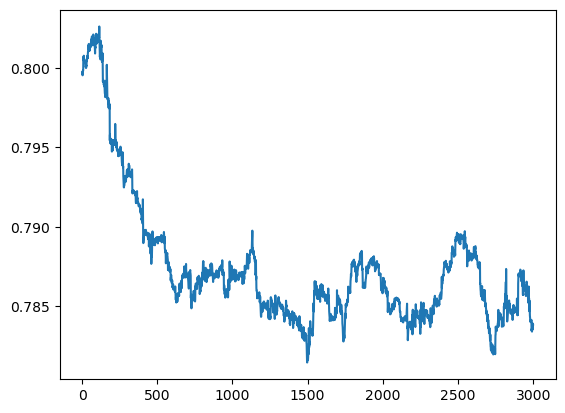

In [18]:
plt.plot(all_gain_samples[0][0,:,0])

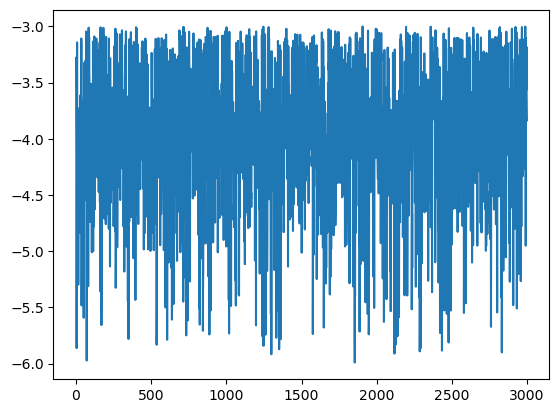

In [17]:
plt.plot(all_noise_samples[0][0,:,0])

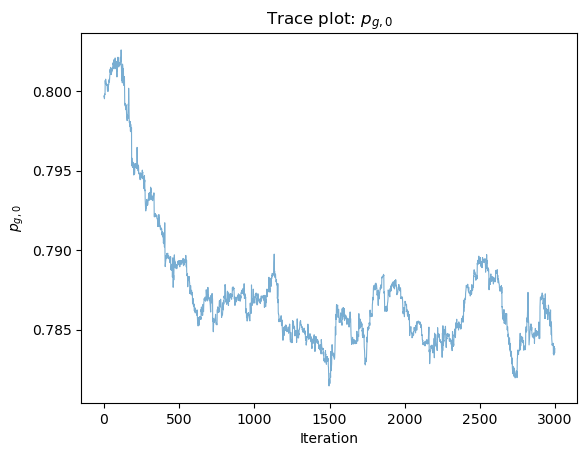

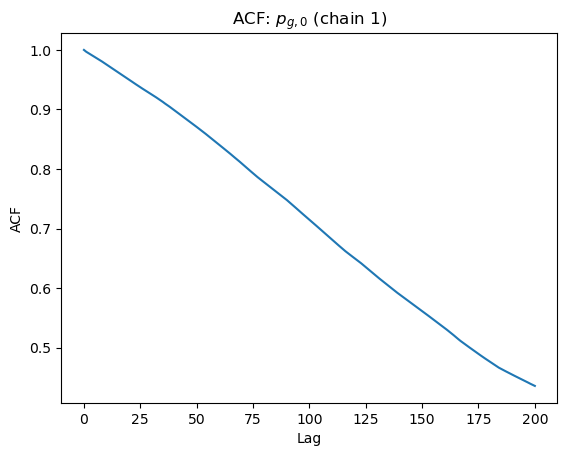

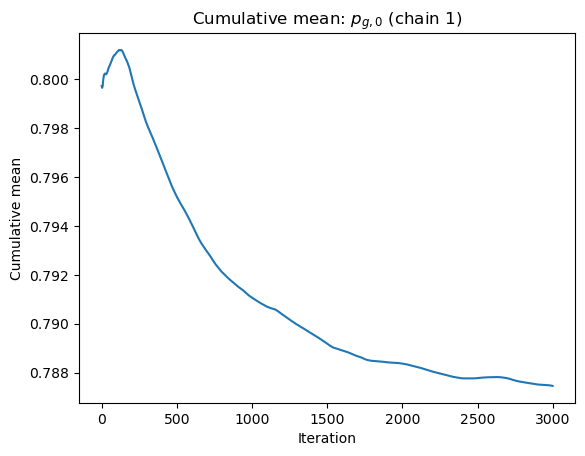

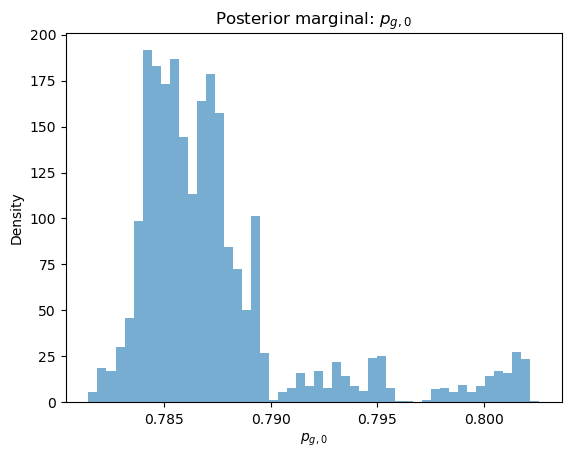

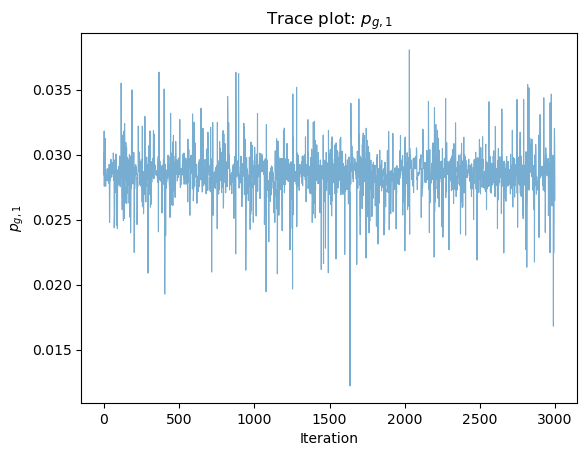

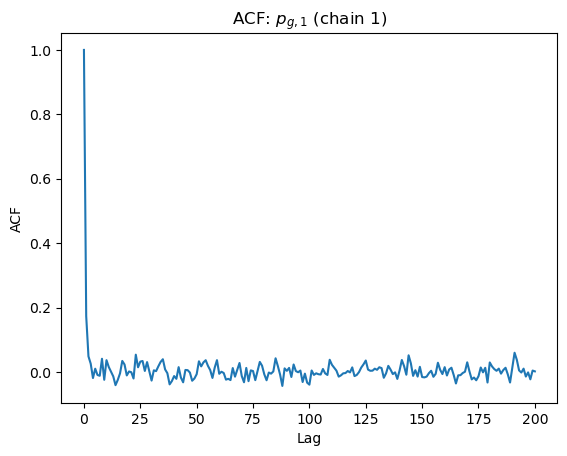

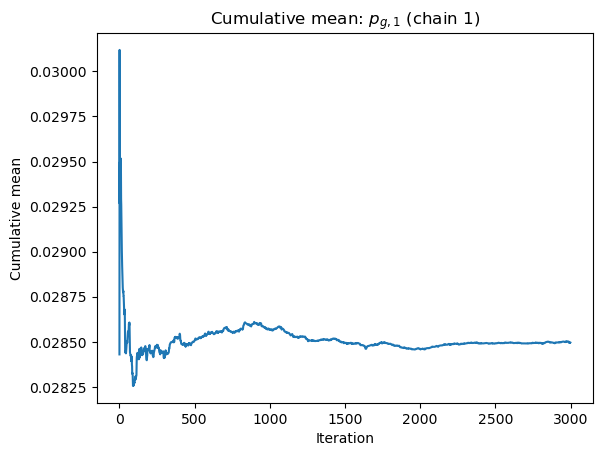

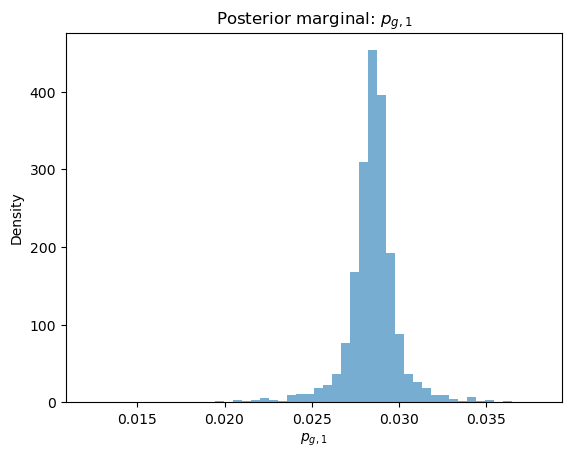

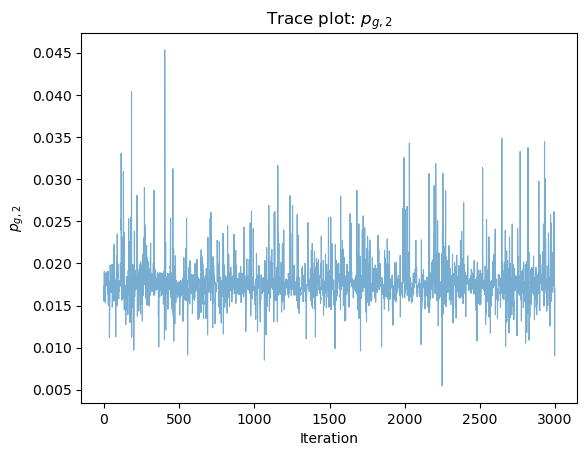

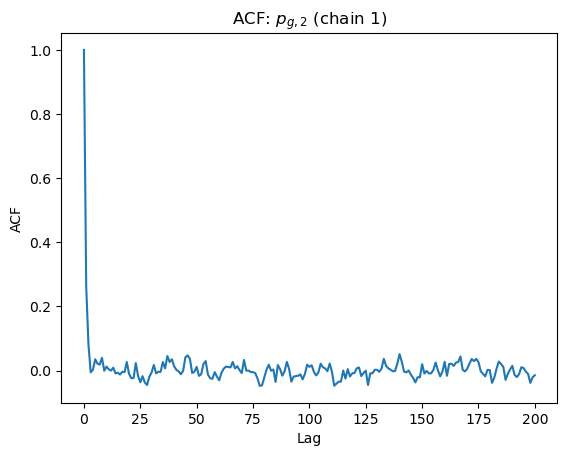

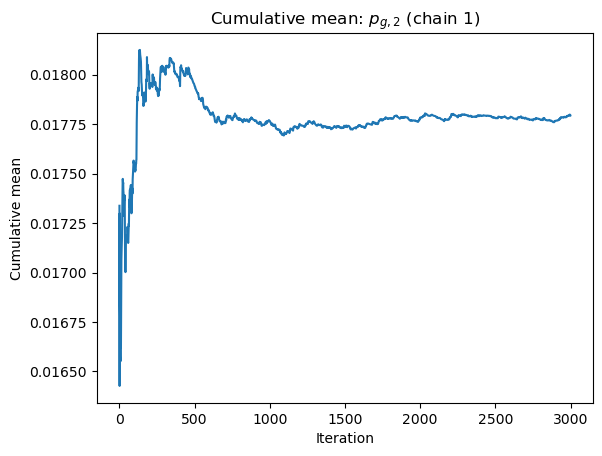

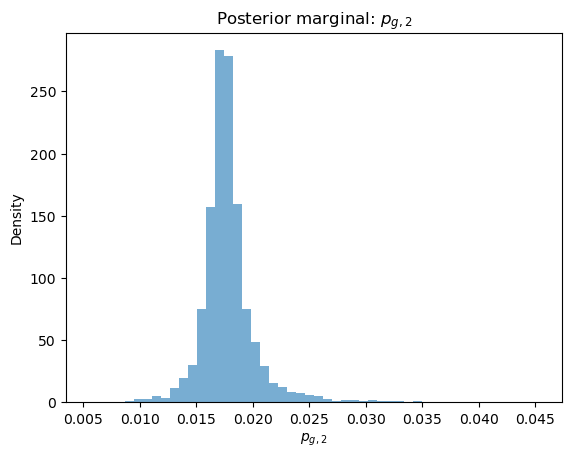

{'$p_{g,0}$': {'ESS_min': 6.440377268626616,
  'ESS_median': 6.440377268626616,
  'Rhat_split': 1.1856608638277002},
 '$p_{g,1}$': {'ESS_min': 2003.6958512062022,
  'ESS_median': 2003.6958512062022,
  'Rhat_split': 0.9996714400201924},
 '$p_{g,2}$': {'ESS_min': 1777.3157328724396,
  'ESS_median': 1777.3157328724396,
  'Rhat_split': 1.0001698452705834},
 '$p_{g,3}$': {'ESS_min': 1518.8682717885313,
  'ESS_median': 1518.8682717885313,
  'Rhat_split': 1.0007441133668225}}

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# ========== Generic MCMC Diagnostics Toolkit ==========
# Input: samples as numpy array of shape (n_chains, n_draws, n_params)

def acf_1d(x, max_lag=200):
    x = np.asarray(x)
    x = x - x.mean()
    n = len(x)
    var = np.var(x, ddof=0)
    fft = np.fft.rfft(x, n=2*n)
    acf_full = np.fft.irfft(fft * np.conjugate(fft))[:n]
    acf_full = acf_full / (var * np.arange(n, 0, -1))
    return acf_full[:max_lag+1]

def ess_1d(x):
    x = np.asarray(x)
    x = x - x.mean()
    n = len(x)
    var = np.var(x, ddof=0)
    if var == 0:
        return n
    fft = np.fft.rfft(x, n=2*n)
    acf = np.fft.irfft(fft * np.conjugate(fft))[:n]
    acf = acf / (var * np.arange(n, 0, -1))
    positive = acf[1:]
    pos_idx = np.argmax(positive <= 0.0)
    k = int(pos_idx) if (positive <= 0.0).any() else len(positive)
    s = 1 + 2 * np.sum(acf[1:1+k])
    return n / s if s > 0 else n

def rhat_split(chains_dim):
    m, n = chains_dim.shape
    if n % 2 == 1:
        chains_dim = chains_dim[:, :-1]
        n -= 1
    halves = np.reshape(chains_dim, (m*2, n//2))
    m2, n2 = halves.shape
    chain_means = halves.mean(axis=1)
    chain_vars = halves.var(axis=1, ddof=1)
    B = n2 * np.var(chain_means, ddof=1)
    W = np.mean(chain_vars)
    var_hat = (n2 - 1)/n2 * W + B/n2
    Rhat = np.sqrt(var_hat / W)
    return float(Rhat)

def diagnostics(samples, param_names=None, max_plots=3):
    n_chains, n_draws, n_params = samples.shape
    if param_names is None:
        param_names = [f"param{i}" for i in range(n_params)]
    
    summary = {}
    for d, name in enumerate(param_names):
        ess_list = [ess_1d(samples[c, :, d]) for c in range(n_chains)]
        summary[name] = {
            "ESS_min": float(np.min(ess_list)),
            "ESS_median": float(np.median(ess_list)),
            "Rhat_split": rhat_split(samples[:, :, d])
        }
    
    # --- Plot some quick diagnostics for first few parameters ---
    for d in range(min(n_params, max_plots)):
        name = param_names[d]
        
        # Trace
        plt.figure()
        for c in range(n_chains):
            plt.plot(samples[c, :, d], alpha=0.6, lw=0.8)
        plt.title(f"Trace plot: {name}")
        plt.xlabel("Iteration")
        plt.ylabel(name)
        plt.show()
        
        # ACF (first chain)
        acf_vals = acf_1d(samples[0, :, d])
        plt.figure()
        plt.plot(acf_vals)
        plt.title(f"ACF: {name} (chain 1)")
        plt.xlabel("Lag")
        plt.ylabel("ACF")
        plt.show()
        
        # Cumulative mean (first chain)
        cum_mean = np.cumsum(samples[0, :, d]) / np.arange(1, n_draws+1)
        plt.figure()
        plt.plot(cum_mean)
        plt.title(f"Cumulative mean: {name} (chain 1)")
        plt.xlabel("Iteration")
        plt.ylabel("Cumulative mean")
        plt.show()
        
        # Histogram
        flat = samples[:, :, d].reshape(-1)
        plt.figure()
        plt.hist(flat, bins=50, density=True, alpha=0.6)
        plt.title(f"Posterior marginal: {name}")
        plt.xlabel(name)
        plt.ylabel("Density")
        plt.show()
    
    return summary

# ========== Demo: Reuse previous Gibbs chains (2D Gaussian) ==========
summary_demo = diagnostics(all_gain_samples[0], param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"])
summary_demo

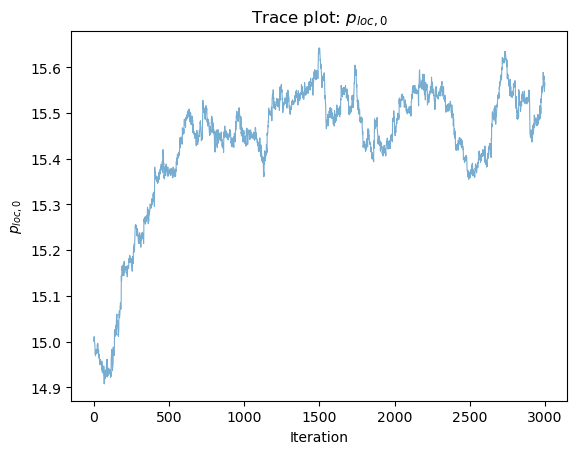

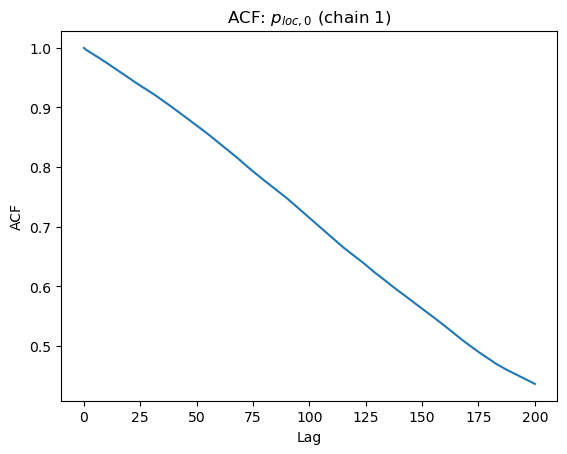

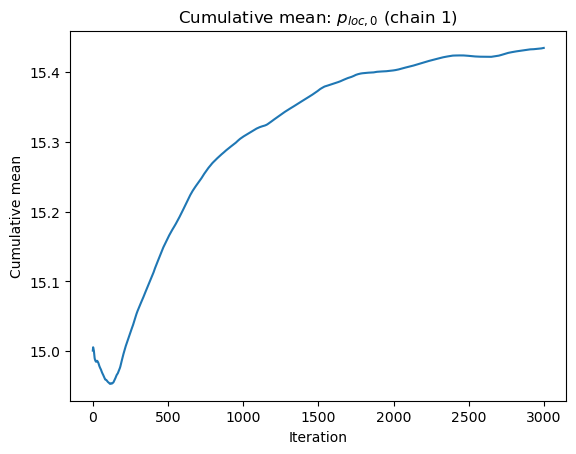

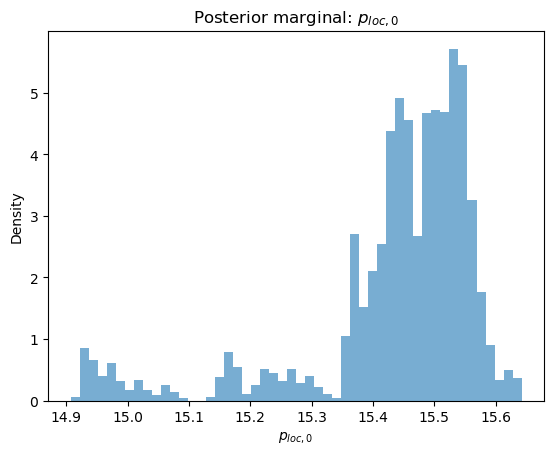

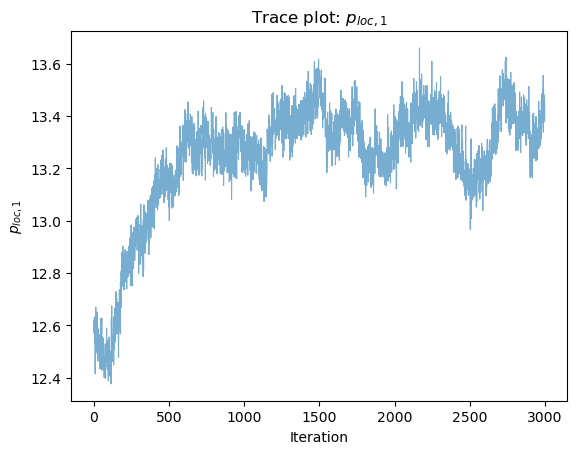

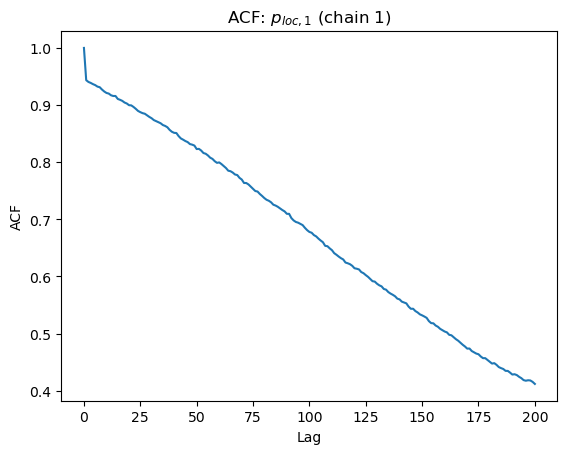

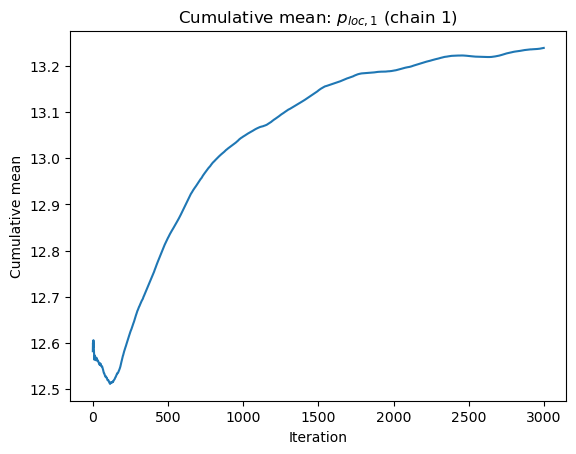

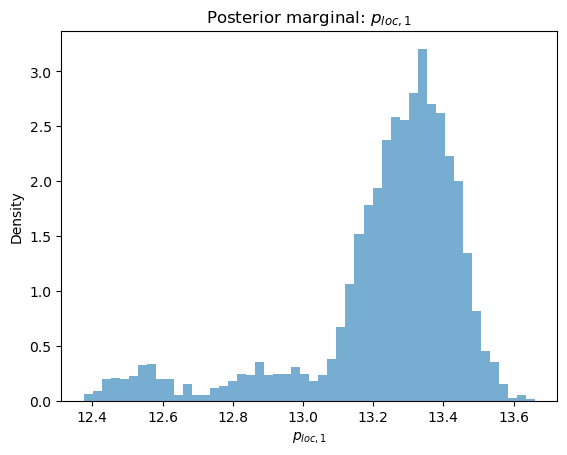

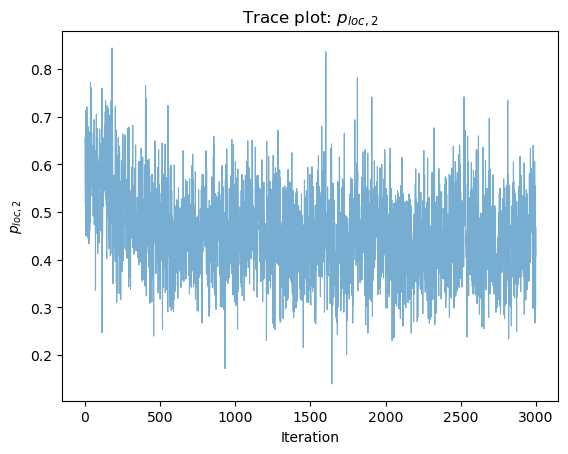

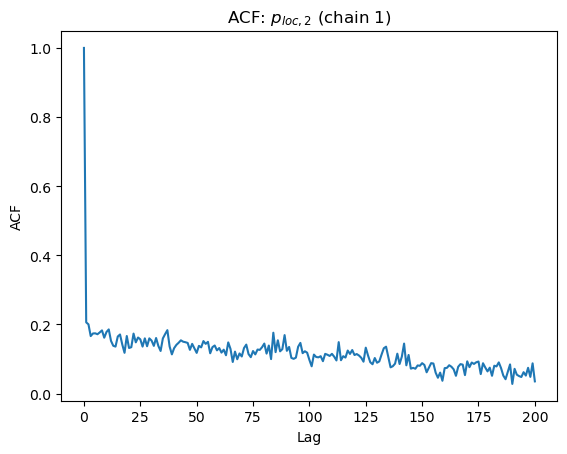

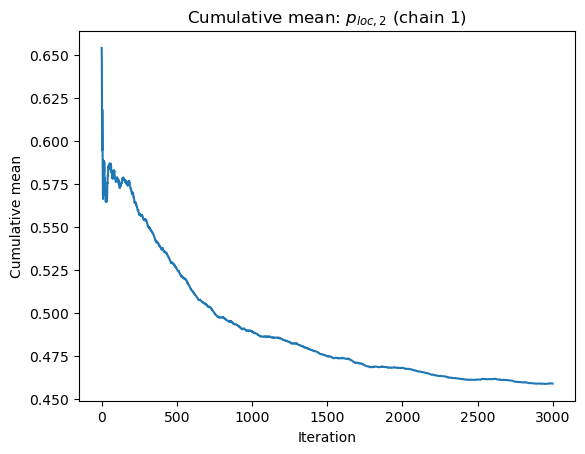

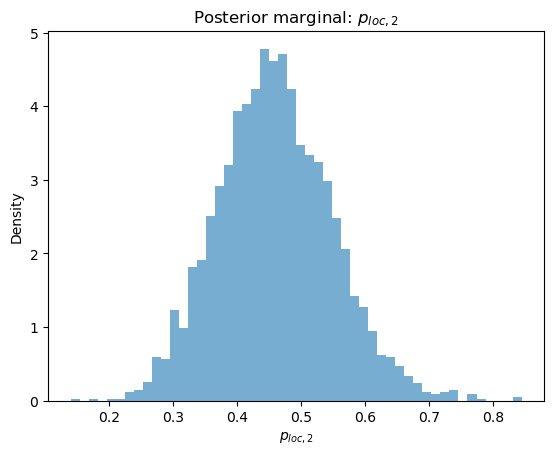

{'$p_{loc,0}$': {'ESS_min': 6.402093883815493,
  'ESS_median': 6.402093883815493,
  'Rhat_split': 1.1874702985368084},
 '$p_{loc,1}$': {'ESS_min': 6.780111431248319,
  'ESS_median': 6.780111431248319,
  'Rhat_split': 1.1767293983749516},
 '$p_{loc,2}$': {'ESS_min': 49.75814987004664,
  'ESS_median': 49.75814987004664,
  'Rhat_split': 1.0325792734958756},
 '$p_{loc,3}$': {'ESS_min': 222.56920433513596,
  'ESS_median': 222.56920433513596,
  'Rhat_split': 1.007884881438244},
 '$p_{loc,4}$': {'ESS_min': 2335.4972391912584,
  'ESS_median': 2335.4972391912584,
  'Rhat_split': 1.0002119422002536}}

In [25]:
# ========== Demo: Reuse previous Gibbs chains (2D Gaussian) ==========
summary_demo = diagnostics(Tsys_samples[:, -5:].reshape(1, -1, 5), param_names=[r"$p_{loc,0}$", r"$p_{loc,1}$",r"$p_{loc,2}$",r"$p_{loc,3}$",r"$p_{loc,4}$"])
summary_demo

(3000, 380)

In [24]:
sky_params.shape

(375,)